<a href="https://colab.research.google.com/github/Nahmadid/EpiPINN/blob/main/EPINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data generation
### Defining $\beta(t)$ with Multiple Waves

We model the transmission rate as a **Gaussian mixture**:

$$
\beta(t) \;=\; \sum_{m=1}^{M} r_m \, \exp\!\left(-\frac{(t - t_m)^2}{d_m^2}\right).
$$

---

**How to design “different waves”:**

- **Bigger wave** → increase amplitude $r_m$ (peak height).  
- **Earlier/later wave** → shift the center $t_m$ (time of peak).  
- **Wider/narrower wave** → change $d_m$ (controls duration).  
  - Approximate relation to width:  
    $$
    \text{FWHM} \;\approx\; 1.665\, d_m
    $$  
- **Add a new surge** → append new entries to $r$, $t_m$, and $d_m$ (all arrays must stay the same length).

---

**Parameter meanings:**

$$
r_m \;=\; \text{amplitude (peak height) of wave $m$}
$$

$$
t_m \;=\; \text{center (day of peak) of wave $m$}
$$

$$
d_m \;=\; \text{half-duration scale; larger $d_m$ → broader wave}
$$

---

**Relation to Gaussian variance:**

$$
\exp\!\left(-\frac{(t - t_m)^2}{d_m^2}\right)
\;=\;
\exp\!\left(-\frac{(t - t_m)^2}{2\sigma_m^2}\right),
\quad \text{with } \sigma_m = \tfrac{d_m}{2}.
$$


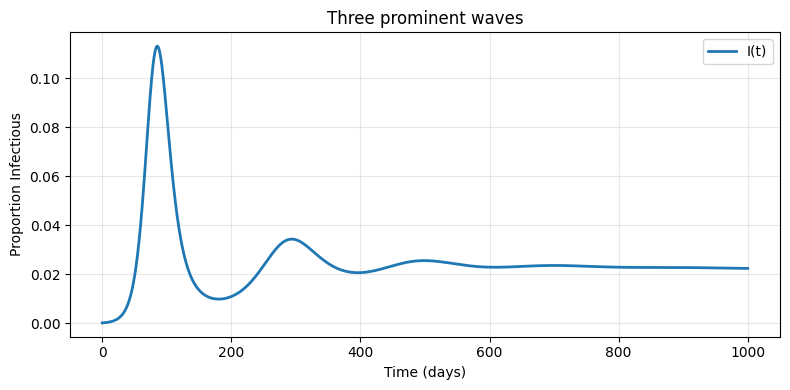

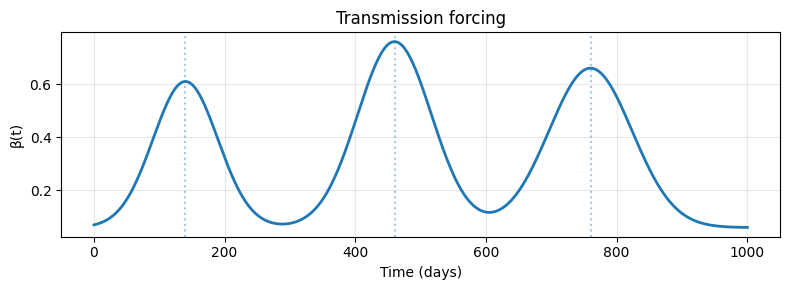

Peak days: [ 85.2 293.6 499.  699.7 862.2]
Peak sizes: [0.112992 0.034344 0.02559  0.023605 0.022794]


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --------- Fixed rates (per day) ----------
sigma = 1/5.5            # E -> I a bit faster
gamma = 1/6.0            # recovery
delta = 0.005            # disease mortality
omega = 1/120            # waning immunity (~4 months R -> S)
iota  = 2e-7             # tiny imports into E

# --------- β(t): baseline + 3 pulses ----------
beta0 = 0.06             # baseline transmission
r  = np.array([0.55, 0.70, 0.60])     # pulse heights
tm = np.array([140.0, 460.0, 760.0])  # centers (days)
dm = np.array([70.0,  80.0,  90.0])   # half-widths (controls wave width)

def beta_func(t_in):
    t = np.asarray(t_in)
    if t.ndim == 0: t = t[None]
    T = t.reshape(-1,1)
    pulses = r[None,:] * np.exp(-((T - tm[None,:])**2)/(dm[None,:]**2))
    return (beta0 + np.sum(pulses, axis=1)) if len(t)>1 else float(beta0 + np.sum(pulses))

# --------- SEIR with waning + imports ----------
def seir(y, t):
    S,E,I,R = y
    N = S+E+I+R
    beta = 0.4#beta_func(t)
    dS = -beta*S*I/N + omega*R
    dE =  beta*S*I/N - sigma*E + iota*N      # keep a spark
    dI =  sigma*E - (gamma+delta)*I
    dR =  gamma*I - omega*R
    return [dS,dE,dI,dR]

# --------- ICs and solve ----------
N0=1.0; I0=2e-4; E0=3e-4; R0=0.0; S0=N0-I0-E0-R0
y0=[S0,E0,I0,R0]
t = np.linspace(0,1000,20001)
S,E,I,R = odeint(seir, y0, t).T

# --------- Plot I(t) + β(t) ----------
plt.figure(figsize=(8,4))
plt.plot(t, I, lw=2, label="I(t)")
plt.xlabel("Time (days)"); plt.ylabel("Proportion Infectious")
plt.title("Three prominent waves")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3))
plt.plot(t, beta_func(t), lw=2, label="β(t)")
for x in tm: plt.axvline(x, ls=":", alpha=0.4)
plt.xlabel("Time (days)"); plt.ylabel("β(t)")
plt.title("Transmission forcing"); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# --------- Sanity: detect peaks ----------
peaks,_ = find_peaks(I, distance=200)
print("Peak days:", np.round(t[peaks],1))
print("Peak sizes:", np.round(I[peaks],6))


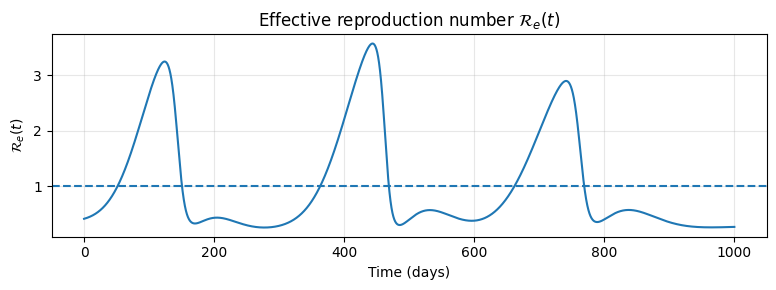

In [ ]:
Re = beta_func(t) * (S) / (gamma+delta)
plt.figure(figsize=(8,3))
plt.plot(t, Re); plt.axhline(1, ls='--')
plt.title(r"Effective reproduction number $\mathcal{R}_e(t)$")
plt.xlabel("Time (days)"); plt.ylabel(r"$\mathcal{R}_e(t)$")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


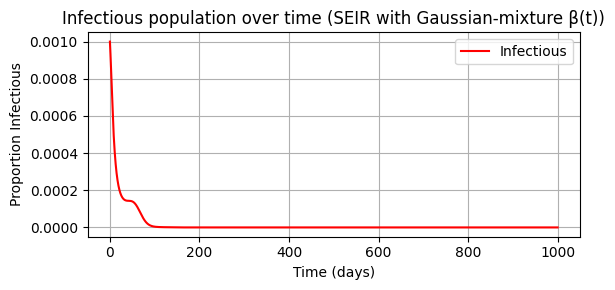

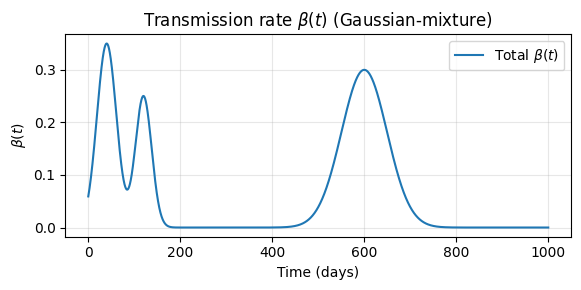

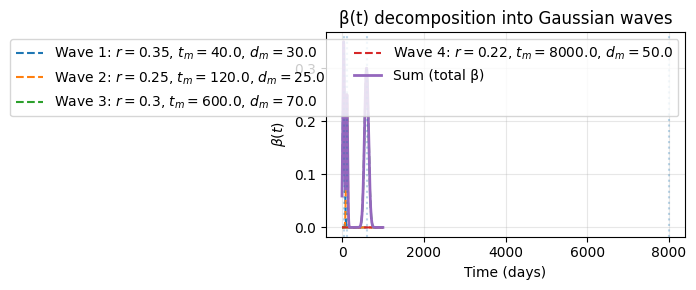

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# ---------------- Parameters ----------------
sigma = 1 / 6.57   # per day
gamma = 1 / 5      # per day
delta = 0.015      # per day

# ---------------- Gaussian Mixture β(t) ----------------
# r_m: amplitude, t_m: center, d_m: half pulse duration
r  = np.array([0.35, 0.25, 0.30, 0.22])     # amplitudes
tm = np.array([40.0, 120.0, 600.0, 8000.0])  # centers
dm = np.array([30.0, 25.0, 70.0, 50.0])     # half-durations

def beta_func(t_in):
    if np.isscalar(t_in):
        return float(np.sum(r * np.exp(-((t_in - tm) ** 2) / (dm ** 2))))
    t = np.asarray(t_in).reshape(-1, 1)
    val = np.sum(r[None, :] * np.exp(-((t - tm[None, :]) ** 2) / (dm[None, :] ** 2)), axis=1)
    return val

# ---------------- SEIR model ----------------
def seir_model(y, t):
    S, E, I, R = y
    N = S + E + I + R
    beta = beta_func(t)
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - (gamma + delta) * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

# ---------------- Initial conditions ----------------
N0 = 1.0
I0 = 0.001
E0 = 0.002
R0 = 0.0
S0 = N0 - I0 - E0 - R0
y0 = [S0, E0, I0, R0]

# ---------------- Time grid ----------------
t = np.linspace(0, 1000, 10001)

# ---------------- Solve ODE ----------------
sol = odeint(seir_model, y0, t)
S, E, I, R = sol.T

# ---------------- Plot Infectious only ----------------
plt.figure(figsize=(6, 3))
plt.plot(t, I, label="Infectious", color="red")
plt.xlabel("Time (days)")
plt.ylabel("Proportion Infectious")
plt.title("Infectious population over time (SEIR with Gaussian-mixture β(t))")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# ---------------- Plot β(t): total and per-wave decomposition ----------------
beta_total = beta_func(t)

def beta_components(t_grid):
    # returns shape (M, len(t_grid)) with each Gaussian component
    T = t_grid.reshape(-1, 1)                    # (T,1)
    comps = r[None, :] * np.exp(-((T - tm[None, :])**2) / (dm[None, :]**2))  # (T,M)
    return comps.T                                # (M,T)

comps = beta_components(t)

# 1) Plot total β(t)
plt.figure(figsize=(6, 3))
plt.plot(t, beta_total, label=r"Total $\beta(t)$")
plt.xlabel("Time (days)")
plt.ylabel(r"$\beta(t)$")
plt.title(r"Transmission rate $\beta(t)$ (Gaussian-mixture)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Plot per-wave decomposition + total overlay
plt.figure(figsize=(6, 3))
for i, (ri, tmi, dmi) in enumerate(zip(r, tm, dm), start=1):
    plt.plot(t, comps[i-1], linestyle="--", label=fr"Wave {i}: $r={ri}$, $t_m={tmi}$, $d_m={dmi}$")
plt.plot(t, beta_total, linewidth=2.0, label="Sum (total β)")
# Optional: mark centers
for tmi in tm:
    plt.axvline(tmi, linestyle=":", alpha=0.3)
plt.xlabel("Time (days)")
plt.ylabel(r"$\beta(t)$")
plt.title(r"β(t) decomposition into Gaussian waves")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

# # 3) Plot all SEIR states
# plt.figure(figsize=(10, 5))
# plt.plot(t, S, label="S (Susceptible)")
# plt.plot(t, E, label="E (Exposed)")
# plt.plot(t, I, label="I (Infectious)")
# plt.plot(t, R, label="R (Recovered)")
# plt.xlabel("Time (days)")
# plt.ylabel("Proportion")
# plt.title("SEIR state trajectories")
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.tight_layout()
# plt.show()


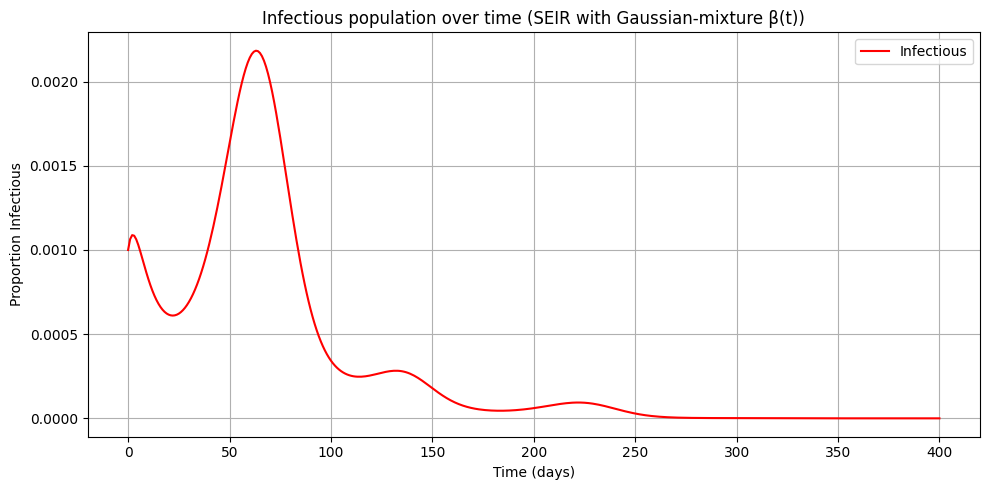

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# ---------------- Parameters ----------------
sigma = 1 / 6.57   # per day
gamma = 1 / 5      # per day
delta = 0.015      # per day

# ---------------- Gaussian Mixture β(t) ----------------
# r_m: amplitude, t_m: center, d_m: half pulse duration
r  = np.array([0.35, 0.25, 0.30, 0.22])     # amplitudes
tm = np.array([40.0, 120.0, 200.0, 300.0])  # centers
dm = np.array([30.0, 25.0, 35.0, 28.0])     # half-durations

def beta_func(t_in):
    if np.isscalar(t_in):
        return float(np.sum(r * np.exp(-((t_in - tm) ** 2) / (dm ** 2))))
    t = np.asarray(t_in).reshape(-1, 1)
    val = np.sum(r[None, :] * np.exp(-((t - tm[None, :]) ** 2) / (dm[None, :] ** 2)), axis=1)
    return val

# ---------------- SEIR model ----------------
def seir_model(y, t):
    S, E, I, R = y
    N = S + E + I + R
    beta = beta_func(t)
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - (gamma + delta) * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

# ---------------- Initial conditions ----------------
N0 = 1.0
I0 = 0.001
E0 = 0.002
R0 = 0.0
S0 = N0 - I0 - E0 - R0
y0 = [S0, E0, I0, R0]

# ---------------- Time grid ----------------
t = np.linspace(0, 400, 401)

# ---------------- Solve ODE ----------------
sol = odeint(seir_model, y0, t)
S, E, I, R = sol.T

# ---------------- Plot Infectious only ----------------
plt.figure(figsize=(10, 5))
plt.plot(t, I, label="Infectious", color="red")
plt.xlabel("Time (days)")
plt.ylabel("Proportion Infectious")
plt.title("Infectious population over time (SEIR with Gaussian-mixture β(t))")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#PIKANs_test

In [ ]:
# ============================================
# SEIR (4-state) PINN with KAN/Chebyshev basis
# β(t) predicted by the NN (5th head, softplus)
# Train on t <= 600, forecast the last wave
# ============================================

# --- Imports ---
import os, time, sys
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacrev
from jax.tree_util import tree_flatten
import optax
import matplotlib.pyplot as plt

# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R)
#     Uses the updated model you provided:
#       dS = -β S I / N + ω R
#       dE =  β S I / N - σ E + ι N
#       dI =  σ E - (γ+δ) I
#       dR =  γ I - ω R
#     β(t) for data generation = baseline + 3 Gaussians
# --------------------------------------------
def generate_seir_data(filename="simulated_data_seir.npz",
                       T=20001, t_end=1000.0):
    from scipy.integrate import odeint

    t = np.linspace(0.0, t_end, T)            # fine grid (dt = 0.05)
    t_i = np.array([[t[0]]], dtype=float)     # (1,1) initial-condition time

    # --- Rates (per day), waning + imports (matches your model) ---
    sigma = 1/5.5
    gamma = 1/6.0
    delta = 0.005
    omega = 1/120
    iota  = 2e-7

    # --- β(t) truth for data gen: baseline + 3 pulses ---
    beta0 = 0.06
    r  = np.array([0.55, 0.70, 0.60])
    tm = np.array([140.0, 460.0, 760.0])
    dm = np.array([70.0,  80.0,  90.0])

    def beta_func(tt):
        tt = np.atleast_1d(tt)
        Tcol = tt.reshape(-1,1)
        pulses = r[None,:] * np.exp(-((Tcol - tm[None,:])**2)/(dm[None,:]**2))
        out = beta0 + np.sum(pulses, axis=1)
        return out if out.size>1 else float(out)

    def rhs(y, tt):
        S, E, I, R = y
        N = S + E + I + R
        beta = beta_func(tt)
        dS = -beta * S * I / N + omega * R
        dE =  beta * S * I / N - sigma * E + iota * N
        dI =  sigma * E - (gamma + delta) * I
        dR =  gamma * I - omega * R
        return [dS, dE, dI, dR]

    # IC
    N0, I0, E0, R0 = 1.0, 2e-4, 3e-4, 0.0
    S0 = N0 - I0 - E0 - R0
    y0 = [S0, E0, I0, R0]

    sol = odeint(rhs, y0, t)  # (T,4)
    data = sol.astype(float)

    # scale factors per state
    max_scl = np.maximum(1.0, np.max(np.abs(data), axis=0))  # (4,)
    IC = np.array([[S0, E0, I0, R0]], dtype=float)           # (1,4)

    np.savez(filename, data=data, t=t, t_i=t_i, IC=IC, max_scl=max_scl)
    print(f"Saved {filename}: data.shape={data.shape}, max_scl={max_scl}")

# Generate once (comment this out if you already have data)
generate_seir_data()

# --------------------------------------------
# (B) Load data (4 states) and set train horizon (<=600)
# --------------------------------------------
loaded = np.load("simulated_data_seir.npz")
data_full = loaded["data"]        # (T,4) -> S,E,I,R
t_full    = loaded["t"]           # (T,)
t_i       = loaded["t_i"]         # (1,1)
IC        = loaded["IC"]          # (1,4)
max_scl   = loaded["max_scl"]     # (4,)

T_MAX = float(t_full[-1])         # for time normalization in NN

# Train only on first 600 days
T_CUT = 600.0
mask_train = t_full <= T_CUT
t_data = t_full                    # keep full for plotting
data   = data_full

t_dense_train = jnp.asarray(t_full[mask_train])[:, None]   # collocation times <= 600
t_data_train  = jnp.asarray(t_full[mask_train])[:, None]   # data times <= 600
data_train    = jnp.asarray(data_full[mask_train])         # (T_train,4)

# Which variables have data? (choose any subset of 0:S,1:E,2:I,3:R)
x_index = [2]  # Infectious only

# --------------------------------------------
# (C) KAN model (Chebyshev-based)
# --------------------------------------------
def init_params_kan(layers, degree, key=jax.random.PRNGKey(1283)):
    # layers like [1, 70, 70, 5]
    keys = jax.random.split(key, len(layers) - 1)
    params = []
    # Hidden layers with Chebyshev coeffs
    for k, n_in, n_out in zip(keys[:-1], layers[:-2], layers[1:-1]):
        W = jax.random.normal(k, shape=(n_in, n_out, degree + 1)) / jnp.sqrt(n_in * (degree + 1))
        B = jax.random.normal(k, shape=(n_out,))
        params.append({'W': W, 'B': B})
    # Linear readout
    W = jax.random.normal(keys[-1], shape=(layers[-2], layers[-1])) / jnp.sqrt(layers[-2])
    B = jax.random.normal(keys[-1], shape=(layers[-1],))
    params.append({'W': W, 'B': B})
    return params

def chebyshev_recursive(x, degree):
    # returns T_degree(x) evaluated elementwise
    if degree == 0:
        return x*0 + 1
    if degree == 1:
        return x
    Tm2 = x*0 + 1
    Tm1 = x
    for n in range(2, degree + 1):
        Tn = 2 * x * Tm1 - Tm2
        Tm2, Tm1 = Tm1, Tn
    return Tm1

def fwd(params, t, activation=jax.nn.tanh, degree=3):
    # Normalize time to ~[0,1] using full horizon (0..1000)
    t = t / T_MAX
    X = t.reshape((-1, 1))                   # (B,1)
    *hidden, last = params
    for layer in hidden:
        X = activation(X)
        coeffs = layer['W']                  # (in,out,deg+1)
        deg = coeffs.shape[2] - 1
        X_stack = jnp.stack([chebyshev_recursive(X, d) for d in range(deg + 1)], axis=-1)  # (B,in,deg+1)
        X = jnp.einsum("bid,iod->bo", X_stack, coeffs)   # (B,out)
        X = activation(X)
    return jnp.dot(X, last['W']) + last['B']             # (B,5): [S,E,I,R,beta_raw]

# --------------------------------------------
# (D) Losses (IC, Data, ODE)
# --------------------------------------------
@jax.jit
def MSE(true, pred):  # true/pred: (B,dim) or (1,dim)
    return jnp.mean((true - pred) ** 2)

def ODE_loss(params, t, y_func, max_scl):
    """
    Returns list of 4 residual arrays (one per state): each (T,1,1)
    β has no dynamic residual; it's used in RHS via softplus(beta_raw).
    """
    # Updated SEIR constants (match generator)
    sigma = 1/5.5
    gamma = 1/6.0
    delta = 0.005
    omega = 1/120
    iota  = 2e-7

    y_vals = jax.vmap(y_func)(t)           # (T,5) -> S,E,I,R,beta_raw (scaled states)
    dy_dt  = jax.vmap(jacrev(y_func))(t)   # (T,5,1)

    # Scale up states to physical scale; β is not scaled
    S = y_vals[:, 0:1] * max_scl[0]
    E = y_vals[:, 1:2] * max_scl[1]
    I = y_vals[:, 2:3] * max_scl[2]
    R = y_vals[:, 3:4] * max_scl[3]
    # beta_t = jax.nn.softplus(y_vals[:, 4:5]) + 1e-8   # enforce β ≥ 0

    N = S + E + I + R
    def beta_func(tt):
        tt = np.atleast_1d(tt)
        Tcol = tt.reshape(-1,1)
        pulses = r[None,:] * np.exp(-((Tcol - tm[None,:])**2)/(dm[None,:]**2))
        out = beta0 + np.sum(pulses, axis=1)
        return out if out.size>1 else float(out)
=
    beta_t = beta_func(tt)
    # New RHS with waning + imports
    dS = -beta_t * S * I / N + omega * R
    dE =  beta_t * S * I / N - sigma * E + iota * N
    dI =  sigma * E - (gamma + delta) * I
    dR =  gamma * I - omega * R

    # Rescale back to compare with NN time-derivatives
    rhs_S = dS / max_scl[0]
    rhs_E = dE / max_scl[1]
    rhs_I = dI / max_scl[2]
    rhs_R = dR / max_scl[3]

    res_S = dy_dt[:, 0:1, :] - rhs_S.reshape(-1,1,1)
    res_E = dy_dt[:, 1:2, :] - rhs_E.reshape(-1,1,1)
    res_I = dy_dt[:, 2:3, :] - rhs_I.reshape(-1,1,1)
    res_R = dy_dt[:, 3:4, :] - rhs_R.reshape(-1,1,1)

    return [res_S, res_E, res_I, res_R]

def loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data_train, max_scl):
    y_func = lambda tt: fwd(params, tt.reshape(1,1)).squeeze()  # -> (5,)

    # ODE residuals at collocation times (<=600)
    residuals = ODE_loss(params, t_c, y_func, max_scl)
    loss_odes = [lambdas[i] * jnp.mean(res**2) for i, res in enumerate(residuals)]

    # IC loss on first 4 states
    pred_IC = fwd(params, t_i)[:, :4]  # (1,4)
    loss_IC = MSE(jnp.asarray(data_IC), pred_IC)

    # Data loss on observed channels at t_d (<=600)
    pred_d = fwd(params, t_d)[:, :4]   # (T_train,4)
    loss_data = sum(MSE(jnp.asarray(data_train)[:, i:i+1], pred_d[:, i:i+1]) for i in x_index)

    return loss_IC, loss_data, *loss_odes  # total of 2 + 4 = 6 terms

def loss_fun_total(params, lambdas, t_i, t_d, t_c, data_IC, data_train, loss_weight, max_scl):
    losses = loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data_train, max_scl)
    return sum(w * l for w, l in zip(loss_weight, losses))

# --------------------------------------------
# (E) Training
# --------------------------------------------
def train_model(params, lambdas, t_i, t_d, t_c, data_IC, data_train, max_scl, epochs, loss_weight):
    optimizer = optax.adam(1e-4)
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fun_total)(
            params, lambdas, t_i, t_d, t_c, data_IC, data_train, loss_weight, max_scl
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(epochs):
        params, opt_state, loss = update(params, opt_state)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {float(loss):.2e}")
    return params

# --------------------------------------------
# (F) Plotting
# --------------------------------------------
def plot_predicted_vs_data(params, t_data, data, scale_factor, run_id):
    pred = fwd(params, jnp.asarray(t_data).reshape(-1,1))  # (T,5)
    var_names = ['S', 'E', 'I', 'R']
    fig, axs = plt.subplots(2, 2, figsize=(10,6))
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(t_data, data[:, i] * scale_factor[i], 'b-', label='True')
        axs[i].plot(t_data, pred[:, i] * scale_factor[i], 'k--', label='PINN')
        axs[i].set_title(var_names[i]); axs[i].grid(True)
        if i == 0: axs[i].legend()
    plt.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    plt.savefig(f"pred_vs_true_run{run_id}.pdf")
    plt.close()

# --------------------------------------------
# (G) Run training (train on <=600, plot on full 0..1000)
# --------------------------------------------
layers = [1, 15, 15, 15, 5]                 # 5 outputs: S,E,I,R,β_raw
loss_weight = [0.5, 1.0] + [1, 1, 0.1, 1]   # IC, Data, then 4 ODE residuals

for run_id in range(1):
    print(f"\n=== Run {run_id} ===")
    key = jax.random.PRNGKey(run_id*706)
    params = init_params_kan(layers, degree=3, key=key)
    lambdas = [1.0] * 4

    trained = train_model(
        params, lambdas,
        jnp.asarray(t_i),              # IC time
        t_data_train,                  # data times <= 600
        t_dense_train,                 # collocation times <= 600
        jnp.asarray(IC),
        data_train,                    # observed data <= 600
        jnp.asarray(max_scl),
        epochs=150001,
        loss_weight=loss_weight
    )

    # Save params (flatten like before)
    flat, _ = tree_flatten(trained)
    os.makedirs("multi_run_results", exist_ok=True)
    np.savez(f"multi_run_results/params_run{run_id}.npz", *[np.array(p) for p in flat])

    # Plot on the FULL horizon (0..1000) to see the forecast of the last wave
    plot_predicted_vs_data(trained, t_data, data, max_scl, run_id)

print("✅ Done. Results saved in multi_run_results/ (params + PDF plot)")


SyntaxError: invalid syntax (ipython-input-3224520608.py, line 187)

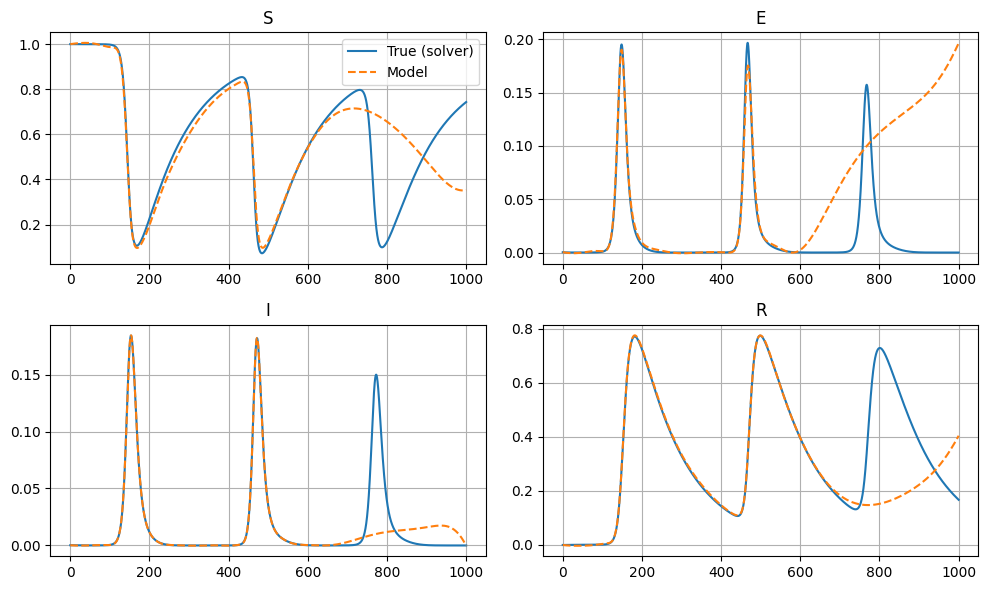

Plotted final comparison and saved to multi_run_results/pred_vs_true_runfinal.pdf


In [ ]:
def plot_predicted_vs_data(params, t_data, data_true, scale_factor, run_id, show=True):
    """
    Plots S,E,I,R: true (solver) vs model prediction.
    Saves a PDF and optionally shows the figure inline.
    """
    pred = fwd(params, jnp.asarray(t_data).reshape(-1,1))
    var_names = ['S', 'E', 'I', 'R']
    fig, axs = plt.subplots(2, 2, figsize=(10,6))
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(t_data, data_true[:, i] * scale_factor[i], label='True (solver)')
        axs[i].plot(t_data, pred[:, i] * scale_factor[i], linestyle='--', label='Model')
        axs[i].set_title(var_names[i]); axs[i].grid(True)
        if i == 0: axs[i].legend()
    plt.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    plt.savefig(f"multi_run_results/pred_vs_true_run{run_id}.pdf")
    if show:
        plt.show()
    else:
        plt.close()
# --- Final visualization for the last trained model ---
# 'trained' contains the params from the last run in the loop above.
plot_predicted_vs_data(trained, t_data, data, max_scl, run_id="final", show=True)
print("Plotted final comparison and saved to multi_run_results/pred_vs_true_runfinal.pdf")


In [ ]:
# ============================================
# SEIR (4-state) PINN with KAN/Chebyshev basis
# β(t) predicted by NN (5th head, softplus)
# Inputs to NN = [t, tm_1, tm_2, tm_3]
# Train on t <= 600, forecast last wave
# ============================================

# --- Imports ---
import os, time, sys
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacrev
from jax.tree_util import tree_flatten
import optax
import matplotlib.pyplot as plt

# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R)
# --------------------------------------------
def generate_seir_data(filename="simulated_data_seir.npz",
                       T=20001, t_end=1000.0):
    from scipy.integrate import odeint

    t = np.linspace(0.0, t_end, T)            # fine grid (dt = 0.05)
    t_i = np.array([[t[0]]], dtype=float)     # (1,1) initial-condition time

    # --- Rates (per day), waning + imports ---
    sigma = 1/5.5
    gamma = 1/6.0
    delta = 0.005
    omega = 1/120
    iota  = 2e-7

    # --- β(t) truth for data gen: baseline + 3 pulses ---
    beta0 = 0.06
    r  = np.array([0.55, 0.70, 0.60])
    tm = np.array([140.0, 460.0, 760.0])
    dm = np.array([70.0,  80.0,  90.0])

    def beta_func(tt):
        tt = np.atleast_1d(tt)
        Tcol = tt.reshape(-1,1)
        pulses = r[None,:] * np.exp(-((Tcol - tm[None,:])**2)/(dm[None,:]**2))
        out = beta0 + np.sum(pulses, axis=1)
        return out if out.size>1 else float(out)

    def rhs(y, tt):
        S, E, I, R = y
        N = S + E + I + R
        beta = beta_func(tt)
        dS = -beta * S * I / N + omega * R
        dE =  beta * S * I / N - sigma * E + iota * N
        dI =  sigma * E - (gamma + delta) * I
        dR =  gamma * I - omega * R
        return [dS, dE, dI, dR]

    # IC
    N0, I0, E0, R0 = 1.0, 2e-4, 3e-4, 0.0
    S0 = N0 - I0 - E0 - R0
    y0 = [S0, E0, I0, R0]

    sol = odeint(rhs, y0, t)  # (T,4)
    data = sol.astype(float)

    # scale factors per state
    max_scl = np.maximum(1.0, np.max(np.abs(data), axis=0))  # (4,)
    IC = np.array([[S0, E0, I0, R0]], dtype=float)           # (1,4)

    np.savez(filename, data=data, t=t, t_i=t_i, IC=IC, max_scl=max_scl)
    print(f"Saved {filename}: data.shape={data.shape}, max_scl={max_scl}")

# Generate once (comment out if you already have data)
generate_seir_data()

# --------------------------------------------
# (B) Load data and set train horizon (<=600)
# --------------------------------------------
loaded = np.load("simulated_data_seir.npz")
data_full = loaded["data"]        # (T,4) -> S,E,I,R
t_full    = loaded["t"]           # (T,)
t_i       = loaded["t_i"]         # (1,1)
IC        = loaded["IC"]          # (1,4)
max_scl   = loaded["max_scl"]     # (4,)

T_MAX = float(t_full[-1])         # 1000 (for normalization)

# Train only on first 600 days
T_CUT = 600.0
mask_train = t_full <= T_CUT
t_data       = t_full                    # full for plotting
data         = data_full
t_dense_train= jnp.asarray(t_full[mask_train])[:, None]   # collocation times <= 600
t_data_train = jnp.asarray(t_full[mask_train])[:, None]   # data times <= 600
data_train   = jnp.asarray(data_full[mask_train])         # (T_train,4)

# We feed the pulse centers tm as *inputs* to the NN
TM_HINT = jnp.array([140.0, 460.0, 760.0], dtype=jnp.float32)
K_IN = int(TM_HINT.shape[0])       # number of tm features

# Which variables have data? (0:S,1:E,2:I,3:R)
x_index = [1,2, 3, 4]  # Infectious only

# --------------------------------------------
# (C) KAN model (Chebyshev-based)
# --------------------------------------------
def init_params_kan(layers, degree, key=jax.random.PRNGKey(1283)):
    # layers like [1+K_IN, 70, 70, 5]
    keys = jax.random.split(key, len(layers) - 1)
    params = []
    # Hidden layers with Chebyshev coeffs
    for k, n_in, n_out in zip(keys[:-1], layers[:-2], layers[1:-1]):
        W = jax.random.normal(k, shape=(n_in, n_out, degree + 1)) / jnp.sqrt(n_in * (degree + 1))
        B = jax.random.normal(k, shape=(n_out,))
        params.append({'W': W, 'B': B})
    # Linear readout
    W = jax.random.normal(keys[-1], shape=(layers[-2], layers[-1])) / jnp.sqrt(layers[-2])
    B = jax.random.normal(keys[-1], shape=(layers[-1],))
    params.append({'W': W, 'B': B})
    return params

def chebyshev_recursive(x, degree):
    # returns T_degree(x) evaluated elementwise
    if degree == 0:
        return x*0 + 1
    if degree == 1:
        return x
    Tm2 = x*0 + 1
    Tm1 = x
    for n in range(2, degree + 1):
        Tn = 2 * x * Tm1 - Tm2
        Tm2, Tm1 = Tm1, Tn
    return Tm1

def build_input(t, tm_vec):
    """ Concatenate normalized time and normalized tm features.
        t: (B,1), tm_vec: (K,) """
    t_norm  = t / T_MAX                        # (B,1)
    tm_norm = (tm_vec / T_MAX)[None, :]        # (1,K)
    tm_tile = jnp.broadcast_to(tm_norm, (t_norm.shape[0], tm_norm.shape[1]))  # (B,K)
    return jnp.concatenate([t_norm, tm_tile], axis=1)                          # (B,1+K)

def fwd(params, t, tm_vec=TM_HINT, activation=jax.nn.tanh, degree=3):
    X = build_input(t.reshape(-1,1), tm_vec)   # (B, 1+K)
    *hidden, last = params
    for layer in hidden:
        X = activation(X)
        coeffs = layer['W']                  # (in,out,deg+1)
        deg = coeffs.shape[2] - 1
        X_stack = jnp.stack([chebyshev_recursive(X, d) for d in range(deg + 1)], axis=-1)  # (B,in,deg+1)
        X = jnp.einsum("bid,iod->bo", X_stack, coeffs)   # (B,out)
        X = activation(X)
    return jnp.dot(X, last['W']) + last['B']             # (B,5): [S,E,I,R,beta_raw]

# --------------------------------------------
# (D) Losses (IC, Data, ODE)
# --------------------------------------------
@jax.jit
def MSE(true, pred):  # true/pred: (B,dim) or (1,dim)
    return jnp.mean((true - pred) ** 2)

def ODE_loss(params, t, y_func, max_scl):
    """
    Returns list of 4 residual arrays (one per state): each (T,1,1)
    β has no dynamic residual; it's used in RHS via softplus(beta_raw).
    """
    # Updated SEIR constants (match generator)
    sigma = 1/5.5
    gamma = 1/6.0
    delta = 0.005
    omega = 1/120
    iota  = 2e-7

    y_vals = jax.vmap(y_func)(t)           # (T,5) -> S,E,I,R,beta_raw
    dy_dt  = jax.vmap(jacrev(y_func))(t)   # (T,5,1), derivative wrt time only

    # Scale up states to physical scale; β is not scaled
    S = y_vals[:, 0:1] * max_scl[0]
    E = y_vals[:, 1:2] * max_scl[1]
    I = y_vals[:, 2:3] * max_scl[2]
    R = y_vals[:, 3:4] * max_scl[3]
    beta_t = jax.nn.softplus(y_vals[:, 4:5]) + 1e-8   # enforce β ≥ 0

    N = S + E + I + R

    # RHS with waning + imports
    dS = -beta_t * S * I / N + omega * R
    dE =  beta_t * S * I / N - sigma * E + iota * N
    dI =  sigma * E - (gamma + delta) * I
    dR =  gamma * I - omega * R

    # Rescale back to compare with NN time-derivatives
    rhs_S = dS / max_scl[0]
    rhs_E = dE / max_scl[1]
    rhs_I = dI / max_scl[2]
    rhs_R = dR / max_scl[3]

    res_S = dy_dt[:, 0:1, :] - rhs_S.reshape(-1,1,1)
    res_E = dy_dt[:, 1:2, :] - rhs_E.reshape(-1,1,1)
    res_I = dy_dt[:, 2:3, :] - rhs_I.reshape(-1,1,1)
    res_R = dy_dt[:, 3:4, :] - rhs_R.reshape(-1,1,1)

    return [res_S, res_E, res_I, res_R]

def loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data_train, max_scl):
    # Hold tm fixed as an *input feature* (not trained)
    y_func = lambda tt: fwd(params, tt.reshape(1,1), TM_HINT).squeeze()  # -> (5,)

    # ODE residuals at collocation times (<=600)
    residuals = ODE_loss(params, t_c, y_func, max_scl)
    loss_odes = [lambdas[i] * jnp.mean(res**2) for i, res in enumerate(residuals)]

    # IC loss on first 4 states
    pred_IC = fwd(params, t_i, TM_HINT)[:, :4]  # (1,4)
    loss_IC = MSE(jnp.asarray(data_IC), pred_IC)

    # Data loss on observed channels at t_d (<=600)
    pred_d = fwd(params, t_d, TM_HINT)[:, :4]   # (T_train,4)
    loss_data = sum(MSE(jnp.asarray(data_train)[:, i:i+1], pred_d[:, i:i+1]) for i in x_index)

    return loss_IC, loss_data, *loss_odes  # 6 terms

def loss_fun_total(params, lambdas, t_i, t_d, t_c, data_IC, data_train, loss_weight, max_scl):
    losses = loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data_train, max_scl)
    return sum(w * l for w, l in zip(loss_weight, losses))

# --------------------------------------------
# (E) Training
# --------------------------------------------
def train_model(params, lambdas, t_i, t_d, t_c, data_IC, data_train, max_scl, epochs, loss_weight):
    optimizer = optax.adam(1e-4)
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fun_total)(
            params, lambdas, t_i, t_d, t_c, data_IC, data_train, loss_weight, max_scl
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(epochs):
        params, opt_state, loss = update(params, opt_state)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {float(loss):.2e}")
    return params

# --------------------------------------------
# (F) Plotting
# --------------------------------------------
def plot_predicted_vs_data(params, t_data, data, scale_factor, run_id):
    pred = fwd(params, jnp.asarray(t_data).reshape(-1,1), TM_HINT)  # (T,5)
    var_names = ['S', 'E', 'I', 'R']
    fig, axs = plt.subplots(2, 2, figsize=(10,6))
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(t_data, data[:, i] * scale_factor[i], 'b-', label='True')
        axs[i].plot(t_data, pred[:, i] * scale_factor[i], 'k--', label='PINN')
        axs[i].set_title(var_names[i]); axs[i].grid(True)
        if i == 0: axs[i].legend()
    plt.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    plt.savefig(f"pred_vs_true_run{run_id}.pdf")
    plt.close()

# --------------------------------------------
# (G) Run training (train on <=600, plot on full 0..1000)
# --------------------------------------------
layers = [1 + K_IN, 15, 15, 15, 5]          # INPUT = [t, tm1, tm2, tm3]
loss_weight = [0.5, 1.0] + [1, 1, 0.1, 1]   # IC, Data, then 4 ODE residuals

for run_id in range(1):
    print(f"\n=== Run {run_id} ===")
    key = jax.random.PRNGKey(run_id*706)
    params = init_params_kan(layers, degree=3, key=key)
    lambdas = [1.0] * 4

    trained = train_model(
        params, lambdas,
        jnp.asarray(t_i),              # IC time
        t_data_train,                  # data times <= 600
        t_dense_train,                 # collocation times <= 600
        jnp.asarray(IC),
        data_train,                    # observed data <= 600
        jnp.asarray(max_scl),
        epochs=150001,
        loss_weight=loss_weight
    )

    # Save params (flatten like before)
    flat, _ = tree_flatten(trained)
    os.makedirs("multi_run_results", exist_ok=True)
    np.savez(f"multi_run_results/params_run{run_id}.npz", *[np.array(p) for p in flat])

    # Plot on the FULL horizon (0..1000) to see the forecast of the last wave
    plot_predicted_vs_data(trained, t_data, data, max_scl, run_id)

print("✅ Done. Results saved in multi_run_results/ (params + PDF plot)")


/tmp/ipython-input-3208008358.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return out if out.size>1 else float(out)


Saved simulated_data_seir.npz: data.shape=(20001, 4), max_scl=[1. 1. 1. 1.]

=== Run 0 ===
Epoch 0, Loss: nan
Epoch 1000, Loss: nan
Epoch 2000, Loss: nan
Epoch 3000, Loss: nan
Epoch 4000, Loss: nan
Epoch 5000, Loss: nan
Epoch 6000, Loss: nan
Epoch 7000, Loss: nan
Epoch 8000, Loss: nan
Epoch 9000, Loss: nan
Epoch 10000, Loss: nan
Epoch 11000, Loss: nan
Epoch 12000, Loss: nan
Epoch 13000, Loss: nan
Epoch 14000, Loss: nan


KeyboardInterrupt: 

#PINNs_Test

In [ ]:
# ============================================
# SEIR (4-state) PINN with KAN/Chebyshev basis
# ============================================

# --- Imports ---
import os, time, sys
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import jacrev
from jax.tree_util import tree_flatten
import optax
import matplotlib.pyplot as plt

# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R)
# --------------------------------------------
def generate_seir_data(filename="simulated_data_seir.npz",
                       T=300, t_end=180.0,
                       r=(0.35, 0.25, 0.30, 0.22),
                       tm=(40.0, 120.0, 200.0, 300.0),
                       dm=(30.0, 25.0, 35.0, 28.0)):
    from scipy.integrate import odeint

    t = np.linspace(0.0, t_end, T)                 # (T,)
    t_i = np.array([[t[0]]], dtype=float)          # (1,1) initial-condition time

    # SEIR parameters
    sigma = 1 / 6.57
    gamma = 1 / 5
    delta = 0.015

    r  = np.array(r,  dtype=float)
    tm = np.array(tm, dtype=float)
    dm = np.array(dm, dtype=float)

    def beta_func(tt):
        if np.isscalar(tt):
            return float(np.sum(r * np.exp(-((tt - tm)**2) / (dm**2))))
        tcol = np.asarray(tt).reshape(-1,1)
        return np.sum(r[None,:] * np.exp(-((tcol - tm[None,:])**2) / (dm[None,:]**2)), axis=1)

    def rhs(y, tt):
        S, E, I, R = y
        N = S + E + I + R
        beta = beta_func(tt)
        dS = -beta * S * I / N
        dE =  beta * S * I / N - sigma * E
        dI =  sigma * E - (gamma + delta) * I
        dR =  gamma * I
        return [dS, dE, dI, dR]

    # IC
    N0, I0, E0, R0 = 1.0, 0.001, 0.002, 0.0
    S0 = N0 - I0 - E0 - R0
    y0 = [S0, E0, I0, R0]

    sol = odeint(rhs, y0, t)  # (T,4)
    data = sol.astype(float)

    # (optional) multiplicative noise (per-var)
    noise_level = 0.0
    if noise_level > 0:
        noise = np.random.uniform(-1, 1, size=data.shape)
        data = data * (1 + noise_level * noise)

    # scale factors per state
    max_scl = np.maximum(1.0, np.max(np.abs(data), axis=0))  # (4,)
    IC = np.array([[S0, E0, I0, R0]], dtype=float)           # (1,4)

    np.savez(filename, data=data, t=t, t_i=t_i, IC=IC, max_scl=max_scl)
    print(f"Saved {filename}: data.shape={data.shape}, max_scl={max_scl}")

# Generate once (comment this out if you already have data)
generate_seir_data()

# --------------------------------------------
# (B) Load data (4 states)
# --------------------------------------------
loaded = np.load("simulated_data_seir.npz")
data   = loaded["data"]        # (T,4) -> S,E,I,R
t_data = loaded["t"]           # (T,)
t_i    = loaded["t_i"]         # (1,1)
IC     = loaded["IC"]          # (1,4)
max_scl= loaded["max_scl"]     # (4,)

# Training times
t_dense = jnp.linspace(0.0, float(t_data[-1]), len(t_data))[:, None]  # (T,1)

# Which variables have data? (choose any subset of 0:S,1:E,2:I,3:R)
x_index = [2]  # e.g., Infectious only. Use [0,1,2,3] if you have all.






# _____________PINNs__________________________
# --- Model Initialization ---
def init_params(layers, key):
    keys = jax.random.split(key, len(layers) - 1)
    params = []
    for k, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(k, (n_in, n_out)) / jnp.sqrt(n_in)
        B = jnp.zeros(n_out)
        params.append({'W': W, 'B': B})
    # Add trainable Ks at the end
    # Ks = {f"K{i+1}": jnp.array(1.0) for i in k_index}
    # params[-1]['Ks'] = Ks
    return params

# --- Forward Model ---
# def fwd(params, t):
#     X = t/float(t_data[-1])
#     inputs = X
#     *hidden, last = params
#     for layer in hidden:
#         inputs = jax.nn.tanh(inputs @ layer['W'] + layer['B'])

#     return inputs @ last['W'] + last['B']
def fwd(params, t):
    X = t / float(t_data[-1])
    H = X
    *hidden, last = params
    for layer in hidden:
        H = jax.nn.tanh(H @ layer['W'] + layer['B'])
    raw = H @ last['W'] + last['B']        # (B,4), unconstrained
    out = jax.nn.softmax(raw, axis=1)      # (B,4), ≥0 and sums to 1
    return out


# --------------------------------------------
# (D) Losses (IC, Data, ODE)
# --------------------------------------------
@jax.jit
def MSE(true, pred):  # true/pred: (B,dim) or (1,dim)
    return jnp.mean((true - pred) ** 2)

def ODE_loss(params, t, y_func, max_scl):
    """
    Returns list of 4 residual arrays (one per state): each (T,1,1)
    """
    # SEIR constants
    sigma = 1 / 6.57
    gamma = 1 / 5
    delta = 0.015

    # Gaussian-mixture beta(t) (match data gen)
    r  = jnp.array([0.35, 0.25, 0.30, 0.22])
    tm = jnp.array([40.0, 120.0, 200.0, 300.0])
    dm = jnp.array([30.0, 25.0, 35.0, 28.0])

    def beta_fn(tt):
        return jnp.sum(r * jnp.exp(-((tt - tm)**2) / (dm**2)))

    y_vals = jax.vmap(y_func)(t)           # (T,4)
    dy_dt  = jax.vmap(jacrev(y_func))(t)   # (T,4,1)

    # Scale up to physical scale before RHS, then divide back (as in your code)
    S = y_vals[:, 0:1] * max_scl[0]
    E = y_vals[:, 1:2] * max_scl[1]
    I = y_vals[:, 2:3] * max_scl[2]
    R = y_vals[:, 3:4] * max_scl[3]

    beta_t = jax.vmap(beta_fn)(t.squeeze()).reshape(-1,1)
    N = S + E + I + R

    dS = -beta_t * S * I / N
    dE =  beta_t * S * I / N - sigma * E
    dI =  sigma * E - (gamma + delta) * I
    dR =  gamma * I

    # Scale back
    rhs_S = dS / max_scl[0]
    rhs_E = dE / max_scl[1]
    rhs_I = dI / max_scl[2]
    rhs_R = dR / max_scl[3]

    res_S = dy_dt[:, 0:1, :] - rhs_S.reshape(-1,1,1)
    res_E = dy_dt[:, 1:2, :] - rhs_E.reshape(-1,1,1)
    res_I = dy_dt[:, 2:3, :] - rhs_I.reshape(-1,1,1)
    res_R = dy_dt[:, 3:4, :] - rhs_R.reshape(-1,1,1)

    return [res_S, res_E, res_I, res_R]

def loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl):
    y_func = lambda tt: fwd(params, tt.reshape(1,1)).squeeze()  # -> (4,)
    residuals = ODE_loss(params, t_c, y_func, max_scl)
    loss_odes = [lambdas[i] * jnp.mean(res**2) for i, res in enumerate(residuals)]

    # IC loss
    pred_IC = fwd(params, t_i)  # (1,4)
    loss_IC = MSE(jnp.asarray(data_IC), pred_IC)

    # Data loss (only over chosen indices)
    pred_d = fwd(params, t_d)   # (T,4)
    loss_data = sum(MSE(jnp.asarray(data)[:, i:i+1], pred_d[:, i:i+1]) for i in x_index)

    return loss_IC, loss_data, *loss_odes  # total of 2 + 4 = 6 terms

def loss_fun_total(params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl):
    losses = loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl)
    return sum(w * l for w, l in zip(loss_weight, losses))

# --------------------------------------------
# (E) Training
# --------------------------------------------
def train_model(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl, epochs, loss_weight):
    optimizer = optax.adam(1e-4)
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fun_total)(
            params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(epochs):
        params, opt_state, loss = update(params, opt_state)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {float(loss):.2e}")
    return params

# --------------------------------------------
# (F) Plotting
# --------------------------------------------
def plot_predicted_vs_data(params, t_data, data, scale_factor, run_id):
    pred = fwd(params, jnp.asarray(t_data).reshape(-1,1))
    var_names = ['S', 'E', 'I', 'R']
    fig, axs = plt.subplots(2, 2, figsize=(10,6))
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(t_data, data[:, i] * scale_factor[i], 'b-', label='True')
        axs[i].plot(t_data, pred[:, i] * scale_factor[i], 'k--', label='PINN')
        axs[i].set_title(var_names[i]); axs[i].grid(True)
        if i == 0: axs[i].legend()
    plt.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    plt.savefig(f"pred_vs_true_run{run_id}.pdf")
    plt.close()

# --------------------------------------------
# (G) Run multiple trainings
# --------------------------------------------
#kan layer
layers = [1, 128, 128,128, 4]                 # output 4 states
loss_weight = [0.5, 1.0] + [1]*4      # IC, Data, then 4 ODE residuals
results = []

for run_id in range(1):
    print(f"\n=== Run {run_id} ===")
    key = jax.random.PRNGKey(run_id*706)
    params = init_params(layers, key=key)
    lambdas = [1.0] * 4

    trained = train_model(params, lambdas,
                          jnp.asarray(t_i), jnp.asarray(t_dense), jnp.asarray(t_dense),
                          jnp.asarray(IC), jnp.asarray(data), jnp.asarray(max_scl),
                          epochs=150001, loss_weight=loss_weight)

    # Save params (flatten like before)
    flat, _ = tree_flatten(trained)
    np.savez(f"multi_run_results/params_run{run_id}.npz", *[np.array(p) for p in flat])

    plot_predicted_vs_data(trained, t_data, data, max_scl, run_id)

print("✅ Done. Results saved in multi_run_results/")


Saved simulated_data_seir.npz: data.shape=(300, 4), max_scl=[1. 1. 1. 1.]

=== Run 0 ===
Epoch 0, Loss: 1.39e-01
Epoch 1000, Loss: 3.75e-05
Epoch 2000, Loss: 7.35e-06
Epoch 3000, Loss: 2.87e-06
Epoch 4000, Loss: 1.68e-06
Epoch 5000, Loss: 1.31e-06
Epoch 6000, Loss: 1.20e-06
Epoch 7000, Loss: 1.16e-06
Epoch 8000, Loss: 1.12e-06
Epoch 9000, Loss: 1.07e-06
Epoch 10000, Loss: 1.02e-06
Epoch 11000, Loss: 9.75e-07
Epoch 12000, Loss: 9.50e-07
Epoch 13000, Loss: 9.35e-07
Epoch 14000, Loss: 9.24e-07
Epoch 15000, Loss: 9.12e-07
Epoch 16000, Loss: 8.96e-07
Epoch 17000, Loss: 3.95e-07
Epoch 18000, Loss: 1.90e-07
Epoch 19000, Loss: 1.55e-07
Epoch 20000, Loss: 1.24e-07
Epoch 21000, Loss: 1.07e-07
Epoch 22000, Loss: 9.71e-08
Epoch 23000, Loss: 9.01e-08
Epoch 24000, Loss: 8.34e-08
Epoch 25000, Loss: 7.59e-08
Epoch 26000, Loss: 6.61e-08
Epoch 27000, Loss: 3.87e-08
Epoch 28000, Loss: 2.61e-08
Epoch 29000, Loss: 2.22e-08
Epoch 30000, Loss: 2.01e-08
Epoch 31000, Loss: 1.89e-08
Epoch 32000, Loss: 1.81e-08


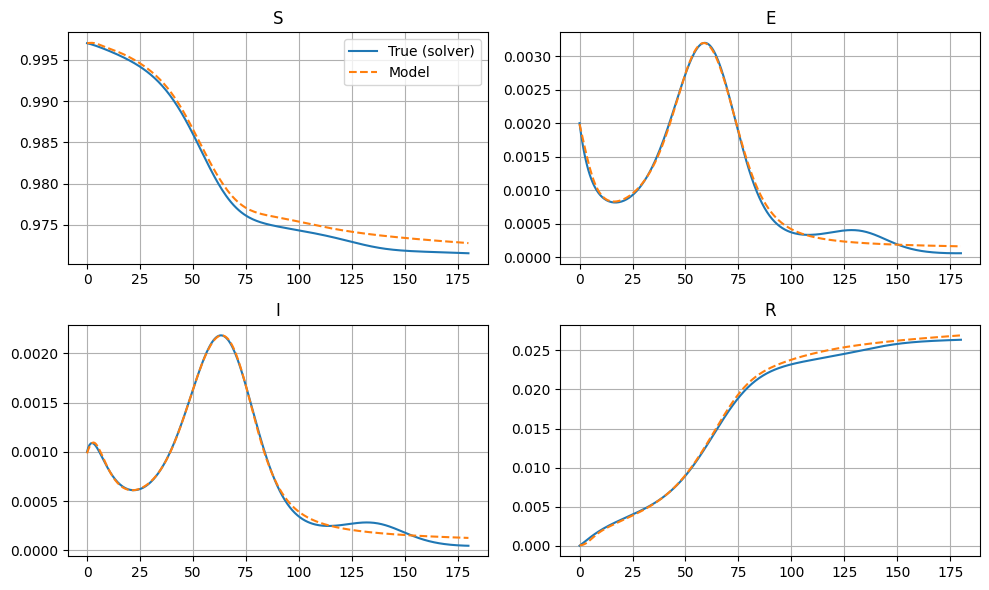

Plotted final comparison and saved to multi_run_results/pred_vs_true_runfinal.pdf


In [ ]:
def plot_predicted_vs_data(params, t_data, data_true, scale_factor, run_id, show=True):
    """
    Plots S,E,I,R: true (solver) vs model prediction.
    Saves a PDF and optionally shows the figure inline.
    """
    pred = fwd(params, jnp.asarray(t_data).reshape(-1,1))
    var_names = ['S', 'E', 'I', 'R']
    fig, axs = plt.subplots(2, 2, figsize=(10,6))
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(t_data, data_true[:, i] * scale_factor[i], label='True (solver)')
        axs[i].plot(t_data, pred[:, i] * scale_factor[i], linestyle='--', label='Model')
        axs[i].set_title(var_names[i]); axs[i].grid(True)
        if i == 0: axs[i].legend()
    plt.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    plt.savefig(f"multi_run_results/pred_vs_true_run{run_id}.pdf")
    if show:
        plt.show()
    else:
        plt.close()
# --- Final visualization for the last trained model ---
# 'trained' contains the params from the last run in the loop above.
plot_predicted_vs_data(trained, t_data, data, max_scl, run_id="final", show=True)
print("Plotted final comparison and saved to multi_run_results/pred_vs_true_runfinal.pdf")


#PIKANs Unknown

In [ ]:
# ============================================
# SEIR (4-state) PINN/KAN with learned beta(t) as 5th output
# ============================================

# --- Imports ---
import os, time, sys
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacrev
from jax.tree_util import tree_flatten
import optax
import matplotlib.pyplot as plt

# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R) + beta_true for inspection
# --------------------------------------------
def generate_seir_data(filename="simulated_data_seir.npz",
                       T=300, t_end=180.0,
                       r=(0.35, 0.25, 0.30, 0.22),
                       tm=(40.0, 120.0, 200.0, 300.0),
                       dm=(30.0, 25.0, 35.0, 28.0)):
    from scipy.integrate import odeint

    t = np.linspace(0.0, t_end, T)                 # (T,)
    t_i = np.array([[t[0]]], dtype=float)          # (1,1) initial-condition time

    # SEIR parameters
    sigma = 1 / 6.57
    gamma = 1 / 5
    delta = 0.015

    r  = np.array(r,  dtype=float)
    tm = np.array(tm, dtype=float)
    dm = np.array(dm, dtype=float)

    def beta_func(tt):
        if np.isscalar(tt):
            return float(np.sum(r * np.exp(-((tt - tm)**2) / (dm**2))))
        tcol = np.asarray(tt).reshape(-1,1)
        return np.sum(r[None,:] * np.exp(-((tcol - tm[None,:])**2) / (dm[None,:]**2)), axis=1)

    def rhs(y, tt):
        S, E, I, R = y
        N = S + E + I + R
        beta = beta_func(tt)
        dS = -beta * S * I / N
        dE =  beta * S * I / N - sigma * E
        dI =  sigma * E - (gamma + delta) * I
        dR =  gamma * I
        return [dS, dE, dI, dR]

    # IC
    N0, I0, E0, R0 = 1.0, 0.001, 0.002, 0.0
    S0 = N0 - I0 - E0 - R0
    y0 = [S0, E0, I0, R0]

    sol = odeint(rhs, y0, t)  # (T,4)
    data = sol.astype(float)
    beta_true = beta_func(t).astype(float)  # (T,)

    # scale factors per state
    max_scl = np.maximum(1.0, np.max(np.abs(data), axis=0))  # (4,)
    IC = np.array([[S0, E0, I0, R0]], dtype=float)           # (1,4)

    np.savez(filename, data=data, t=t, t_i=t_i, IC=IC, max_scl=max_scl, beta_true=beta_true)
    print(f"Saved {filename}: data.shape={data.shape}, max_scl={max_scl}")

# Generate once (comment this out if you already have data)
generate_seir_data()

# --------------------------------------------
# (B) Load data (4 states) + beta_true for plotting
# --------------------------------------------
loaded = np.load("simulated_data_seir.npz")
data      = loaded["data"]        # (T,4) -> S,E,I,R
t_data    = loaded["t"]           # (T,)
t_i       = loaded["t_i"]         # (1,1)
IC        = loaded["IC"]          # (1,4)
max_scl   = loaded["max_scl"]     # (4,)
beta_true = loaded.get("beta_true", None)

# Training times
t_dense = jnp.linspace(0.0, float(t_data[-1]), len(t_data))[:, None]  # (T,1)

# Which variables have data? (choose any subset of 0:S,1:E,2:I,3:R)
x_index = [0,1,2,3]  # Infectious only, e.g. use [0,1,2,3] if you have all

# --------------------------------------------
# (C) KAN model (Chebyshev-based) -> now output 5 dims: [S,E,I,R,beta_raw]
# --------------------------------------------
def init_params_kan(layers, degree, key=jax.random.PRNGKey(1283)):
    keys = jax.random.split(key, len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys[:-1], layers[:-2], layers[1:-1]):
        W = jax.random.normal(key, shape=(n_in, n_out, degree + 1)) / jnp.sqrt(n_in * (degree + 1))
        B = jax.random.normal(key, shape=(n_out,))
        g = jax.random.normal(key, shape=(n_out,))
        params.append({'W': W, 'B': B, 'g': g})
    W = jax.random.normal(keys[-1], shape=(layers[-2], layers[-1])) / jnp.sqrt(layers[-2])
    B = jax.random.normal(keys[-1], shape=(layers[-1],))
    # Ks = {f"K{i+1}": jnp.array(fixed_vals[i]) for i in k_index}
    # Ks = {f"K{i+1}": jnp.array(1.0) for i in k_index}
    params.append({'W': W, 'B': B})
    return params

def chebyshev_recursive(x, degree):
    if degree == 0: return x * 0 + 1
    if degree == 1: return x
    tm2, tm1 = x * 0 + 1, x
    for _ in range(2, degree + 1):
        tn = 2 * x * tm1 - tm2
        tm2, tm1 = tm1, tn
    return tm1

def fwd(params, t, activation=jax.nn.tanh, degree=3):
    t = t / float(t_data[-1])                # normalize time to ~[0,1]
    X = t.reshape((-1, 1))                   # (B,1)
    *hidden, last = params
    for layer in hidden:
        X = activation(X)
        coeffs = layer['W']                  # (in,out,deg+1)
        deg = coeffs.shape[2] - 1
        X_stack = jnp.stack([chebyshev_recursive(X, d) for d in range(deg + 1)], axis=-1)  # (B,in,deg+1)
        X = jnp.einsum("bid,iod->bo", X_stack, coeffs)   # (B,out)
        X = layer['g'] * X + layer['B']
        X = activation(X)
    return jnp.dot(X, last['W']) + last['B']             # (B,5) -> [S,E,I,R,beta_raw]




# --------------------------------------------
# (D) Losses (IC, Data, ODE) with learned beta
# --------------------------------------------
@jax.jit
def MSE(true, pred):  # true/pred: (B,dim) or (1,dim)
    return jnp.mean((true - pred) ** 2)

def ODE_loss(params, t, y_func, max_scl):
    """
    Network outputs y = [S, E, I, R, beta_raw].
    Returns list of 4 residual arrays (one per state): each (T,1,1)
    """
    # Fixed SEIR constants
    sigma = 1 / 6.57
    gamma = 1 / 5
    delta = 0.015

    # Predictions and time-derivatives
    y_vals = jax.vmap(y_func)(t)           # (T,5)
    dy_dt  = jax.vmap(jacrev(y_func))(t)   # (T,5,1)

    # Scale up states before RHS; beta is *not* scaled by max_scl
    S = y_vals[:, 0:1] * max_scl[0]
    E = y_vals[:, 1:2] * max_scl[1]
    I = y_vals[:, 2:3] * max_scl[2]
    R = y_vals[:, 3:4] * max_scl[3]

    # Learned beta(t): ensure nonnegative and avoid crazy explosions
    # beta_raw = y_vals[:, 4:5]
    beta_t = y_vals[:, 4:5]
    # beta_t = jax.nn.softplus(beta_raw)          # >= 0
    # beta_t = jnp.clip(beta_t, 0.0, 3.0)         # optional cap; adjust as needed

    # Safe denominator
    N = S + E + I + R
    N = jnp.clip(N, 1e-8, jnp.inf)

    dS = -beta_t * S * I / N
    dE =  beta_t * S * I / N - sigma * E
    dI =  sigma * E - (gamma + delta) * I
    dR =  gamma * I

    # Scale back to network's scale
    rhs_S = dS / max_scl[0]
    rhs_E = dE / max_scl[1]
    rhs_I = dI / max_scl[2]
    rhs_R = dR / max_scl[3]

    res_S = dy_dt[:, 0:1, :] - rhs_S.reshape(-1,1,1)
    res_E = dy_dt[:, 1:2, :] - rhs_E.reshape(-1,1,1)
    res_I = dy_dt[:, 2:3, :] - rhs_I.reshape(-1,1,1)
    res_R = dy_dt[:, 3:4, :] - rhs_R.reshape(-1,1,1)

    return [res_S, res_E, res_I, res_R]

def loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl):
    # y_func returns 5 outputs, but we compare data/IC using first 4
    y_func = lambda tt: fwd(params, tt.reshape(1,1)).squeeze()  # -> (5,)
    residuals = ODE_loss(params, t_c, y_func, max_scl)
    loss_odes = [lambdas[i] * jnp.mean(res**2) for i, res in enumerate(residuals)]

    # IC loss on S,E,I,R
    pred_IC = fwd(params, t_i)[:, :4]                  # (1,4)
    loss_IC = MSE(jnp.asarray(data_IC), pred_IC)

    # Data loss (only over chosen indices among first 4 states)
    pred_d = fwd(params, t_d)[:, :4]                   # (T,4)
    loss_data = sum(MSE(jnp.asarray(data)[:, i:i+1], pred_d[:, i:i+1]) for i in x_index)

    return loss_IC, loss_data, *loss_odes  # total of 2 + 4 = 6 terms

def loss_fun_total(params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl):
    losses = loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl)
    return sum(w * l for w, l in zip(loss_weight, losses))

# --------------------------------------------
# (E) Training
# --------------------------------------------
def train_model(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl, epochs, loss_weight):
    # # Optional: add gradient clipping to avoid NaNs early on
    # optimizer = optax.chain(
    #     optax.clip_by_global_norm(1.0),
    #     optax.adam(1e-5)
    # )

    # Exponential LR schedule
    schedule = optax.exponential_decay(
        init_value=1e-3,        # initial learning rate
        transition_steps=20000,  # how many steps per decay "tick"
        decay_rate=0.7,         # multiply LR by this every transition_steps
        staircase=False          # True = stepwise, False = smooth
    )

    # Optimizer with gradient clipping + Adam using the schedule
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=schedule)
    )
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fun_total)(
            params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(epochs):
        params, opt_state, loss = update(params, opt_state)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {float(loss):.2e}")
    return params

# --------------------------------------------
# (F) Plotting (states + optional beta)
# --------------------------------------------
def plot_predicted_vs_data(params, t_data, data, scale_factor, run_id):
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1,1))   # (T,5)
    pred = pred_all[:, :4]
    beta_pred = jax.nn.softplus(pred_all[:, 4])                 # (T,)

    var_names = ['S', 'E', 'I', 'R']
    fig, axs = plt.subplots(2, 2, figsize=(10,6), sharex=True)
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(t_data, data[:, i] * scale_factor[i], 'b-', label='True')
        axs[i].plot(t_data, pred[:, i] * scale_factor[i], 'k--', label='Model')
        axs[i].set_title(var_names[i]); axs[i].grid(True)
        if i == 0: axs[i].legend()
    plt.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    plt.savefig(f"pred_vs_true_run{run_id}.pdf")
    plt.close()

    # Optional beta(t) comparison plot if beta_true available
    if beta_true is not None:
        plt.figure(figsize=(10,4))
        plt.plot(t_data, beta_true, label=r"True $\beta(t)$")
        plt.plot(t_data, np.array(beta_pred), '--', label=r"Pred $\beta(t)$")
        plt.xlabel("Time (days)"); plt.ylabel("Transmission rate β(t)")
        plt.title("β(t): true vs predicted")
        plt.grid(True); plt.legend(); plt.tight_layout()
        plt.savefig(f"beta_true_vs_pred_run{run_id}.pdf")
        plt.close()

# --------------------------------------------
# (G) Run training with KAN (output dim = 5)
# --------------------------------------------
layers = [1, 30, 30,30,30, 5]          # 5 outputs: S,E,I,R,beta_raw
loss_weight = [0.1, 0.1] + [1.0]*4   # IC, Data, then 4 ODE residuals

print("\n=== Training with learned beta(t) ===")
key = jax.random.PRNGKey(706)
params = init_params_kan(layers, degree=3, key=key)
lambdas = [1.0] * 4

trained = train_model(
    params, lambdas,
    jnp.asarray(t_i), jnp.asarray(t_dense), jnp.asarray(t_dense),
    jnp.asarray(IC), jnp.asarray(data), jnp.asarray(max_scl),
    epochs=200001, loss_weight=loss_weight
)

# Save params (flatten like before)
flat, _ = tree_flatten(trained)
os.makedirs("multi_run_results", exist_ok=True)
np.savez("multi_run_results/params_run_beta_learned.npz", *[np.array(p) for p in flat])

# Plots
plot_predicted_vs_data(trained, t_data, data, max_scl, run_id="beta_learned")

print("✅ Done. Figures: pred_vs_true_runbeta_learned.pdf and beta_true_vs_pred_runbeta_learned.pdf")


Saved simulated_data_seir.npz: data.shape=(300, 4), max_scl=[1. 1. 1. 1.]

=== Training with learned beta(t) ===
Epoch 0, Loss: 7.48e-01
Epoch 1000, Loss: 4.06e-07
Epoch 2000, Loss: 2.88e-07
Epoch 3000, Loss: 7.76e-06
Epoch 4000, Loss: 2.59e-07
Epoch 5000, Loss: 2.60e-07
Epoch 6000, Loss: 1.78e-07
Epoch 7000, Loss: 1.73e-07
Epoch 8000, Loss: 1.54e-07
Epoch 9000, Loss: 5.50e-05
Epoch 10000, Loss: 3.21e-07
Epoch 11000, Loss: 8.58e-08
Epoch 12000, Loss: 3.16e-08
Epoch 13000, Loss: 1.13e-07
Epoch 14000, Loss: 2.30e-08
Epoch 15000, Loss: 1.87e-08
Epoch 16000, Loss: 2.19e-08
Epoch 17000, Loss: 2.91e-07
Epoch 18000, Loss: 2.38e-07
Epoch 19000, Loss: 1.85e-07
Epoch 20000, Loss: 1.26e-07
Epoch 21000, Loss: 7.33e-08
Epoch 22000, Loss: 2.55e-08
Epoch 23000, Loss: 3.21e-08
Epoch 24000, Loss: 1.56e-06
Epoch 25000, Loss: 5.61e-07
Epoch 26000, Loss: 1.14e-08
Epoch 27000, Loss: 2.72e-08
Epoch 28000, Loss: 9.45e-08
Epoch 29000, Loss: 6.46e-08
Epoch 30000, Loss: 2.53e-08
Epoch 31000, Loss: 4.41e-08
Epoc

In [ ]:
plot_predicted_vs_data(trained, t_data, data, max_scl, run_id)

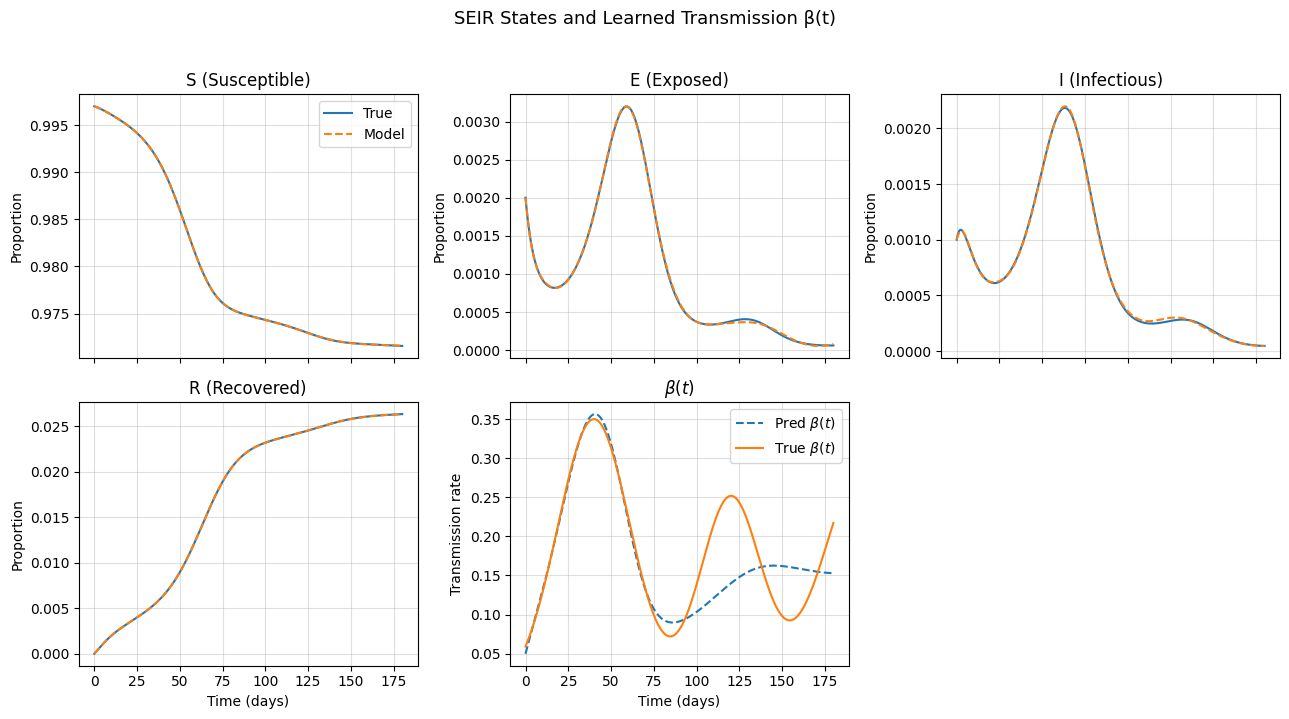

Saved figure: multi_run_results/states_and_beta_beta_learned.pdf


In [ ]:
# --------------------------------------------
# (F) Plotting (S, E, I, R, and beta in one figure)
# --------------------------------------------
def plot_states_and_beta(params, t_data, data, scale_factor, run_id, beta_true=None):
    # Predict all 5 outputs: [S, E, I, R, beta_raw]
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1, 1))  # (T,5)
    pred_states = pred_all[:, :4]                                # (T,4)
    # beta_pred = jax.nn.softplus(pred_all[:, 4])                  # (T,)
    beta_pred = pred_all[:, 4]#jnp.clip(beta_pred, 0.0, 3.0)                    # match ODE cap (optional)

    # Convert to numpy for matplotlib
    t_np = np.asarray(t_data)
    pred_np = np.asarray(pred_states)
    beta_pred_np = np.asarray(beta_pred)

    # 2x3 grid: S, E, I, R, beta, (empty)
    fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharex=True)
    axs = axs.flatten()
    names = ["S (Susceptible)", "E (Exposed)", "I (Infectious)", "R (Recovered)"]

    # Plot S, E, I, R
    for i in range(4):
        axs[i].plot(t_np, data[:, i] * scale_factor[i], label='True', linewidth=1.5)
        axs[i].plot(t_np, pred_np[:, i] * scale_factor[i], '--', label='Model', linewidth=1.5)
        axs[i].set_title(names[i])
        axs[i].set_ylabel("Proportion")
        axs[i].grid(True, alpha=0.4)
        if i == 0:
            axs[i].legend()

    # Plot beta(t)
    axb = axs[4]
    axb.plot(t_np, beta_pred_np, '--', label=r'Pred $\beta(t)$', linewidth=1.5)
    if beta_true is not None:
        axb.plot(t_np, np.asarray(beta_true), label=r'True $\beta(t)$', linewidth=1.5)
    axb.set_title(r"$\beta(t)$")
    axb.set_xlabel("Time (days)")
    axb.set_ylabel("Transmission rate")
    axb.grid(True, alpha=0.4)
    axb.legend()

    # Last panel empty (for clean layout)
    axs[5].axis('off')

    # Shared x-labels
    axs[3].set_xlabel("Time (days)")
    axs[4].set_xlabel("Time (days)")

    fig.suptitle("SEIR States and Learned Transmission β(t)", y=1.02, fontsize=13)
    fig.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    out = f"multi_run_results/states_and_beta_{run_id}.pdf"
    plt.savefig(out)
    plt.show()
    print(f"Saved figure: {out}")


plot_states_and_beta(trained, t_data, data, max_scl, run_id="beta_learned", beta_true=beta_true)


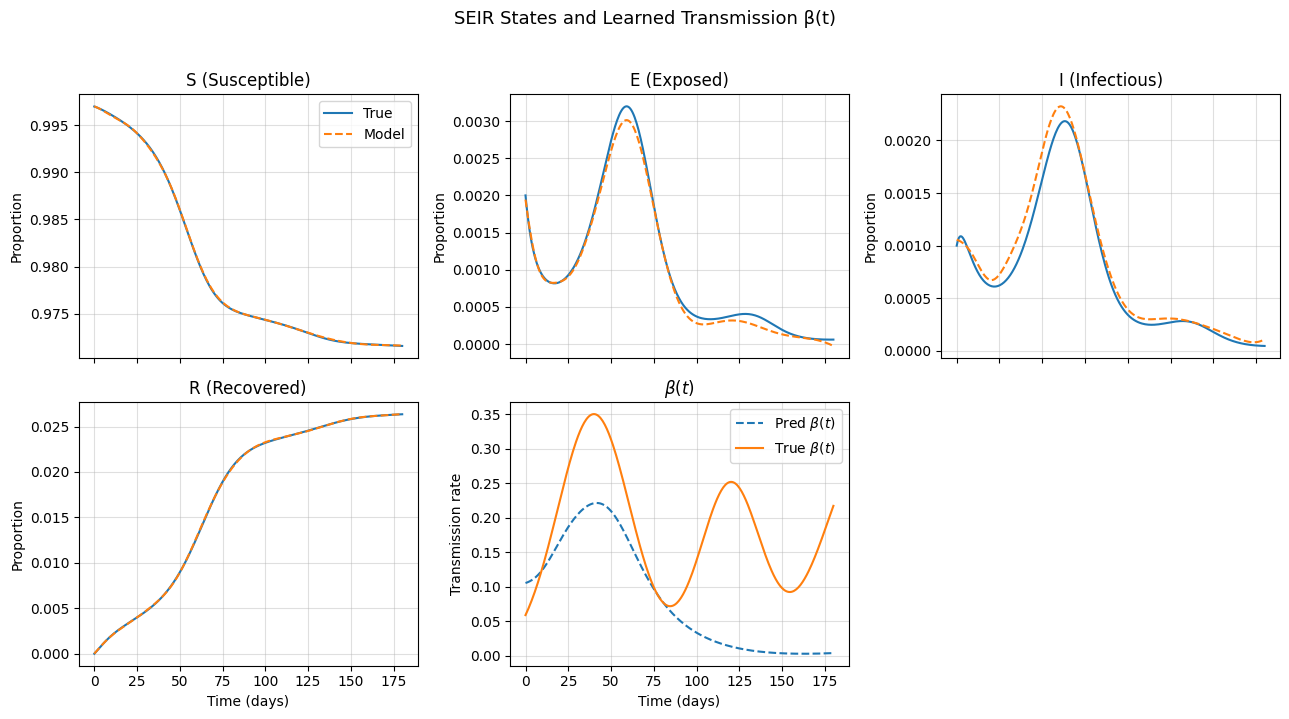

Saved figure: multi_run_results/states_and_beta_beta_learned.pdf


In [ ]:
# --------------------------------------------
# (F) Plotting (S, E, I, R, and beta in one figure)
# --------------------------------------------
def plot_states_and_beta(params, t_data, data, scale_factor, run_id, beta_true=None):
    # Predict all 5 outputs: [S, E, I, R, beta_raw]
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1, 1))  # (T,5)
    pred_states = pred_all[:, :4]                                # (T,4)
    # beta_pred = jax.nn.softplus(pred_all[:, 4])                  # (T,)
    beta_pred = pred_all[:, 4]#jnp.clip(beta_pred, 0.0, 3.0)                    # match ODE cap (optional)

    # Convert to numpy for matplotlib
    t_np = np.asarray(t_data)
    pred_np = np.asarray(pred_states)
    beta_pred_np = np.asarray(beta_pred)

    # 2x3 grid: S, E, I, R, beta, (empty)
    fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharex=True)
    axs = axs.flatten()
    names = ["S (Susceptible)", "E (Exposed)", "I (Infectious)", "R (Recovered)"]

    # Plot S, E, I, R
    for i in range(4):
        axs[i].plot(t_np, data[:, i] * scale_factor[i], label='True', linewidth=1.5)
        axs[i].plot(t_np, pred_np[:, i] * scale_factor[i], '--', label='Model', linewidth=1.5)
        axs[i].set_title(names[i])
        axs[i].set_ylabel("Proportion")
        axs[i].grid(True, alpha=0.4)
        if i == 0:
            axs[i].legend()

    # Plot beta(t)
    axb = axs[4]
    axb.plot(t_np, beta_pred_np, '--', label=r'Pred $\beta(t)$', linewidth=1.5)
    if beta_true is not None:
        axb.plot(t_np, np.asarray(beta_true), label=r'True $\beta(t)$', linewidth=1.5)
    axb.set_title(r"$\beta(t)$")
    axb.set_xlabel("Time (days)")
    axb.set_ylabel("Transmission rate")
    axb.grid(True, alpha=0.4)
    axb.legend()

    # Last panel empty (for clean layout)
    axs[5].axis('off')

    # Shared x-labels
    axs[3].set_xlabel("Time (days)")
    axs[4].set_xlabel("Time (days)")

    fig.suptitle("SEIR States and Learned Transmission β(t)", y=1.02, fontsize=13)
    fig.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    out = f"multi_run_results/states_and_beta_{run_id}.pdf"
    plt.savefig(out)
    plt.show()
    print(f"Saved figure: {out}")


plot_states_and_beta(trained, t_data, data, max_scl, run_id="beta_learned", beta_true=beta_true)


In [ ]:
# --------------------------------------------
# (G) Two-step training with KAN (output dim = 5)
# --------------------------------------------
layers = [1, 30, 30, 30, 30, 5]      # 5 outputs: S,E,I,R,beta_raw
print("\n=== Training with learned beta(t) (two-step) ===")
key = jax.random.PRNGKey(706)
params = init_params_kan(layers, degree=3, key=key)
lambdas = [1.0] * 4                   # keep as before

# ----- Step 1: data-only warmup (10k epochs) -----
# loss weights order assumed: [IC, DATA, RES_S, RES_E, RES_I, RES_R]
loss_weight_step1 = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
epochs_step1 = 10_000

trained_step1 = train_model(
    params, lambdas,
    jnp.asarray(t_i), jnp.asarray(t_dense), jnp.asarray(t_dense),
    jnp.asarray(IC), jnp.asarray(data), jnp.asarray(max_scl),
    epochs=epochs_step1, loss_weight=loss_weight_step1
)

# (optional) save the warm-start params
flat1, _ = tree_flatten(trained_step1)
os.makedirs("multi_run_results", exist_ok=True)
np.savez("multi_run_results/params_run_beta_learned_step1_data_only.npz",
         *[np.array(p) for p in flat1])

# ----- Step 2: enable physics (IC + 4 ODE residuals) -----
# You can tweak these; this mirrors your original intent (IC, Data, then 4 residuals)
loss_weight_step2 = [0.1, 1.0, 1.0, 1.0, 1.0, 1.0]
# keep total ~150k as before -> 150001 - 10000 = 140001
epochs_step2 = 140_001

trained = train_model(
    trained_step1, lambdas,
    jnp.asarray(t_i), jnp.asarray(t_dense), jnp.asarray(t_dense),
    jnp.asarray(IC), jnp.asarray(data), jnp.asarray(max_scl),
    epochs=epochs_step2, loss_weight=loss_weight_step2
)

# Save final params
flat, _ = tree_flatten(trained)
np.savez("multi_run_results/params_run_beta_learned.npz",
         *[np.array(p) for p in flat])

# Plots
plot_predicted_vs_data(trained, t_data, data, max_scl, run_id="beta_learned")

print("✅ Done. Figures: pred_vs_true_runbeta_learned.pdf and beta_true_vs_pred_runbeta_learned.pdf")



=== Training with learned beta(t) (two-step) ===
Epoch 0, Loss: 5.19e+00
Epoch 1000, Loss: 1.12e-05
Epoch 2000, Loss: 2.71e-06
Epoch 3000, Loss: 1.86e-06
Epoch 4000, Loss: 1.34e-06
Epoch 5000, Loss: 9.61e-07
Epoch 6000, Loss: 6.76e-07
Epoch 7000, Loss: 8.95e-07
Epoch 8000, Loss: 4.14e-07
Epoch 9000, Loss: 3.27e-07
Epoch 0, Loss: 6.90e-07
Epoch 1000, Loss: 4.91e-07
Epoch 2000, Loss: 4.44e-07
Epoch 3000, Loss: 5.18e-07
Epoch 4000, Loss: 1.65e-07
Epoch 5000, Loss: 1.45e-06
Epoch 6000, Loss: 1.22e-07
Epoch 7000, Loss: 6.05e-07
Epoch 8000, Loss: 5.45e-07
Epoch 9000, Loss: 8.39e-08
Epoch 10000, Loss: 7.65e-08
Epoch 11000, Loss: 7.57e-08
Epoch 12000, Loss: 8.86e-08
Epoch 13000, Loss: 1.52e-07
Epoch 14000, Loss: 5.48e-08
Epoch 15000, Loss: 7.30e-08
Epoch 16000, Loss: 6.28e-08
Epoch 17000, Loss: 4.33e-08
Epoch 18000, Loss: 6.66e-07
Epoch 19000, Loss: 4.11e-08
Epoch 20000, Loss: 3.55e-08
Epoch 21000, Loss: 4.07e-08
Epoch 22000, Loss: 3.77e-08
Epoch 23000, Loss: 5.09e-08
Epoch 24000, Loss: 3.57e

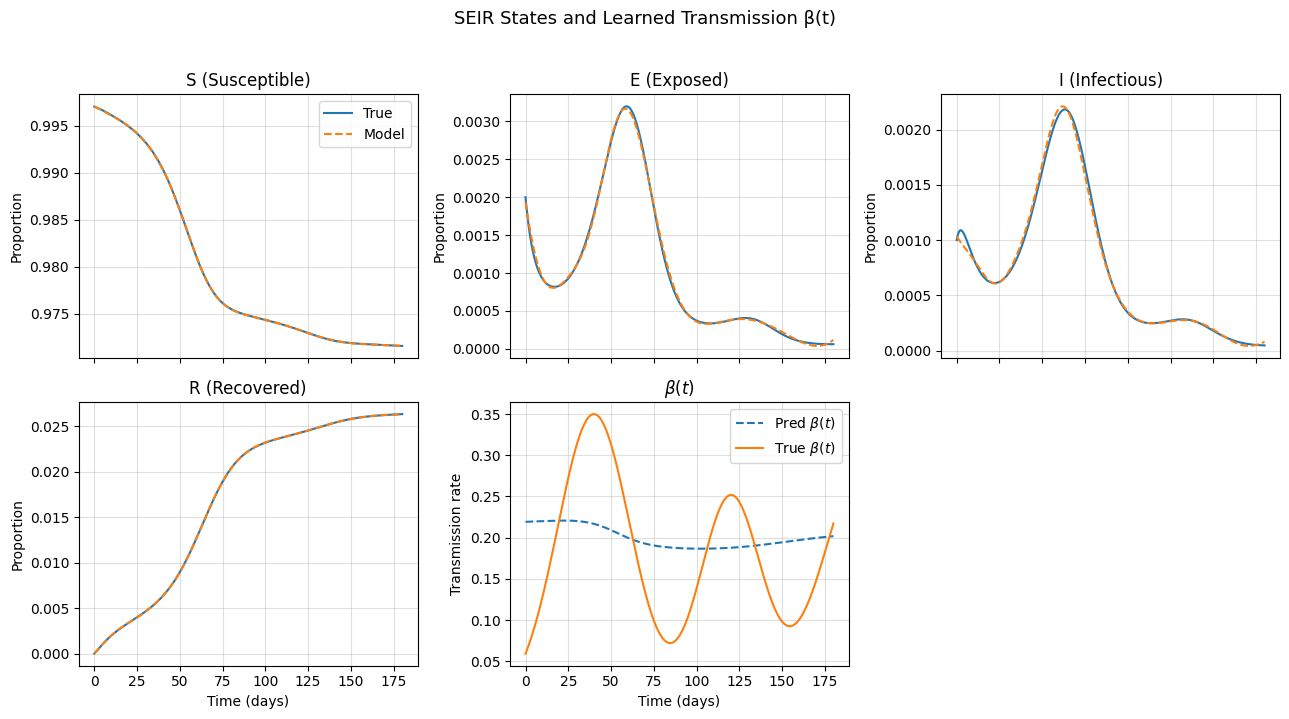

Saved figure: multi_run_results/states_and_beta_beta_learned.pdf


In [ ]:
# --------------------------------------------
# (F) Plotting (S, E, I, R, and beta in one figure)
# --------------------------------------------
def plot_states_and_beta(params, t_data, data, scale_factor, run_id, beta_true=None):
    # Predict all 5 outputs: [S, E, I, R, beta_raw]
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1, 1))  # (T,5)
    pred_states = pred_all[:, :4]                                # (T,4)
    # beta_pred = jax.nn.softplus(pred_all[:, 4])                  # (T,)
    beta_pred = pred_all[:, 4]#jnp.clip(beta_pred, 0.0, 3.0)                    # match ODE cap (optional)

    # Convert to numpy for matplotlib
    t_np = np.asarray(t_data)
    pred_np = np.asarray(pred_states)
    beta_pred_np = np.asarray(beta_pred)

    # 2x3 grid: S, E, I, R, beta, (empty)
    fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharex=True)
    axs = axs.flatten()
    names = ["S (Susceptible)", "E (Exposed)", "I (Infectious)", "R (Recovered)"]

    # Plot S, E, I, R
    for i in range(4):
        axs[i].plot(t_np, data[:, i] * scale_factor[i], label='True', linewidth=1.5)
        axs[i].plot(t_np, pred_np[:, i] * scale_factor[i], '--', label='Model', linewidth=1.5)
        axs[i].set_title(names[i])
        axs[i].set_ylabel("Proportion")
        axs[i].grid(True, alpha=0.4)
        if i == 0:
            axs[i].legend()

    # Plot beta(t)
    axb = axs[4]
    axb.plot(t_np, beta_pred_np, '--', label=r'Pred $\beta(t)$', linewidth=1.5)
    if beta_true is not None:
        axb.plot(t_np, np.asarray(beta_true), label=r'True $\beta(t)$', linewidth=1.5)
    axb.set_title(r"$\beta(t)$")
    axb.set_xlabel("Time (days)")
    axb.set_ylabel("Transmission rate")
    axb.grid(True, alpha=0.4)
    axb.legend()

    # Last panel empty (for clean layout)
    axs[5].axis('off')

    # Shared x-labels
    axs[3].set_xlabel("Time (days)")
    axs[4].set_xlabel("Time (days)")

    fig.suptitle("SEIR States and Learned Transmission β(t)", y=1.02, fontsize=13)
    fig.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    out = f"multi_run_results/states_and_beta_{run_id}.pdf"
    plt.savefig(out)
    plt.show()
    print(f"Saved figure: {out}")


plot_states_and_beta(trained, t_data, data, max_scl, run_id="beta_learned", beta_true=beta_true)


#PIKANs_new + Data of ALL+ unknown Beta

In [ ]:
# ============================================
# SEIR (4-state) PINN/KAN with learned beta(t) as 5th output
# ============================================

# --- Imports ---
import os, time, sys
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacrev
from jax.tree_util import tree_flatten
import optax
import matplotlib.pyplot as plt

# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R) + beta_true for inspection
# --------------------------------------------
# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R) + beta_true + Rt
# --------------------------------------------
def generate_seir_data(filename="simulated_data_seir.npz",
                       T=300, t_end=300.0,
                       r=(0.4, 0.7),          # two Gaussian pulses (stronger 2nd wave)
                       tm=(40.0, 225.0),      # centers of the pulses
                       dm=(30.0, 50.0)):      # widths of the pulses
    from scipy.integrate import odeint

    t = np.linspace(0.0, t_end, T)                 # (T,)
    t_i = np.array([[t[0]]], dtype=float)          # (1,1)

    # SEIR constants
    sigma   = 1 / 6.57
    gamma   = 1 / 5
    delta   = 0.015
    omega_n = 1 / 180.0   # natural immunity waning rate

    r  = np.array(r,  dtype=float)
    tm = np.array(tm, dtype=float)
    dm = np.array(dm, dtype=float)

    beta0 = 0.7   # baseline β
    def beta_func(tt):
        if np.isscalar(tt):
            return float(beta0 + np.sum(r * np.exp(-((tt - tm)**2) / (dm**2))))
        tcol = np.asarray(tt).reshape(-1,1)
        return beta0 + np.sum(
            r[None,:] * np.exp(-((tcol - tm[None,:])**2) / (dm[None,:]**2)),
            axis=1
        )

    def rhs(y, tt):
        S, E, I, R = y
        N = S + E + I + R
        beta = beta_func(tt)
        dS = -beta * S * I / N + omega_n * R
        dE =  beta * S * I / N - sigma * E
        dI =  sigma * E - (gamma + delta) * I
        dR =  gamma * I - omega_n * R
        return [dS, dE, dI, dR]

    # IC (close to disease-free)
    N0, E0, I0, R0 = 1.0, 0.001, 0.0005, 0.0
    S0 = N0 - E0 - I0 - R0
    y0 = [S0, E0, I0, R0]

    sol = odeint(rhs, y0, t).astype(float)  # (T,4)
    data = sol
    beta_true = beta_func(t).astype(float)  # (T,)

    # Effective reproduction number Rt
    S = data[:, 0]
    N = np.sum(data, axis=1)
    Rt = (beta_true / (gamma + delta)) * (S / N)

    # Per-state scale factors (kept for PINN scaling)
    max_scl = np.maximum(1.0, np.max(np.abs(data), axis=0))  # (4,)
    IC = np.array([[S0, E0, I0, R0]], dtype=float)           # (1,4)

    np.savez(
        filename,
        data=data, t=t, t_i=t_i, IC=IC, max_scl=max_scl,
        beta_true=beta_true, Rt=Rt
    )
    print(f"Saved {filename}: data.shape={data.shape}, max_scl={max_scl}")

# Generate once (comment this out if you already have data)
generate_seir_data()

# --------------------------------------------
# (B) Load data (4 states) + beta_true for plotting
# --------------------------------------------
loaded = np.load("simulated_data_seir.npz")
data      = loaded["data"]        # (T,4) -> S,E,I,R
t_data    = loaded["t"]           # (T,)
t_i       = loaded["t_i"]         # (1,1)
IC        = loaded["IC"]          # (1,4)
max_scl   = loaded["max_scl"]     # (4,)
beta_true = loaded.get("beta_true", None)

# Training times
t_dense = jnp.linspace(0.0, float(t_data[-1]), len(t_data))[:, None]  # (T,1)

# Which variables have data? (choose any subset of 0:S,1:E,2:I,3:R)
x_index = [0,1,2,3]  # Infectious only, e.g. use [0,1,2,3] if you have all

# --------------------------------------------
# (C) KAN model (Chebyshev-based) -> now output 5 dims: [S,E,I,R,beta_raw]
# --------------------------------------------
def init_params_kan(layers, degree, key=jax.random.PRNGKey(1283)):
    keys = jax.random.split(key, len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys[:-1], layers[:-2], layers[1:-1]):
        W = jax.random.normal(key, shape=(n_in, n_out, degree + 1)) / jnp.sqrt(n_in * (degree + 1))
        B = jax.random.normal(key, shape=(n_out,))
        g = jax.random.normal(key, shape=(n_out,))
        params.append({'W': W, 'B': B, 'g': g})
    W = jax.random.normal(keys[-1], shape=(layers[-2], layers[-1])) / jnp.sqrt(layers[-2])
    B = jax.random.normal(keys[-1], shape=(layers[-1],))
    # Ks = {f"K{i+1}": jnp.array(fixed_vals[i]) for i in k_index}
    # Ks = {f"K{i+1}": jnp.array(1.0) for i in k_index}
    params.append({'W': W, 'B': B})
    return params

def chebyshev_recursive(x, degree):
    if degree == 0: return x * 0 + 1
    if degree == 1: return x
    tm2, tm1 = x * 0 + 1, x
    for _ in range(2, degree + 1):
        tn = 2 * x * tm1 - tm2
        tm2, tm1 = tm1, tn
    return tm1

def fwd(params, t, activation=jax.nn.tanh, degree=3):
    t = t / float(t_data[-1])                # normalize time to ~[0,1]
    X = t.reshape((-1, 1))                   # (B,1)
    *hidden, last = params
    for layer in hidden:
        X = activation(X)
        coeffs = layer['W']                  # (in,out,deg+1)
        deg = coeffs.shape[2] - 1
        X_stack = jnp.stack([chebyshev_recursive(X, d) for d in range(deg + 1)], axis=-1)  # (B,in,deg+1)
        X = jnp.einsum("bid,iod->bo", X_stack, coeffs)   # (B,out)
        X = layer['g'] * X + layer['B']
        X = activation(X)
    return jnp.dot(X, last['W']) + last['B']             # (B,5) -> [S,E,I,R,beta_raw]




# --------------------------------------------
# (D) Losses (IC, Data, ODE) with learned beta
# --------------------------------------------
@jax.jit
def MSE(true, pred):  # true/pred: (B,dim) or (1,dim)
    return jnp.mean((true - pred) ** 2)

def ODE_loss(params, t, y_func, max_scl):
    """
    Network outputs y = [S, E, I, R, beta_raw].
    Returns list of 4 residual arrays (one per state): each (T,1,1)
    """
    # Constants
    sigma   = 1 / 6.57
    gamma   = 1 / 5
    delta   = 0.015
    omega_n = 1 / 180.0

    # Predictions and time-derivatives
    y_vals = jax.vmap(y_func)(t)         # (T,5)
    dy_dt  = jax.vmap(jacrev(y_func))(t) # (T,5,1)

    # Unscale states for RHS calc
    S = y_vals[:, 0:1] * max_scl[0]
    E = y_vals[:, 1:2] * max_scl[1]
    I = y_vals[:, 2:3] * max_scl[2]
    R = y_vals[:, 3:4] * max_scl[3]

    # Learned β(t) (nonnegative)
    beta_t = jax.nn.softplus(y_vals[:, 4:5])
    # beta_t = jnp.clip(beta_t, 0.0, 3.0)  # optional cap if needed

    N = jnp.clip(S + E + I + R, 1e-8, jnp.inf)

    # SEIR with immunity waning (model-file version)
    dS = -beta_t * S * I / N + omega_n * R
    dE =  beta_t * S * I / N - sigma * E
    dI =  sigma * E - (gamma + delta) * I
    dR =  gamma * I - omega_n * R

    # Scale back to network scale
    rhs_S = dS / max_scl[0]
    rhs_E = dE / max_scl[1]
    rhs_I = dI / max_scl[2]
    rhs_R = dR / max_scl[3]

    res_S = dy_dt[:, 0:1, :] - rhs_S.reshape(-1,1,1)
    res_E = dy_dt[:, 1:2, :] - rhs_E.reshape(-1,1,1)
    res_I = dy_dt[:, 2:3, :] - rhs_I.reshape(-1,1,1)
    res_R = dy_dt[:, 3:4, :] - rhs_R.reshape(-1,1,1)

    return [res_S, res_E, res_I, res_R]


def loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl):
    # y_func returns 5 outputs, but we compare data/IC using first 4
    y_func = lambda tt: fwd(params, tt.reshape(1,1)).squeeze()  # -> (5,)
    residuals = ODE_loss(params, t_c, y_func, max_scl)
    loss_odes = [lambdas[i] * jnp.mean(res**2) for i, res in enumerate(residuals)]

    # IC loss on S,E,I,R
    pred_IC = fwd(params, t_i)[:, :4]                  # (1,4)
    loss_IC = MSE(jnp.asarray(data_IC), pred_IC)

    # Data loss (only over chosen indices among first 4 states)
    pred_d = fwd(params, t_d)[:, :4]                   # (T,4)
    loss_data = sum(MSE(jnp.asarray(data)[:, i:i+1], pred_d[:, i:i+1]) for i in x_index)

    return loss_IC, loss_data, *loss_odes  # total of 2 + 4 = 6 terms

def loss_fun_total(params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl):
    losses = loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl)
    return sum(w * l for w, l in zip(loss_weight, losses))

# --------------------------------------------
# (E) Training
# --------------------------------------------
def train_model(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl, epochs, loss_weight):
    # # Optional: add gradient clipping to avoid NaNs early on
    # optimizer = optax.chain(
    #     optax.clip_by_global_norm(1.0),
    #     optax.adam(1e-5)
    # )

    # Exponential LR schedule
    schedule = optax.exponential_decay(
        init_value=1e-3,        # initial learning rate
        transition_steps=20000,  # how many steps per decay "tick"
        decay_rate=0.7,         # multiply LR by this every transition_steps
        staircase=False          # True = stepwise, False = smooth
    )

    # Optimizer with gradient clipping + Adam using the schedule
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=schedule)
    )
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fun_total)(
            params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(epochs):
        params, opt_state, loss = update(params, opt_state)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {float(loss):.2e}")
    return params

# --------------------------------------------
# (F) Plotting (states + optional beta)
# --------------------------------------------
def plot_predicted_vs_data(params, t_data, data, scale_factor, run_id):
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1,1))   # (T,5)
    pred = pred_all[:, :4]
    beta_pred = jax.nn.softplus(pred_all[:, 4])                 # (T,)

    var_names = ['S', 'E', 'I', 'R']
    fig, axs = plt.subplots(2, 2, figsize=(10,6), sharex=True)
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(t_data, data[:, i] * scale_factor[i], 'b-', label='True')
        axs[i].plot(t_data, pred[:, i] * scale_factor[i], 'k--', label='Model')
        axs[i].set_title(var_names[i]); axs[i].grid(True)
        if i == 0: axs[i].legend()
    plt.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    plt.savefig(f"pred_vs_true_run{run_id}.pdf")
    plt.close()

    # Optional beta(t) comparison plot if beta_true available
    if beta_true is not None:
        plt.figure(figsize=(10,4))
        plt.plot(t_data, beta_true, label=r"True $\beta(t)$")
        plt.plot(t_data, np.array(beta_pred), '--', label=r"Pred $\beta(t)$")
        plt.xlabel("Time (days)"); plt.ylabel("Transmission rate β(t)")
        plt.title("β(t): true vs predicted")
        plt.grid(True); plt.legend(); plt.tight_layout()
        plt.savefig(f"beta_true_vs_pred_run{run_id}.pdf")
        plt.close()

# --------------------------------------------
# (G) Run training with KAN (output dim = 5)
# --------------------------------------------
layers = [1, 30, 30,30,30, 5]          # 5 outputs: S,E,I,R,beta_raw
loss_weight = [0.1, 0.1] + [1.0]*4   # IC, Data, then 4 ODE residuals

print("\n=== Training with learned beta(t) ===")
key = jax.random.PRNGKey(706)
params = init_params_kan(layers, degree=3, key=key)
lambdas = [1.0] * 4

trained = train_model(
    params, lambdas,
    jnp.asarray(t_i), jnp.asarray(t_dense), jnp.asarray(t_dense),
    jnp.asarray(IC), jnp.asarray(data), jnp.asarray(max_scl),
    epochs=200001, loss_weight=loss_weight
)

# Save params (flatten like before)
flat, _ = tree_flatten(trained)
os.makedirs("multi_run_results", exist_ok=True)
np.savez("multi_run_results/params_run_beta_learned.npz", *[np.array(p) for p in flat])

# Plots
plot_predicted_vs_data(trained, t_data, data, max_scl, run_id="beta_learned")

print("✅ Done. Figures: pred_vs_true_runbeta_learned.pdf and beta_true_vs_pred_runbeta_learned.pdf")


Saved simulated_data_seir.npz: data.shape=(300, 4), max_scl=[1. 1. 1. 1.]

=== Training with learned beta(t) ===
Epoch 0, Loss: 5.11e-01
Epoch 1000, Loss: 4.26e-05
Epoch 2000, Loss: 1.24e-04
Epoch 3000, Loss: 4.44e-05
Epoch 4000, Loss: 2.63e-06
Epoch 5000, Loss: 1.04e-05
Epoch 6000, Loss: 5.44e-05
Epoch 7000, Loss: 8.10e-07
Epoch 8000, Loss: 6.09e-07
Epoch 9000, Loss: 1.34e-06
Epoch 10000, Loss: 4.19e-07
Epoch 11000, Loss: 3.94e-07
Epoch 12000, Loss: 3.74e-07
Epoch 13000, Loss: 2.87e-07
Epoch 14000, Loss: 8.51e-07
Epoch 15000, Loss: 2.89e-07
Epoch 16000, Loss: 4.89e-07
Epoch 17000, Loss: 1.65e-06
Epoch 18000, Loss: 2.89e-06
Epoch 19000, Loss: 3.36e-07
Epoch 20000, Loss: 6.67e-07
Epoch 21000, Loss: 3.79e-07
Epoch 22000, Loss: 3.95e-06
Epoch 23000, Loss: 3.38e-07
Epoch 24000, Loss: 2.32e-07
Epoch 25000, Loss: 3.90e-07
Epoch 26000, Loss: 3.65e-07
Epoch 27000, Loss: 6.26e-07
Epoch 28000, Loss: 7.08e-07
Epoch 29000, Loss: 1.25e-07
Epoch 30000, Loss: 1.00e-07
Epoch 31000, Loss: 4.95e-07
Epoc

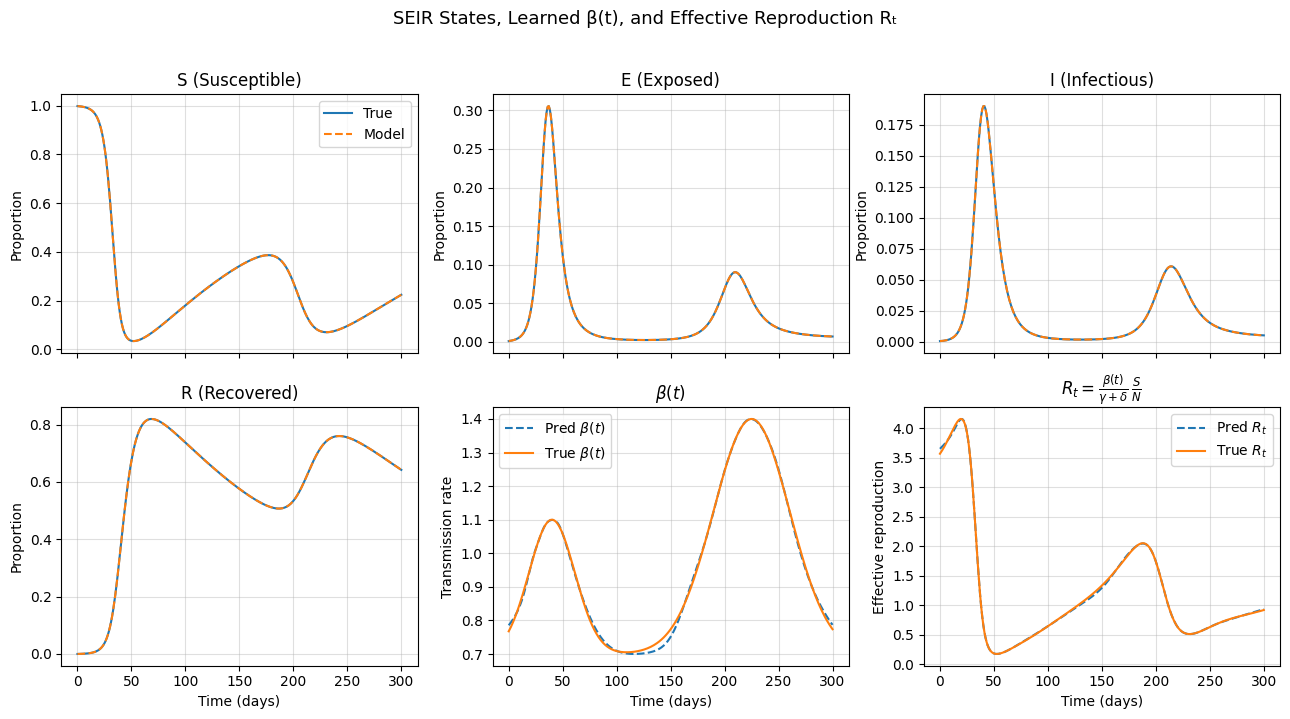

Saved figure: multi_run_results/states_beta_rt_beta_learned.pdf


In [ ]:
# --------------------------------------------
# (F) Plotting (S, E, I, R, and beta in one figure)
# --------------------------------------------
# --------------------------------------------
# (F) Plotting (S, E, I, R, beta, and Rt)
# --------------------------------------------
def plot_states_and_beta(params, t_data, data, scale_factor, run_id, beta_true=None):
    # SEIR constants used in both data gen and PINN ODEs
    gamma = 1 / 5.0
    delta = 0.015

    # Predict all 5 outputs: [S, E, I, R, beta_raw]
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1, 1))  # (T,5)
    beta_pred = jax.nn.softplus(pred_all[:, 4])                 # (T,)

    # Convert to numpy for matplotlib
    t_np = np.asarray(t_data)
    pred_np = np.asarray(pred_all)                              # (T,5)
    beta_pred_np = np.asarray(beta_pred)                        # (T,)

    # Prepare scaled states (real scale) for TRUE and PRED
    sf = np.asarray(scale_factor).reshape(1, -1)                # (1,4) for broadcasting
    true_states = np.asarray(data) * sf                         # (T,4)
    pred_states = pred_np[:, :4] * sf                           # (T,4)

    # Compute Rt (predicted)
    S_pred = pred_states[:, 0]
    N_pred = np.clip(np.sum(pred_states, axis=1), 1e-12, np.inf)
    Rt_pred = (beta_pred_np / (gamma + delta)) * (S_pred / N_pred)

    # Compute Rt (true) if beta_true available
    Rt_true = None
    if beta_true is not None:
        S_true = true_states[:, 0]
        N_true = np.clip(np.sum(true_states, axis=1), 1e-12, np.inf)
        Rt_true = (np.asarray(beta_true) / (gamma + delta)) * (S_true / N_true)

    # 2x3 grid: S, E, I, R, beta, Rt
    fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharex=True)
    axs = axs.flatten()
    names = ["S (Susceptible)", "E (Exposed)", "I (Infectious)", "R (Recovered)"]

    # Plot S, E, I, R
    for i in range(4):
        axs[i].plot(t_np, true_states[:, i], label='True', linewidth=1.5)
        axs[i].plot(t_np, pred_states[:, i], '--', label='Model', linewidth=1.5)
        axs[i].set_title(names[i])
        axs[i].set_ylabel("Proportion")
        axs[i].grid(True, alpha=0.4)
        if i == 0:
            axs[i].legend()

    # Plot beta(t)
    axb = axs[4]
    axb.plot(t_np, beta_pred_np, '--', label=r'Pred $\beta(t)$', linewidth=1.5)
    if beta_true is not None:
        axb.plot(t_np, np.asarray(beta_true), label=r'True $\beta(t)$', linewidth=1.5)
    axb.set_title(r"$\beta(t)$")
    axb.set_xlabel("Time (days)")
    axb.set_ylabel("Transmission rate")
    axb.grid(True, alpha=0.4)
    axb.legend()

    # Plot Rt
    axr = axs[5]
    axr.plot(t_np, Rt_pred, '--', label=r'Pred $R_t$', linewidth=1.5)
    if Rt_true is not None:
        axr.plot(t_np, Rt_true, label=r'True $R_t$', linewidth=1.5)
    axr.set_title(r"$R_t = \frac{\beta(t)}{\gamma+\delta}\,\frac{S}{N}$")
    axr.set_xlabel("Time (days)")
    axr.set_ylabel("Effective reproduction")
    axr.grid(True, alpha=0.4)
    axr.legend()

    # Shared x-labels
    axs[3].set_xlabel("Time (days)")

    fig.suptitle("SEIR States, Learned β(t), and Effective Reproduction Rₜ", y=1.02, fontsize=13)
    fig.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    out = f"multi_run_results/states_beta_rt_{run_id}.pdf"
    plt.savefig(out)
    plt.show()
    print(f"Saved figure: {out}")


plot_states_and_beta(trained, t_data, data, max_scl, run_id="beta_learned", beta_true=beta_true)


#PIKANs_new + Data of I + unknown Beta

In [ ]:
# ============================================
# SEIR (4-state) PINN/KAN with learned beta(t) as 5th output
# ============================================

# --- Imports ---
import os, time, sys
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacrev
from jax.tree_util import tree_flatten
import optax
import matplotlib.pyplot as plt

# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R) + beta_true for inspection
# --------------------------------------------
# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R) + beta_true + Rt
# --------------------------------------------
def generate_seir_data(filename="simulated_data_seir.npz",
                       T=300, t_end=300.0,
                       r=(0.4, 0.7),          # two Gaussian pulses (stronger 2nd wave)
                       tm=(40.0, 225.0),      # centers of the pulses
                       dm=(30.0, 50.0)):      # widths of the pulses
    from scipy.integrate import odeint

    t = np.linspace(0.0, t_end, T)                 # (T,)
    t_i = np.array([[t[0]]], dtype=float)          # (1,1)

    # SEIR constants
    sigma   = 1 / 6.57
    gamma   = 1 / 5
    delta   = 0.015
    omega_n = 1 / 180.0   # natural immunity waning rate

    r  = np.array(r,  dtype=float)
    tm = np.array(tm, dtype=float)
    dm = np.array(dm, dtype=float)

    beta0 = 0.7   # baseline β
    def beta_func(tt):
        if np.isscalar(tt):
            return float(beta0 + np.sum(r * np.exp(-((tt - tm)**2) / (dm**2))))
        tcol = np.asarray(tt).reshape(-1,1)
        return beta0 + np.sum(
            r[None,:] * np.exp(-((tcol - tm[None,:])**2) / (dm[None,:]**2)),
            axis=1
        )

    def rhs(y, tt):
        S, E, I, R = y
        N = S + E + I + R
        beta = beta_func(tt)
        dS = -beta * S * I / N + omega_n * R
        dE =  beta * S * I / N - sigma * E
        dI =  sigma * E - (gamma + delta) * I
        dR =  gamma * I - omega_n * R
        return [dS, dE, dI, dR]

    # IC (close to disease-free)
    N0, E0, I0, R0 = 1.0, 0.001, 0.0005, 0.0
    S0 = N0 - E0 - I0 - R0
    y0 = [S0, E0, I0, R0]

    sol = odeint(rhs, y0, t).astype(float)  # (T,4)
    data = sol
    beta_true = beta_func(t).astype(float)  # (T,)

    # Effective reproduction number Rt
    S = data[:, 0]
    N = np.sum(data, axis=1)
    Rt = (beta_true / (gamma + delta)) * (S / N)

    # Per-state scale factors (kept for PINN scaling)
    max_scl = np.maximum(1.0, np.max(np.abs(data), axis=0))  # (4,)
    IC = np.array([[S0, E0, I0, R0]], dtype=float)           # (1,4)

    np.savez(
        filename,
        data=data, t=t, t_i=t_i, IC=IC, max_scl=max_scl,
        beta_true=beta_true, Rt=Rt
    )
    print(f"Saved {filename}: data.shape={data.shape}, max_scl={max_scl}")

# Generate once (comment this out if you already have data)
generate_seir_data()

# --------------------------------------------
# (B) Load data (4 states) + beta_true for plotting
# --------------------------------------------
loaded = np.load("simulated_data_seir.npz")
data      = loaded["data"]        # (T,4) -> S,E,I,R
t_data    = loaded["t"]           # (T,)
t_i       = loaded["t_i"]         # (1,1)
IC        = loaded["IC"]          # (1,4)
max_scl   = loaded["max_scl"]     # (4,)
beta_true = loaded.get("beta_true", None)

# Training times
t_dense = jnp.linspace(0.0, float(t_data[-1]), len(t_data))[:, None]  # (T,1)

# Which variables have data? (choose any subset of 0:S,1:E,2:I,3:R)
x_index = [2]  # Infectious only, e.g. use [0,1,2,3] if you have all

# --------------------------------------------
# (C) KAN model (Chebyshev-based) -> now output 5 dims: [S,E,I,R,beta_raw]
# --------------------------------------------
def init_params_kan(layers, degree, key=jax.random.PRNGKey(1283)):
    keys = jax.random.split(key, len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys[:-1], layers[:-2], layers[1:-1]):
        W = jax.random.normal(key, shape=(n_in, n_out, degree + 1)) / jnp.sqrt(n_in * (degree + 1))
        B = jax.random.normal(key, shape=(n_out,))
        g = jax.random.normal(key, shape=(n_out,))
        params.append({'W': W, 'B': B, 'g': g})
    W = jax.random.normal(keys[-1], shape=(layers[-2], layers[-1])) / jnp.sqrt(layers[-2])
    B = jax.random.normal(keys[-1], shape=(layers[-1],))
    # Ks = {f"K{i+1}": jnp.array(fixed_vals[i]) for i in k_index}
    # Ks = {f"K{i+1}": jnp.array(1.0) for i in k_index}
    params.append({'W': W, 'B': B})
    return params

def chebyshev_recursive(x, degree):
    if degree == 0: return x * 0 + 1
    if degree == 1: return x
    tm2, tm1 = x * 0 + 1, x
    for _ in range(2, degree + 1):
        tn = 2 * x * tm1 - tm2
        tm2, tm1 = tm1, tn
    return tm1

def fwd(params, t, activation=jax.nn.tanh, degree=3):
    t = t / float(t_data[-1])                # normalize time to ~[0,1]
    X = t.reshape((-1, 1))                   # (B,1)
    *hidden, last = params
    for layer in hidden:
        X = activation(X)
        coeffs = layer['W']                  # (in,out,deg+1)
        deg = coeffs.shape[2] - 1
        X_stack = jnp.stack([chebyshev_recursive(X, d) for d in range(deg + 1)], axis=-1)  # (B,in,deg+1)
        X = jnp.einsum("bid,iod->bo", X_stack, coeffs)   # (B,out)
        X = layer['g'] * X + layer['B']
        X = activation(X)
    return jnp.dot(X, last['W']) + last['B']             # (B,5) -> [S,E,I,R,beta_raw]




# --------------------------------------------
# (D) Losses (IC, Data, ODE) with learned beta
# --------------------------------------------
@jax.jit
def MSE(true, pred):  # true/pred: (B,dim) or (1,dim)
    return jnp.mean((true - pred) ** 2)

def ODE_loss(params, t, y_func, max_scl):
    """
    Network outputs y = [S, E, I, R, beta_raw].
    Returns list of 4 residual arrays (one per state): each (T,1,1)
    """
    # Constants
    sigma   = 1 / 6.57
    gamma   = 1 / 5
    delta   = 0.015
    omega_n = 1 / 180.0

    # Predictions and time-derivatives
    y_vals = jax.vmap(y_func)(t)         # (T,5)
    dy_dt  = jax.vmap(jacrev(y_func))(t) # (T,5,1)

    # Unscale states for RHS calc
    S = y_vals[:, 0:1] * max_scl[0]
    E = y_vals[:, 1:2] * max_scl[1]
    I = y_vals[:, 2:3] * max_scl[2]
    R = y_vals[:, 3:4] * max_scl[3]

    # Learned β(t) (nonnegative)
    beta_t = jax.nn.softplus(y_vals[:, 4:5])
    # beta_t = jnp.clip(beta_t, 0.0, 3.0)  # optional cap if needed

    N = jnp.clip(S + E + I + R, 1e-8, jnp.inf)

    # SEIR with immunity waning (model-file version)
    dS = -beta_t * S * I / N + omega_n * R
    dE =  beta_t * S * I / N - sigma * E
    dI =  sigma * E - (gamma + delta) * I
    dR =  gamma * I - omega_n * R

    # Scale back to network scale
    rhs_S = dS / max_scl[0]
    rhs_E = dE / max_scl[1]
    rhs_I = dI / max_scl[2]
    rhs_R = dR / max_scl[3]

    res_S = dy_dt[:, 0:1, :] - rhs_S.reshape(-1,1,1)
    res_E = dy_dt[:, 1:2, :] - rhs_E.reshape(-1,1,1)
    res_I = dy_dt[:, 2:3, :] - rhs_I.reshape(-1,1,1)
    res_R = dy_dt[:, 3:4, :] - rhs_R.reshape(-1,1,1)

    return [res_S, res_E, res_I, res_R]


def loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl):
    # y_func returns 5 outputs, but we compare data/IC using first 4
    y_func = lambda tt: fwd(params, tt.reshape(1,1)).squeeze()  # -> (5,)
    residuals = ODE_loss(params, t_c, y_func, max_scl)
    loss_odes = [lambdas[i] * jnp.mean(res**2) for i, res in enumerate(residuals)]

    # IC loss on S,E,I,R
    pred_IC = fwd(params, t_i)[:, :4]                  # (1,4)
    loss_IC = MSE(jnp.asarray(data_IC), pred_IC)

    # Data loss (only over chosen indices among first 4 states)
    pred_d = fwd(params, t_d)[:, :4]                   # (T,4)
    loss_data = sum(MSE(jnp.asarray(data)[:, i:i+1], pred_d[:, i:i+1]) for i in x_index)

    return loss_IC, loss_data, *loss_odes  # total of 2 + 4 = 6 terms

def loss_fun_total(params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl):
    losses = loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl)
    return sum(w * l for w, l in zip(loss_weight, losses))

# --------------------------------------------
# (E) Training
# --------------------------------------------
def train_model(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl, epochs, loss_weight):
    # # Optional: add gradient clipping to avoid NaNs early on
    # optimizer = optax.chain(
    #     optax.clip_by_global_norm(1.0),
    #     optax.adam(1e-5)
    # )

    # Exponential LR schedule
    schedule = optax.exponential_decay(
        init_value=1e-3,        # initial learning rate
        transition_steps=20000,  # how many steps per decay "tick"
        decay_rate=0.7,         # multiply LR by this every transition_steps
        staircase=False          # True = stepwise, False = smooth
    )

    # Optimizer with gradient clipping + Adam using the schedule
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=schedule)
    )
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fun_total)(
            params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(epochs):
        params, opt_state, loss = update(params, opt_state)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {float(loss):.2e}")
    return params

# --------------------------------------------
# (F) Plotting (states + optional beta)
# --------------------------------------------
def plot_predicted_vs_data(params, t_data, data, scale_factor, run_id):
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1,1))   # (T,5)
    pred = pred_all[:, :4]
    beta_pred = jax.nn.softplus(pred_all[:, 4])                 # (T,)

    var_names = ['S', 'E', 'I', 'R']
    fig, axs = plt.subplots(2, 2, figsize=(10,6), sharex=True)
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(t_data, data[:, i] * scale_factor[i], 'b-', label='True')
        axs[i].plot(t_data, pred[:, i] * scale_factor[i], 'k--', label='Model')
        axs[i].set_title(var_names[i]); axs[i].grid(True)
        if i == 0: axs[i].legend()
    plt.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    plt.savefig(f"pred_vs_true_run{run_id}.pdf")
    plt.close()

    # Optional beta(t) comparison plot if beta_true available
    if beta_true is not None:
        plt.figure(figsize=(10,4))
        plt.plot(t_data, beta_true, label=r"True $\beta(t)$")
        plt.plot(t_data, np.array(beta_pred), '--', label=r"Pred $\beta(t)$")
        plt.xlabel("Time (days)"); plt.ylabel("Transmission rate β(t)")
        plt.title("β(t): true vs predicted")
        plt.grid(True); plt.legend(); plt.tight_layout()
        plt.savefig(f"beta_true_vs_pred_run{run_id}.pdf")
        plt.close()

# --------------------------------------------
# (G) Run training with KAN (output dim = 5)
# --------------------------------------------
layers = [1, 30, 30,30,30, 5]          # 5 outputs: S,E,I,R,beta_raw
loss_weight = [0.1, 0.1] + [1.0]*4   # IC, Data, then 4 ODE residuals

print("\n=== Training with learned beta(t) ===")
key = jax.random.PRNGKey(706)
params = init_params_kan(layers, degree=3, key=key)
lambdas = [1.0] * 4

trained = train_model(
    params, lambdas,
    jnp.asarray(t_i), jnp.asarray(t_dense), jnp.asarray(t_dense),
    jnp.asarray(IC), jnp.asarray(data), jnp.asarray(max_scl),
    epochs=200001, loss_weight=loss_weight
)

# Save params (flatten like before)
flat, _ = tree_flatten(trained)
os.makedirs("multi_run_results", exist_ok=True)
np.savez("multi_run_results/params_run_beta_learned.npz", *[np.array(p) for p in flat])

# Plots
plot_predicted_vs_data(trained, t_data, data, max_scl, run_id="beta_learned")

print("✅ Done. Figures: pred_vs_true_runbeta_learned.pdf and beta_true_vs_pred_runbeta_learned.pdf")


Saved simulated_data_seir.npz: data.shape=(300, 4), max_scl=[1. 1. 1. 1.]

=== Training with learned beta(t) ===
Epoch 0, Loss: 3.12e-01
Epoch 1000, Loss: 1.78e-04
Epoch 2000, Loss: 6.43e-05
Epoch 3000, Loss: 2.13e-05
Epoch 4000, Loss: 1.58e-05
Epoch 5000, Loss: 2.32e-06
Epoch 6000, Loss: 9.81e-07
Epoch 7000, Loss: 9.47e-07
Epoch 8000, Loss: 4.03e-06
Epoch 9000, Loss: 1.13e-06
Epoch 10000, Loss: 1.46e-06
Epoch 11000, Loss: 2.78e-06
Epoch 12000, Loss: 3.40e-06
Epoch 13000, Loss: 2.59e-07
Epoch 14000, Loss: 1.56e-06
Epoch 15000, Loss: 1.43e-06
Epoch 16000, Loss: 3.19e-06
Epoch 17000, Loss: 1.19e-07
Epoch 18000, Loss: 3.02e-06
Epoch 19000, Loss: 1.83e-07
Epoch 20000, Loss: 4.73e-06
Epoch 21000, Loss: 6.21e-08
Epoch 22000, Loss: 6.05e-08
Epoch 23000, Loss: 8.50e-08
Epoch 24000, Loss: 7.96e-08
Epoch 25000, Loss: 2.03e-07
Epoch 26000, Loss: 1.17e-07
Epoch 27000, Loss: 3.17e-08
Epoch 28000, Loss: 2.41e-07
Epoch 29000, Loss: 3.59e-08
Epoch 30000, Loss: 2.93e-08
Epoch 31000, Loss: 3.92e-08
Epoc

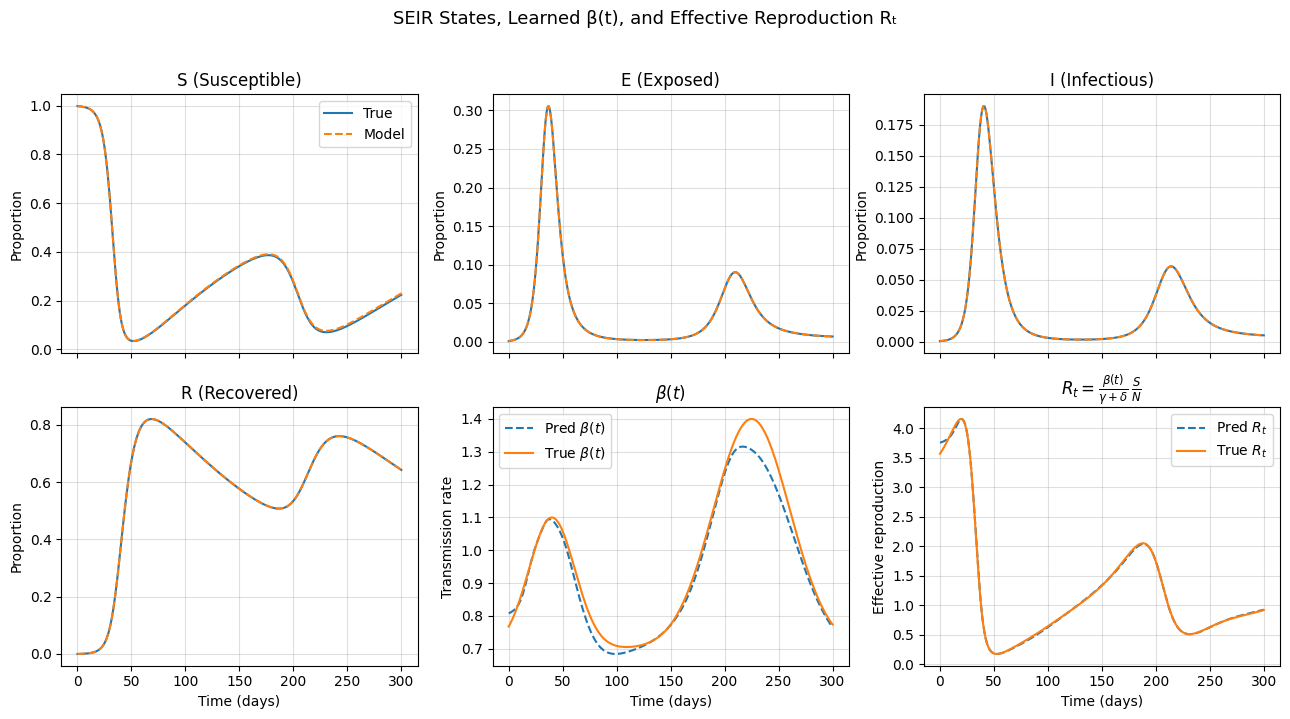

Saved figure: multi_run_results/states_beta_rt_beta_learned.pdf


In [ ]:
# --------------------------------------------
# (F) Plotting (S, E, I, R, and beta in one figure)
# --------------------------------------------
# --------------------------------------------
# (F) Plotting (S, E, I, R, beta, and Rt)
# --------------------------------------------
def plot_states_and_beta(params, t_data, data, scale_factor, run_id, beta_true=None):
    # SEIR constants used in both data gen and PINN ODEs
    gamma = 1 / 5.0
    delta = 0.015

    # Predict all 5 outputs: [S, E, I, R, beta_raw]
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1, 1))  # (T,5)
    beta_pred = jax.nn.softplus(pred_all[:, 4])                 # (T,)

    # Convert to numpy for matplotlib
    t_np = np.asarray(t_data)
    pred_np = np.asarray(pred_all)                              # (T,5)
    beta_pred_np = np.asarray(beta_pred)                        # (T,)

    # Prepare scaled states (real scale) for TRUE and PRED
    sf = np.asarray(scale_factor).reshape(1, -1)                # (1,4) for broadcasting
    true_states = np.asarray(data) * sf                         # (T,4)
    pred_states = pred_np[:, :4] * sf                           # (T,4)

    # Compute Rt (predicted)
    S_pred = pred_states[:, 0]
    N_pred = np.clip(np.sum(pred_states, axis=1), 1e-12, np.inf)
    Rt_pred = (beta_pred_np / (gamma + delta)) * (S_pred / N_pred)

    # Compute Rt (true) if beta_true available
    Rt_true = None
    if beta_true is not None:
        S_true = true_states[:, 0]
        N_true = np.clip(np.sum(true_states, axis=1), 1e-12, np.inf)
        Rt_true = (np.asarray(beta_true) / (gamma + delta)) * (S_true / N_true)

    # 2x3 grid: S, E, I, R, beta, Rt
    fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharex=True)
    axs = axs.flatten()
    names = ["S (Susceptible)", "E (Exposed)", "I (Infectious)", "R (Recovered)"]

    # Plot S, E, I, R
    for i in range(4):
        axs[i].plot(t_np, true_states[:, i], label='True', linewidth=1.5)
        axs[i].plot(t_np, pred_states[:, i], '--', label='Model', linewidth=1.5)
        axs[i].set_title(names[i])
        axs[i].set_ylabel("Proportion")
        axs[i].grid(True, alpha=0.4)
        if i == 0:
            axs[i].legend()

    # Plot beta(t)
    axb = axs[4]
    axb.plot(t_np, beta_pred_np, '--', label=r'Pred $\beta(t)$', linewidth=1.5)
    if beta_true is not None:
        axb.plot(t_np, np.asarray(beta_true), label=r'True $\beta(t)$', linewidth=1.5)
    axb.set_title(r"$\beta(t)$")
    axb.set_xlabel("Time (days)")
    axb.set_ylabel("Transmission rate")
    axb.grid(True, alpha=0.4)
    axb.legend()

    # Plot Rt
    axr = axs[5]
    axr.plot(t_np, Rt_pred, '--', label=r'Pred $R_t$', linewidth=1.5)
    if Rt_true is not None:
        axr.plot(t_np, Rt_true, label=r'True $R_t$', linewidth=1.5)
    axr.set_title(r"$R_t = \frac{\beta(t)}{\gamma+\delta}\,\frac{S}{N}$")
    axr.set_xlabel("Time (days)")
    axr.set_ylabel("Effective reproduction")
    axr.grid(True, alpha=0.4)
    axr.legend()

    # Shared x-labels
    axs[3].set_xlabel("Time (days)")

    fig.suptitle("SEIR States, Learned β(t), and Effective Reproduction Rₜ", y=1.02, fontsize=13)
    fig.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    out = f"multi_run_results/states_beta_rt_{run_id}.pdf"
    plt.savefig(out)
    plt.show()
    print(f"Saved figure: {out}")


plot_states_and_beta(trained, t_data, data, max_scl, run_id="beta_learned", beta_true=beta_true)


#PIKANs_new + Data of ALL+ unknown Beta

In [ ]:
# ============================================
# SEIR (4-state) PINN/KAN with learned beta(t) as 5th output
# ============================================

# --- Imports ---
import os, time, sys
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacrev
from jax.tree_util import tree_flatten
import optax
import matplotlib.pyplot as plt

# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R) + beta_true for inspection
# --------------------------------------------
# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R) + beta_true + Rt
# --------------------------------------------
def generate_seir_data(filename="simulated_data_seir.npz",
                       T=300, t_end=300.0,
                       r=(0.4, 0.7),          # two Gaussian pulses (stronger 2nd wave)
                       tm=(40.0, 225.0),      # centers of the pulses
                       dm=(30.0, 50.0)):      # widths of the pulses
    from scipy.integrate import odeint

    t = np.linspace(0.0, t_end, T)                 # (T,)
    t_i = np.array([[t[0]]], dtype=float)          # (1,1)

    # SEIR constants
    sigma   = 1 / 6.57
    gamma   = 1 / 5
    delta   = 0.015
    omega_n = 1 / 180.0   # natural immunity waning rate

    r  = np.array(r,  dtype=float)
    tm = np.array(tm, dtype=float)
    dm = np.array(dm, dtype=float)

    beta0 = 0.7   # baseline β
    def beta_func(tt):
        if np.isscalar(tt):
            return float(beta0 + np.sum(r * np.exp(-((tt - tm)**2) / (dm**2))))
        tcol = np.asarray(tt).reshape(-1,1)
        return beta0 + np.sum(
            r[None,:] * np.exp(-((tcol - tm[None,:])**2) / (dm[None,:]**2)),
            axis=1
        )

    def rhs(y, tt):
        S, E, I, R = y
        N = S + E + I + R
        beta = beta_func(tt)
        dS = -beta * S * I / N + omega_n * R
        dE =  beta * S * I / N - sigma * E
        dI =  sigma * E - (gamma + delta) * I
        dR =  gamma * I - omega_n * R
        return [dS, dE, dI, dR]

    # IC (close to disease-free)
    N0, E0, I0, R0 = 1.0, 0.001, 0.0005, 0.0
    S0 = N0 - E0 - I0 - R0
    y0 = [S0, E0, I0, R0]

    sol = odeint(rhs, y0, t).astype(float)  # (T,4)
    data = sol
    beta_true = beta_func(t).astype(float)  # (T,)

    # Effective reproduction number Rt
    S = data[:, 0]
    N = np.sum(data, axis=1)
    Rt = (beta_true / (gamma + delta)) * (S / N)

    # Per-state scale factors (kept for PINN scaling)
    max_scl = np.maximum(1.0, np.max(np.abs(data), axis=0))  # (4,)
    IC = np.array([[S0, E0, I0, R0]], dtype=float)           # (1,4)

    np.savez(
        filename,
        data=data, t=t, t_i=t_i, IC=IC, max_scl=max_scl,
        beta_true=beta_true, Rt=Rt
    )
    print(f"Saved {filename}: data.shape={data.shape}, max_scl={max_scl}")

# Generate once (comment this out if you already have data)
generate_seir_data()

# --------------------------------------------
# (B) Load data (4 states) + beta_true for plotting
# --------------------------------------------
loaded = np.load("simulated_data_seir.npz")
data      = loaded["data"]        # (T,4) -> S,E,I,R
t_data    = loaded["t"]           # (T,)
t_i       = loaded["t_i"]         # (1,1)
IC        = loaded["IC"]          # (1,4)
max_scl   = loaded["max_scl"]     # (4,)
beta_true = loaded.get("beta_true", None)

# Training times
t_dense = jnp.linspace(0.0, float(t_data[-1]), len(t_data))[:, None]  # (T,1)

# Which variables have data? (choose any subset of 0:S,1:E,2:I,3:R)
x_index = [0,1,2, 3]  # Infectious only, e.g. use [0,1,2,3] if you have all

# --------------------------------------------
# (C) KAN model (Chebyshev-based) -> now output 5 dims: [S,E,I,R,beta_raw]
# --------------------------------------------
def init_params_kan(layers, degree, key=jax.random.PRNGKey(1283)):
    keys = jax.random.split(key, len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys[:-1], layers[:-2], layers[1:-1]):
        W = jax.random.normal(key, shape=(n_in, n_out, degree + 1)) / jnp.sqrt(n_in * (degree + 1))
        B = jax.random.normal(key, shape=(n_out,))
        g = jax.random.normal(key, shape=(n_out,))
        params.append({'W': W, 'B': B, 'g': g})
    W = jax.random.normal(keys[-1], shape=(layers[-2], layers[-1])) / jnp.sqrt(layers[-2])
    B = jax.random.normal(keys[-1], shape=(layers[-1],))
    # Ks = {f"K{i+1}": jnp.array(fixed_vals[i]) for i in k_index}
    # Ks = {f"K{i+1}": jnp.array(1.0) for i in k_index}
    params.append({'W': W, 'B': B, 'delta':0.1})
    return params

def chebyshev_recursive(x, degree):
    if degree == 0: return x * 0 + 1
    if degree == 1: return x
    tm2, tm1 = x * 0 + 1, x
    for _ in range(2, degree + 1):
        tn = 2 * x * tm1 - tm2
        tm2, tm1 = tm1, tn
    return tm1

def fwd(params, t, activation=jax.nn.tanh, degree=3):
    t = t / float(t_data[-1])                # normalize time to ~[0,1]
    X = t.reshape((-1, 1))                   # (B,1)
    *hidden, last = params
    for layer in hidden:
        X = activation(X)
        coeffs = layer['W']                  # (in,out,deg+1)
        deg = coeffs.shape[2] - 1
        X_stack = jnp.stack([chebyshev_recursive(X, d) for d in range(deg + 1)], axis=-1)  # (B,in,deg+1)
        X = jnp.einsum("bid,iod->bo", X_stack, coeffs)   # (B,out)
        X = layer['g'] * X + layer['B']
        X = activation(X)
    return jnp.dot(X, last['W']) + last['B']             # (B,5) -> [S,E,I,R,beta_raw]




# --------------------------------------------
# (D) Losses (IC, Data, ODE) with learned beta
# --------------------------------------------
@jax.jit
def MSE(true, pred):  # true/pred: (B,dim) or (1,dim)
    return jnp.mean((true - pred) ** 2)

def ODE_loss(params, t, y_func, max_scl):
    """
    Network outputs y = [S, E, I, R, beta_raw].
    Returns list of 4 residual arrays (one per state): each (T,1,1)
    """
    # Constants
    sigma   = 1 / 6.57
    gamma   = 1 / 5
    delta   = params[-1]['delta']*0.1 #0.015
    omega_n = 1 / 180.0

    # Predictions and time-derivatives
    y_vals = jax.vmap(y_func)(t)         # (T,5)
    dy_dt  = jax.vmap(jacrev(y_func))(t) # (T,5,1)

    # Unscale states for RHS calc
    S = y_vals[:, 0:1] * max_scl[0]
    E = y_vals[:, 1:2] * max_scl[1]
    I = y_vals[:, 2:3] * max_scl[2]
    R = y_vals[:, 3:4] * max_scl[3]

    # Learned β(t) (nonnegative)
    beta_t = jax.nn.softplus(y_vals[:, 4:5])
    # beta_t = jnp.clip(beta_t, 0.0, 3.0)  # optional cap if needed

    N = jnp.clip(S + E + I + R, 1e-8, jnp.inf)

    # SEIR with immunity waning (model-file version)
    dS = -beta_t * S * I / N + omega_n * R
    dE =  beta_t * S * I / N - sigma * E
    dI =  sigma * E - (gamma + delta) * I
    dR =  gamma * I - omega_n * R

    # Scale back to network scale
    rhs_S = dS / max_scl[0]
    rhs_E = dE / max_scl[1]
    rhs_I = dI / max_scl[2]
    rhs_R = dR / max_scl[3]

    res_S = dy_dt[:, 0:1, :] - rhs_S.reshape(-1,1,1)
    res_E = dy_dt[:, 1:2, :] - rhs_E.reshape(-1,1,1)
    res_I = dy_dt[:, 2:3, :] - rhs_I.reshape(-1,1,1)
    res_R = dy_dt[:, 3:4, :] - rhs_R.reshape(-1,1,1)

    return [res_S, res_E, res_I, res_R]


def loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl):
    # y_func returns 5 outputs, but we compare data/IC using first 4
    y_func = lambda tt: fwd(params, tt.reshape(1,1)).squeeze()  # -> (5,)
    residuals = ODE_loss(params, t_c, y_func, max_scl)
    loss_odes = [lambdas[i] * jnp.mean(res**2) for i, res in enumerate(residuals)]

    # IC loss on S,E,I,R
    pred_IC = fwd(params, t_i)[:, :4]                  # (1,4)
    loss_IC = MSE(jnp.asarray(data_IC), pred_IC)

    # Data loss (only over chosen indices among first 4 states)
    pred_d = fwd(params, t_d)[:, :4]                   # (T,4)
    loss_data = sum(MSE(jnp.asarray(data)[:, i:i+1], pred_d[:, i:i+1]) for i in x_index)

    return loss_IC, loss_data, *loss_odes  # total of 2 + 4 = 6 terms

def loss_fun_total(params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl):
    losses = loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl)
    return sum(w * l for w, l in zip(loss_weight, losses))

# --------------------------------------------
# (E) Training
# --------------------------------------------
def train_model(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl, epochs, loss_weight):
    # # Optional: add gradient clipping to avoid NaNs early on
    # optimizer = optax.chain(
    #     optax.clip_by_global_norm(1.0),
    #     optax.adam(1e-5)
    # )

    # Exponential LR schedule
    schedule = optax.exponential_decay(
        init_value=1e-3,        # initial learning rate
        transition_steps=20000,  # how many steps per decay "tick"
        decay_rate=0.7,         # multiply LR by this every transition_steps
        staircase=False          # True = stepwise, False = smooth
    )

    # Optimizer with gradient clipping + Adam using the schedule
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=schedule)
    )
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fun_total)(
            params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(epochs):
        params, opt_state, loss = update(params, opt_state)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {float(loss):.2e} , delat: {params[-1]['delta']*0.1}")
    return params

# --------------------------------------------
# (F) Plotting (states + optional beta)
# --------------------------------------------
def plot_predicted_vs_data(params, t_data, data, scale_factor, run_id):
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1,1))   # (T,5)
    pred = pred_all[:, :4]
    beta_pred = jax.nn.softplus(pred_all[:, 4])                 # (T,)

    var_names = ['S', 'E', 'I', 'R']
    fig, axs = plt.subplots(2, 2, figsize=(10,6), sharex=True)
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(t_data, data[:, i] * scale_factor[i], 'b-', label='True')
        axs[i].plot(t_data, pred[:, i] * scale_factor[i], 'k--', label='Model')
        axs[i].set_title(var_names[i]); axs[i].grid(True)
        if i == 0: axs[i].legend()
    plt.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    plt.savefig(f"pred_vs_true_run{run_id}.pdf")
    plt.close()

    # Optional beta(t) comparison plot if beta_true available
    if beta_true is not None:
        plt.figure(figsize=(10,4))
        plt.plot(t_data, beta_true, label=r"True $\beta(t)$")
        plt.plot(t_data, np.array(beta_pred), '--', label=r"Pred $\beta(t)$")
        plt.xlabel("Time (days)"); plt.ylabel("Transmission rate β(t)")
        plt.title("β(t): true vs predicted")
        plt.grid(True); plt.legend(); plt.tight_layout()
        plt.savefig(f"beta_true_vs_pred_run{run_id}.pdf")
        plt.close()

# --------------------------------------------
# (G) Run training with KAN (output dim = 5)
# --------------------------------------------
layers = [1, 30, 30,30,30, 5]          # 5 outputs: S,E,I,R,beta_raw
loss_weight = [0.1, 0.1] + [1.0]*4   # IC, Data, then 4 ODE residuals

print("\n=== Training with learned beta(t) ===")
key = jax.random.PRNGKey(706)
params = init_params_kan(layers, degree=3, key=key)
lambdas = [1.0] * 4

trained = train_model(
    params, lambdas,
    jnp.asarray(t_i), jnp.asarray(t_dense), jnp.asarray(t_dense),
    jnp.asarray(IC), jnp.asarray(data), jnp.asarray(max_scl),
    epochs=200001, loss_weight=loss_weight
)

# Save params (flatten like before)
flat, _ = tree_flatten(trained)
os.makedirs("multi_run_results", exist_ok=True)
np.savez("multi_run_results/params_run_beta_learned.npz", *[np.array(p) for p in flat])

# Plots
plot_predicted_vs_data(trained, t_data, data, max_scl, run_id="beta_learned")

print("✅ Done. Figures: pred_vs_true_runbeta_learned.pdf and beta_true_vs_pred_runbeta_learned.pdf")


Saved simulated_data_seir.npz: data.shape=(300, 4), max_scl=[1. 1. 1. 1.]

=== Training with learned beta(t) ===
Epoch 0, Loss: 5.10e-01 , delat: 0.009900003671646118
Epoch 1000, Loss: 1.43e-05 , delat: 0.00650359271094203
Epoch 2000, Loss: 4.59e-06 , delat: 0.010541952215135098
Epoch 3000, Loss: 2.72e-06 , delat: 0.011800411157310009
Epoch 4000, Loss: 1.97e-06 , delat: 0.01222992967814207
Epoch 5000, Loss: 1.36e-06 , delat: 0.013348332606256008
Epoch 6000, Loss: 3.16e-06 , delat: 0.013472235761582851
Epoch 7000, Loss: 1.31e-06 , delat: 0.014285938814282417
Epoch 8000, Loss: 6.54e-07 , delat: 0.01405699085444212
Epoch 9000, Loss: 5.08e-06 , delat: 0.014069527387619019
Epoch 10000, Loss: 1.41e-06 , delat: 0.014061014167964458
Epoch 11000, Loss: 3.57e-07 , delat: 0.014552821405231953
Epoch 12000, Loss: 4.76e-07 , delat: 0.0140340281650424
Epoch 13000, Loss: 6.37e-06 , delat: 0.014509824104607105
Epoch 14000, Loss: 1.31e-06 , delat: 0.014516501687467098
Epoch 15000, Loss: 2.48e-07 , delat

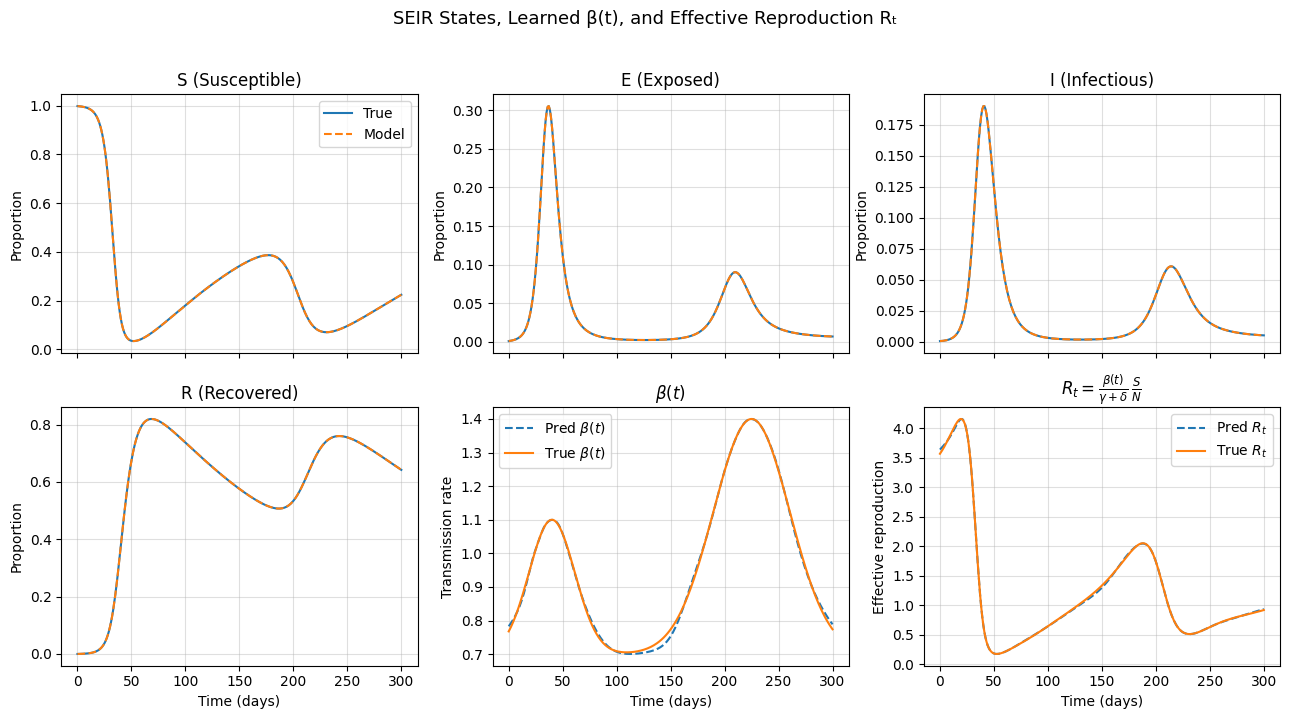

Saved figure: multi_run_results/states_beta_rt_beta_learned.pdf


In [ ]:
# --------------------------------------------
# (F) Plotting (S, E, I, R, and beta in one figure)
# --------------------------------------------
# --------------------------------------------
# (F) Plotting (S, E, I, R, beta, and Rt)
# --------------------------------------------
def plot_states_and_beta(params, t_data, data, scale_factor, run_id, beta_true=None):
    # SEIR constants used in both data gen and PINN ODEs
    gamma = 1 / 5.0
    delta = 0.015

    # Predict all 5 outputs: [S, E, I, R, beta_raw]
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1, 1))  # (T,5)
    beta_pred = jax.nn.softplus(pred_all[:, 4])                 # (T,)

    # Convert to numpy for matplotlib
    t_np = np.asarray(t_data)
    pred_np = np.asarray(pred_all)                              # (T,5)
    beta_pred_np = np.asarray(beta_pred)                        # (T,)

    # Prepare scaled states (real scale) for TRUE and PRED
    sf = np.asarray(scale_factor).reshape(1, -1)                # (1,4) for broadcasting
    true_states = np.asarray(data) * sf                         # (T,4)
    pred_states = pred_np[:, :4] * sf                           # (T,4)

    # Compute Rt (predicted)
    S_pred = pred_states[:, 0]
    N_pred = np.clip(np.sum(pred_states, axis=1), 1e-12, np.inf)
    Rt_pred = (beta_pred_np / (gamma + delta)) * (S_pred / N_pred)

    # Compute Rt (true) if beta_true available
    Rt_true = None
    if beta_true is not None:
        S_true = true_states[:, 0]
        N_true = np.clip(np.sum(true_states, axis=1), 1e-12, np.inf)
        Rt_true = (np.asarray(beta_true) / (gamma + delta)) * (S_true / N_true)

    # 2x3 grid: S, E, I, R, beta, Rt
    fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharex=True)
    axs = axs.flatten()
    names = ["S (Susceptible)", "E (Exposed)", "I (Infectious)", "R (Recovered)"]

    # Plot S, E, I, R
    for i in range(4):
        axs[i].plot(t_np, true_states[:, i], label='True', linewidth=1.5)
        axs[i].plot(t_np, pred_states[:, i], '--', label='Model', linewidth=1.5)
        axs[i].set_title(names[i])
        axs[i].set_ylabel("Proportion")
        axs[i].grid(True, alpha=0.4)
        if i == 0:
            axs[i].legend()

    # Plot beta(t)
    axb = axs[4]
    axb.plot(t_np, beta_pred_np, '--', label=r'Pred $\beta(t)$', linewidth=1.5)
    if beta_true is not None:
        axb.plot(t_np, np.asarray(beta_true), label=r'True $\beta(t)$', linewidth=1.5)
    axb.set_title(r"$\beta(t)$")
    axb.set_xlabel("Time (days)")
    axb.set_ylabel("Transmission rate")
    axb.grid(True, alpha=0.4)
    axb.legend()

    # Plot Rt
    axr = axs[5]
    axr.plot(t_np, Rt_pred, '--', label=r'Pred $R_t$', linewidth=1.5)
    if Rt_true is not None:
        axr.plot(t_np, Rt_true, label=r'True $R_t$', linewidth=1.5)
    axr.set_title(r"$R_t = \frac{\beta(t)}{\gamma+\delta}\,\frac{S}{N}$")
    axr.set_xlabel("Time (days)")
    axr.set_ylabel("Effective reproduction")
    axr.grid(True, alpha=0.4)
    axr.legend()

    # Shared x-labels
    axs[3].set_xlabel("Time (days)")

    fig.suptitle("SEIR States, Learned β(t), and Effective Reproduction Rₜ", y=1.02, fontsize=13)
    fig.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    out = f"multi_run_results/states_beta_rt_{run_id}.pdf"
    plt.savefig(out)
    plt.show()
    print(f"Saved figure: {out}")


plot_states_and_beta(trained, t_data, data, max_scl, run_id="beta_learned", beta_true=beta_true)


In [ ]:
# ============================================
# SEIR (4-state) PINN/KAN with learned beta(t) as 5th output
# ============================================

# --- Imports ---
import os, time, sys
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacrev
from jax.tree_util import tree_flatten
import optax
import matplotlib.pyplot as plt

# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R) + beta_true for inspection
# --------------------------------------------
# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R) + beta_true + Rt
# --------------------------------------------
def generate_seir_data(filename="simulated_data_seir.npz",
                       T=300, t_end=300.0,
                       r=(0.4, 0.7),          # two Gaussian pulses (stronger 2nd wave)
                       tm=(40.0, 225.0),      # centers of the pulses
                       dm=(30.0, 50.0)):      # widths of the pulses
    from scipy.integrate import odeint

    t = np.linspace(0.0, t_end, T)                 # (T,)
    t_i = np.array([[t[0]]], dtype=float)          # (1,1)

    # SEIR constants
    sigma   = 1 / 6.57
    gamma   = 1 / 5
    delta   = 0.015
    omega_n = 1 / 180.0   # natural immunity waning rate

    r  = np.array(r,  dtype=float)
    tm = np.array(tm, dtype=float)
    dm = np.array(dm, dtype=float)

    beta0 = 0.7   # baseline β
    def beta_func(tt):
        if np.isscalar(tt):
            return float(beta0 + np.sum(r * np.exp(-((tt - tm)**2) / (dm**2))))
        tcol = np.asarray(tt).reshape(-1,1)
        return beta0 + np.sum(
            r[None,:] * np.exp(-((tcol - tm[None,:])**2) / (dm[None,:]**2)),
            axis=1
        )

    def rhs(y, tt):
        S, E, I, R = y
        N = S + E + I + R
        beta = beta_func(tt)
        dS = -beta * S * I / N + omega_n * R
        dE =  beta * S * I / N - sigma * E
        dI =  sigma * E - (gamma + delta) * I
        dR =  gamma * I - omega_n * R
        return [dS, dE, dI, dR]

    # IC (close to disease-free)
    N0, E0, I0, R0 = 1.0, 0.001, 0.0005, 0.0
    S0 = N0 - E0 - I0 - R0
    y0 = [S0, E0, I0, R0]

    sol = odeint(rhs, y0, t).astype(float)  # (T,4)
    data = sol
    beta_true = beta_func(t).astype(float)  # (T,)

    # Effective reproduction number Rt
    S = data[:, 0]
    N = np.sum(data, axis=1)
    Rt = (beta_true / (gamma + delta)) * (S / N)

    # Per-state scale factors (kept for PINN scaling)
    max_scl = np.maximum(1.0, np.max(np.abs(data), axis=0))  # (4,)
    IC = np.array([[S0, E0, I0, R0]], dtype=float)           # (1,4)

    np.savez(
        filename,
        data=data, t=t, t_i=t_i, IC=IC, max_scl=max_scl,
        beta_true=beta_true, Rt=Rt
    )
    print(f"Saved {filename}: data.shape={data.shape}, max_scl={max_scl}")

# Generate once (comment this out if you already have data)
generate_seir_data()

# --------------------------------------------
# (B) Load data (4 states) + beta_true for plotting
# --------------------------------------------
loaded = np.load("simulated_data_seir.npz")
data      = loaded["data"]        # (T,4) -> S,E,I,R
t_data    = loaded["t"]           # (T,)
t_i       = loaded["t_i"]         # (1,1)
IC        = loaded["IC"]          # (1,4)
max_scl   = loaded["max_scl"]     # (4,)
beta_true = loaded.get("beta_true", None)

# Training times
t_dense = jnp.linspace(0.0, float(t_data[-1]), len(t_data))[:, None]  # (T,1)

# Which variables have data? (choose any subset of 0:S,1:E,2:I,3:R)
x_index = [2]  # Infectious only, e.g. use [0,1,2,3] if you have all

# --------------------------------------------
# (C) KAN model (Chebyshev-based) -> now output 5 dims: [S,E,I,R,beta_raw]
# --------------------------------------------
def init_params_kan(layers, degree, key=jax.random.PRNGKey(1283)):
    keys = jax.random.split(key, len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys[:-1], layers[:-2], layers[1:-1]):
        W = jax.random.normal(key, shape=(n_in, n_out, degree + 1)) / jnp.sqrt(n_in * (degree + 1))
        B = jax.random.normal(key, shape=(n_out,))
        g = jax.random.normal(key, shape=(n_out,))
        params.append({'W': W, 'B': B, 'g': g})
    W = jax.random.normal(keys[-1], shape=(layers[-2], layers[-1])) / jnp.sqrt(layers[-2])
    B = jax.random.normal(keys[-1], shape=(layers[-1],))
    # Ks = {f"K{i+1}": jnp.array(fixed_vals[i]) for i in k_index}
    # Ks = {f"K{i+1}": jnp.array(1.0) for i in k_index}
    params.append({'W': W, 'B': B, 'delta':1.0})
    return params

def chebyshev_recursive(x, degree):
    if degree == 0: return x * 0 + 1
    if degree == 1: return x
    tm2, tm1 = x * 0 + 1, x
    for _ in range(2, degree + 1):
        tn = 2 * x * tm1 - tm2
        tm2, tm1 = tm1, tn
    return tm1

def fwd(params, t, activation=jax.nn.tanh, degree=3):
    t = t / float(t_data[-1])                # normalize time to ~[0,1]
    X = t.reshape((-1, 1))                   # (B,1)
    *hidden, last = params
    for layer in hidden:
        X = activation(X)
        coeffs = layer['W']                  # (in,out,deg+1)
        deg = coeffs.shape[2] - 1
        X_stack = jnp.stack([chebyshev_recursive(X, d) for d in range(deg + 1)], axis=-1)  # (B,in,deg+1)
        X = jnp.einsum("bid,iod->bo", X_stack, coeffs)   # (B,out)
        X = layer['g'] * X + layer['B']
        X = activation(X)
    return jnp.dot(X, last['W']) + last['B']             # (B,5) -> [S,E,I,R,beta_raw]




# --------------------------------------------
# (D) Losses (IC, Data, ODE) with learned beta
# --------------------------------------------
@jax.jit
def MSE(true, pred):  # true/pred: (B,dim) or (1,dim)
    return jnp.mean((true - pred) ** 2)

def ODE_loss(params, t, y_func, max_scl):
    """
    Network outputs y = [S, E, I, R, beta_raw].
    Returns list of 4 residual arrays (one per state): each (T,1,1)
    """
    # Constants
    sigma   = 1 / 6.57
    gamma   = 1 / 5
    # eps = 1e-8
    delta = (jnp.tanh(params[-1]['delta'])+1)*0.1
    # delta   = (1+jnp.tanh(params[-1]['delta']))*0.1 #0.015
    omega_n = 1 / 180.0

    # Predictions and time-derivatives
    y_vals = jax.vmap(y_func)(t)         # (T,5)
    dy_dt  = jax.vmap(jacrev(y_func))(t) # (T,5,1)

    # Unscale states for RHS calc
    S = y_vals[:, 0:1] * max_scl[0]
    E = y_vals[:, 1:2] * max_scl[1]
    I = y_vals[:, 2:3] * max_scl[2]
    R = y_vals[:, 3:4] * max_scl[3]

    # Learned β(t) (nonnegative)
    beta_t = jax.nn.softplus(y_vals[:, 4:5])
    # beta_t = jnp.clip(beta_t, 0.0, 3.0)  # optional cap if needed

    N = jnp.clip(S + E + I + R, 1e-8, jnp.inf)

    # SEIR with immunity waning (model-file version)
    dS = -beta_t * S * I / N + omega_n * R
    dE =  beta_t * S * I / N - sigma * E
    dI =  sigma * E - (gamma + delta) * I
    dR =  gamma * I - omega_n * R

    # Scale back to network scale
    rhs_S = dS / max_scl[0]
    rhs_E = dE / max_scl[1]
    rhs_I = dI / max_scl[2]
    rhs_R = dR / max_scl[3]

    res_S = dy_dt[:, 0:1, :] - rhs_S.reshape(-1,1,1)
    res_E = dy_dt[:, 1:2, :] - rhs_E.reshape(-1,1,1)
    res_I = dy_dt[:, 2:3, :] - rhs_I.reshape(-1,1,1)
    res_R = dy_dt[:, 3:4, :] - rhs_R.reshape(-1,1,1)

    return [res_S, res_E, res_I, res_R]


def loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl):
    # y_func returns 5 outputs, but we compare data/IC using first 4
    y_func = lambda tt: fwd(params, tt.reshape(1,1)).squeeze()  # -> (5,)
    residuals = ODE_loss(params, t_c, y_func, max_scl)
    loss_odes = [lambdas[i] * jnp.mean(res**2) for i, res in enumerate(residuals)]

    # IC loss on S,E,I,R
    pred_IC = fwd(params, t_i)[:, :4]                  # (1,4)
    loss_IC = MSE(jnp.asarray(data_IC), pred_IC)

    # Data loss (only over chosen indices among first 4 states)
    pred_d = fwd(params, t_d)[:, :4]                   # (T,4)
    loss_data = sum(MSE(jnp.asarray(data)[:, i:i+1], pred_d[:, i:i+1]) for i in x_index)

    return loss_IC, loss_data, *loss_odes  # total of 2 + 4 = 6 terms

def loss_fun_total(params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl):
    losses = loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl)
    return sum(w * l for w, l in zip(loss_weight, losses))

# --------------------------------------------
# (E) Training
# --------------------------------------------
def train_model(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl, epochs, loss_weight):
    # # Optional: add gradient clipping to avoid NaNs early on
    # optimizer = optax.chain(
    #     optax.clip_by_global_norm(1.0),
    #     optax.adam(1e-5)
    # )

    # Exponential LR schedule
    schedule = optax.exponential_decay(
        init_value=1e-3,        # initial learning rate
        transition_steps=20000,  # how many steps per decay "tick"
        decay_rate=0.7,         # multiply LR by this every transition_steps
        staircase=False          # True = stepwise, False = smooth
    )

    # Optimizer with gradient clipping + Adam using the schedule
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=schedule)
    )
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fun_total)(
            params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(epochs):
        params, opt_state, loss = update(params, opt_state)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {float(loss):.2e} , delat: {(jnp.tanh(params[-1]['delta'])+1)*0.1}")
    return params

# --------------------------------------------
# (F) Plotting (states + optional beta)
# --------------------------------------------
def plot_predicted_vs_data(params, t_data, data, scale_factor, run_id):
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1,1))   # (T,5)
    pred = pred_all[:, :4]
    beta_pred = jax.nn.softplus(pred_all[:, 4])                 # (T,)

    var_names = ['S', 'E', 'I', 'R']
    fig, axs = plt.subplots(2, 2, figsize=(10,6), sharex=True)
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(t_data, data[:, i] * scale_factor[i], 'b-', label='True')
        axs[i].plot(t_data, pred[:, i] * scale_factor[i], 'k--', label='Model')
        axs[i].set_title(var_names[i]); axs[i].grid(True)
        if i == 0: axs[i].legend()
    plt.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    plt.savefig(f"pred_vs_true_run{run_id}.pdf")
    plt.close()

    # Optional beta(t) comparison plot if beta_true available
    if beta_true is not None:
        plt.figure(figsize=(10,4))
        plt.plot(t_data, beta_true, label=r"True $\beta(t)$")
        plt.plot(t_data, np.array(beta_pred), '--', label=r"Pred $\beta(t)$")
        plt.xlabel("Time (days)"); plt.ylabel("Transmission rate β(t)")
        plt.title("β(t): true vs predicted")
        plt.grid(True); plt.legend(); plt.tight_layout()
        plt.savefig(f"beta_true_vs_pred_run{run_id}.pdf")
        plt.close()

# --------------------------------------------
# (G) Run training with KAN (output dim = 5)
# --------------------------------------------
layers = [1, 30, 30,30,30, 5]          # 5 outputs: S,E,I,R,beta_raw
loss_weight = [0.1, 0.1] + [1.0]*4   # IC, Data, then 4 ODE residuals

print("\n=== Training with learned beta(t) ===")
key = jax.random.PRNGKey(706)
params = init_params_kan(layers, degree=3, key=key)
lambdas = [1.0] * 4

trained = train_model(
    params, lambdas,
    jnp.asarray(t_i), jnp.asarray(t_dense), jnp.asarray(t_dense),
    jnp.asarray(IC), jnp.asarray(data), jnp.asarray(max_scl),
    epochs=200001, loss_weight=loss_weight
)

# Save params (flatten like before)
flat, _ = tree_flatten(trained)
os.makedirs("multi_run_results", exist_ok=True)
np.savez("multi_run_results/params_run_beta_learned.npz", *[np.array(p) for p in flat])

# Plots
plot_predicted_vs_data(trained, t_data, data, max_scl, run_id="beta_learned")

print("✅ Done. Figures: pred_vs_true_runbeta_learned.pdf and beta_true_vs_pred_runbeta_learned.pdf")


Saved simulated_data_seir.npz: data.shape=(300, 4), max_scl=[1. 1. 1. 1.]

=== Training with learned beta(t) ===
Epoch 0, Loss: 3.21e-01 , delat: 0.176117405295372
Epoch 1000, Loss: 1.71e-04 , delat: 0.17495183646678925
Epoch 2000, Loss: 8.27e-05 , delat: 0.13287712633609772
Epoch 3000, Loss: 1.25e-05 , delat: 0.04944843053817749
Epoch 4000, Loss: 2.97e-06 , delat: 0.03030502237379551
Epoch 5000, Loss: 1.92e-06 , delat: 0.022055460140109062
Epoch 6000, Loss: 3.63e-06 , delat: 0.01700667105615139
Epoch 7000, Loss: 8.13e-06 , delat: 0.013594157062470913
Epoch 8000, Loss: 2.72e-06 , delat: 0.011179715394973755
Epoch 9000, Loss: 1.04e-06 , delat: 0.00943566020578146
Epoch 10000, Loss: 4.76e-07 , delat: 0.00826371368020773
Epoch 11000, Loss: 1.26e-06 , delat: 0.007579243276268244
Epoch 12000, Loss: 1.51e-06 , delat: 0.00730481743812561
Epoch 13000, Loss: 4.81e-07 , delat: 0.007401782553642988
Epoch 14000, Loss: 1.27e-06 , delat: 0.007924044504761696
Epoch 15000, Loss: 5.73e-07 , delat: 0.00

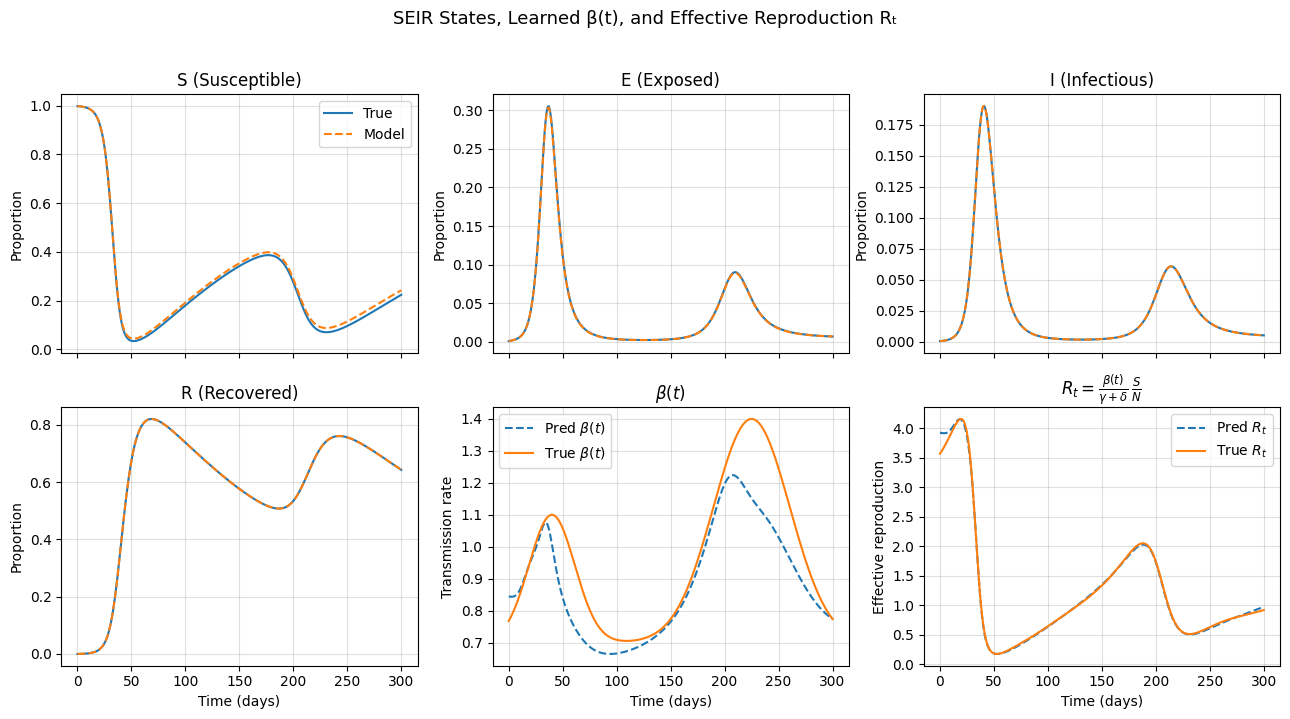

Saved figure: multi_run_results/states_beta_rt_beta_learned.pdf


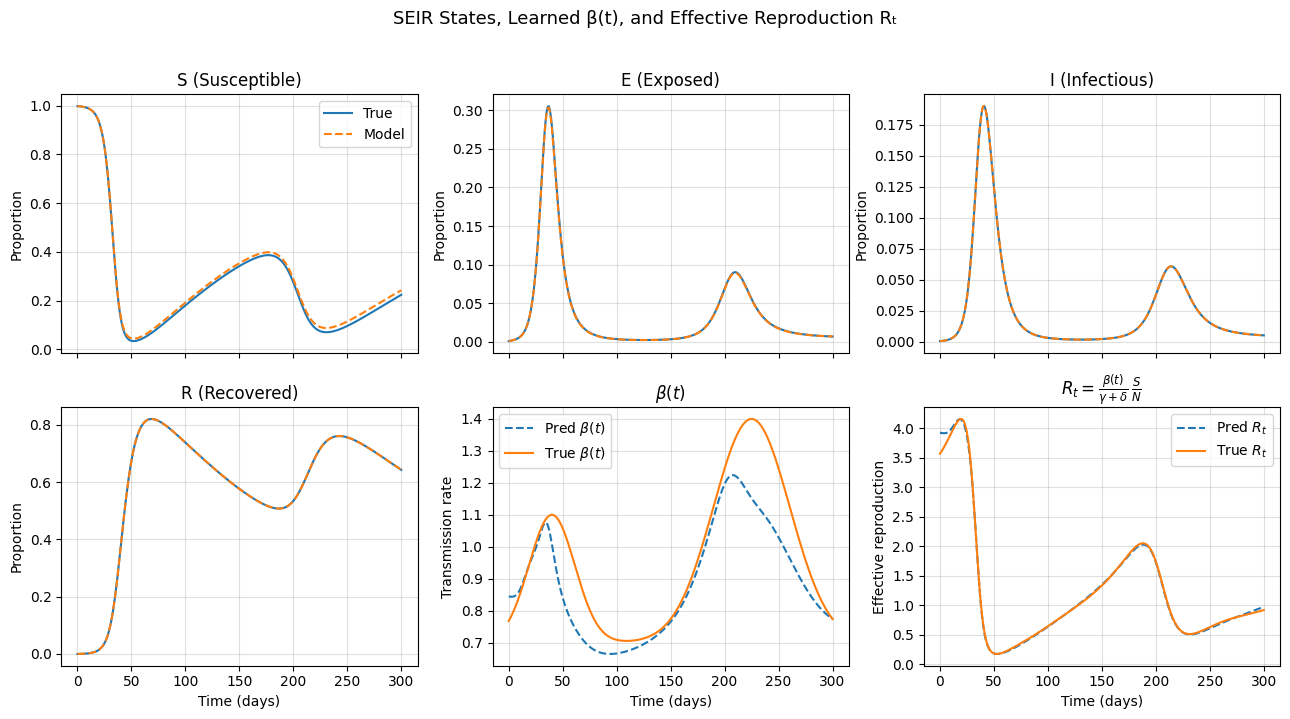

Saved figure: multi_run_results/states_beta_rt_beta_learned.pdf


In [ ]:
# --------------------------------------------
# (F) Plotting (S, E, I, R, and beta in one figure)
# --------------------------------------------
# --------------------------------------------
# (F) Plotting (S, E, I, R, beta, and Rt)
# --------------------------------------------
def plot_states_and_beta(params, t_data, data, scale_factor, run_id, beta_true=None):
    # SEIR constants used in both data gen and PINN ODEs
    gamma = 1 / 5.0
    delta = 0.015

    # Predict all 5 outputs: [S, E, I, R, beta_raw]
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1, 1))  # (T,5)
    beta_pred = jax.nn.softplus(pred_all[:, 4])                 # (T,)

    # Convert to numpy for matplotlib
    t_np = np.asarray(t_data)
    pred_np = np.asarray(pred_all)                              # (T,5)
    beta_pred_np = np.asarray(beta_pred)                        # (T,)

    # Prepare scaled states (real scale) for TRUE and PRED
    sf = np.asarray(scale_factor).reshape(1, -1)                # (1,4) for broadcasting
    true_states = np.asarray(data) * sf                         # (T,4)
    pred_states = pred_np[:, :4] * sf                           # (T,4)

    # Compute Rt (predicted)
    S_pred = pred_states[:, 0]
    N_pred = np.clip(np.sum(pred_states, axis=1), 1e-12, np.inf)
    Rt_pred = (beta_pred_np / (gamma + delta)) * (S_pred / N_pred)

    # Compute Rt (true) if beta_true available
    Rt_true = None
    if beta_true is not None:
        S_true = true_states[:, 0]
        N_true = np.clip(np.sum(true_states, axis=1), 1e-12, np.inf)
        Rt_true = (np.asarray(beta_true) / (gamma + delta)) * (S_true / N_true)

    # 2x3 grid: S, E, I, R, beta, Rt
    fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharex=True)
    axs = axs.flatten()
    names = ["S (Susceptible)", "E (Exposed)", "I (Infectious)", "R (Recovered)"]

    # Plot S, E, I, R
    for i in range(4):
        axs[i].plot(t_np, true_states[:, i], label='True', linewidth=1.5)
        axs[i].plot(t_np, pred_states[:, i], '--', label='Model', linewidth=1.5)
        axs[i].set_title(names[i])
        axs[i].set_ylabel("Proportion")
        axs[i].grid(True, alpha=0.4)
        if i == 0:
            axs[i].legend()

    # Plot beta(t)
    axb = axs[4]
    axb.plot(t_np, beta_pred_np, '--', label=r'Pred $\beta(t)$', linewidth=1.5)
    if beta_true is not None:
        axb.plot(t_np, np.asarray(beta_true), label=r'True $\beta(t)$', linewidth=1.5)
    axb.set_title(r"$\beta(t)$")
    axb.set_xlabel("Time (days)")
    axb.set_ylabel("Transmission rate")
    axb.grid(True, alpha=0.4)
    axb.legend()

    # Plot Rt
    axr = axs[5]
    axr.plot(t_np, Rt_pred, '--', label=r'Pred $R_t$', linewidth=1.5)
    if Rt_true is not None:
        axr.plot(t_np, Rt_true, label=r'True $R_t$', linewidth=1.5)
    axr.set_title(r"$R_t = \frac{\beta(t)}{\gamma+\delta}\,\frac{S}{N}$")
    axr.set_xlabel("Time (days)")
    axr.set_ylabel("Effective reproduction")
    axr.grid(True, alpha=0.4)
    axr.legend()

    # Shared x-labels
    axs[3].set_xlabel("Time (days)")

    fig.suptitle("SEIR States, Learned β(t), and Effective Reproduction Rₜ", y=1.02, fontsize=13)
    fig.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    out = f"multi_run_results/states_beta_rt_{run_id}.pdf"
    plt.savefig(out)
    plt.show()
    print(f"Saved figure: {out}")


plot_states_and_beta(trained, t_data, data, max_scl, run_id="beta_learned", beta_true=beta_true)
# --------------------------------------------
# (F) Plotting (S, E, I, R, and beta in one figure)
# --------------------------------------------
# --------------------------------------------
# (F) Plotting (S, E, I, R, beta, and Rt)
# --------------------------------------------
def plot_states_and_beta(params, t_data, data, scale_factor, run_id, beta_true=None):
    # SEIR constants used in both data gen and PINN ODEs
    gamma = 1 / 5.0
    delta = 0.015

    # Predict all 5 outputs: [S, E, I, R, beta_raw]
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1, 1))  # (T,5)
    beta_pred = jax.nn.softplus(pred_all[:, 4])                 # (T,)

    # Convert to numpy for matplotlib
    t_np = np.asarray(t_data)
    pred_np = np.asarray(pred_all)                              # (T,5)
    beta_pred_np = np.asarray(beta_pred)                        # (T,)

    # Prepare scaled states (real scale) for TRUE and PRED
    sf = np.asarray(scale_factor).reshape(1, -1)                # (1,4) for broadcasting
    true_states = np.asarray(data) * sf                         # (T,4)
    pred_states = pred_np[:, :4] * sf                           # (T,4)

    # Compute Rt (predicted)
    S_pred = pred_states[:, 0]
    N_pred = np.clip(np.sum(pred_states, axis=1), 1e-12, np.inf)
    Rt_pred = (beta_pred_np / (gamma + delta)) * (S_pred / N_pred)

    # Compute Rt (true) if beta_true available
    Rt_true = None
    if beta_true is not None:
        S_true = true_states[:, 0]
        N_true = np.clip(np.sum(true_states, axis=1), 1e-12, np.inf)
        Rt_true = (np.asarray(beta_true) / (gamma + delta)) * (S_true / N_true)

    # 2x3 grid: S, E, I, R, beta, Rt
    fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharex=True)
    axs = axs.flatten()
    names = ["S (Susceptible)", "E (Exposed)", "I (Infectious)", "R (Recovered)"]

    # Plot S, E, I, R
    for i in range(4):
        axs[i].plot(t_np, true_states[:, i], label='True', linewidth=1.5)
        axs[i].plot(t_np, pred_states[:, i], '--', label='Model', linewidth=1.5)
        axs[i].set_title(names[i])
        axs[i].set_ylabel("Proportion")
        axs[i].grid(True, alpha=0.4)
        if i == 0:
            axs[i].legend()

    # Plot beta(t)
    axb = axs[4]
    axb.plot(t_np, beta_pred_np, '--', label=r'Pred $\beta(t)$', linewidth=1.5)
    if beta_true is not None:
        axb.plot(t_np, np.asarray(beta_true), label=r'True $\beta(t)$', linewidth=1.5)
    axb.set_title(r"$\beta(t)$")
    axb.set_xlabel("Time (days)")
    axb.set_ylabel("Transmission rate")
    axb.grid(True, alpha=0.4)
    axb.legend()

    # Plot Rt
    axr = axs[5]
    axr.plot(t_np, Rt_pred, '--', label=r'Pred $R_t$', linewidth=1.5)
    if Rt_true is not None:
        axr.plot(t_np, Rt_true, label=r'True $R_t$', linewidth=1.5)
    axr.set_title(r"$R_t = \frac{\beta(t)}{\gamma+\delta}\,\frac{S}{N}$")
    axr.set_xlabel("Time (days)")
    axr.set_ylabel("Effective reproduction")
    axr.grid(True, alpha=0.4)
    axr.legend()

    # Shared x-labels
    axs[3].set_xlabel("Time (days)")

    fig.suptitle("SEIR States, Learned β(t), and Effective Reproduction Rₜ", y=1.02, fontsize=13)
    fig.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    out = f"multi_run_results/states_beta_rt_{run_id}.pdf"
    plt.savefig(out)
    plt.show()
    print(f"Saved figure: {out}")


plot_states_and_beta(trained, t_data, data, max_scl, run_id="beta_learned", beta_true=beta_true)


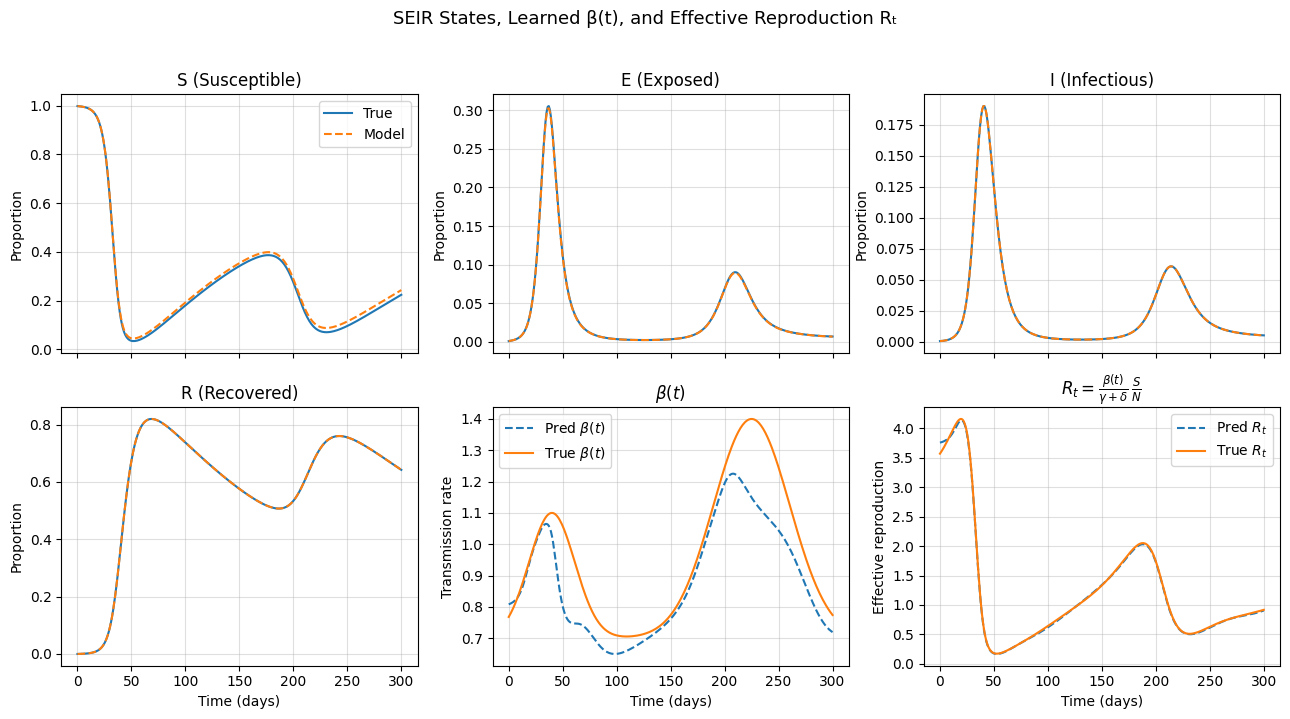

Saved figure: multi_run_results/states_beta_rt_beta_learned.pdf


In [ ]:
# --------------------------------------------
# (F) Plotting (S, E, I, R, and beta in one figure)
# --------------------------------------------
# --------------------------------------------
# (F) Plotting (S, E, I, R, beta, and Rt)
# --------------------------------------------
def plot_states_and_beta(params, t_data, data, scale_factor, run_id, beta_true=None):
    # SEIR constants used in both data gen and PINN ODEs
    gamma = 1 / 5.0
    delta = 0.015

    # Predict all 5 outputs: [S, E, I, R, beta_raw]
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1, 1))  # (T,5)
    beta_pred = jax.nn.softplus(pred_all[:, 4])                 # (T,)

    # Convert to numpy for matplotlib
    t_np = np.asarray(t_data)
    pred_np = np.asarray(pred_all)                              # (T,5)
    beta_pred_np = np.asarray(beta_pred)                        # (T,)

    # Prepare scaled states (real scale) for TRUE and PRED
    sf = np.asarray(scale_factor).reshape(1, -1)                # (1,4) for broadcasting
    true_states = np.asarray(data) * sf                         # (T,4)
    pred_states = pred_np[:, :4] * sf                           # (T,4)

    # Compute Rt (predicted)
    S_pred = pred_states[:, 0]
    N_pred = np.clip(np.sum(pred_states, axis=1), 1e-12, np.inf)
    Rt_pred = (beta_pred_np / (gamma + delta)) * (S_pred / N_pred)

    # Compute Rt (true) if beta_true available
    Rt_true = None
    if beta_true is not None:
        S_true = true_states[:, 0]
        N_true = np.clip(np.sum(true_states, axis=1), 1e-12, np.inf)
        Rt_true = (np.asarray(beta_true) / (gamma + delta)) * (S_true / N_true)

    # 2x3 grid: S, E, I, R, beta, Rt
    fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharex=True)
    axs = axs.flatten()
    names = ["S (Susceptible)", "E (Exposed)", "I (Infectious)", "R (Recovered)"]

    # Plot S, E, I, R
    for i in range(4):
        axs[i].plot(t_np, true_states[:, i], label='True', linewidth=1.5)
        axs[i].plot(t_np, pred_states[:, i], '--', label='Model', linewidth=1.5)
        axs[i].set_title(names[i])
        axs[i].set_ylabel("Proportion")
        axs[i].grid(True, alpha=0.4)
        if i == 0:
            axs[i].legend()

    # Plot beta(t)
    axb = axs[4]
    axb.plot(t_np, beta_pred_np, '--', label=r'Pred $\beta(t)$', linewidth=1.5)
    if beta_true is not None:
        axb.plot(t_np, np.asarray(beta_true), label=r'True $\beta(t)$', linewidth=1.5)
    axb.set_title(r"$\beta(t)$")
    axb.set_xlabel("Time (days)")
    axb.set_ylabel("Transmission rate")
    axb.grid(True, alpha=0.4)
    axb.legend()

    # Plot Rt
    axr = axs[5]
    axr.plot(t_np, Rt_pred, '--', label=r'Pred $R_t$', linewidth=1.5)
    if Rt_true is not None:
        axr.plot(t_np, Rt_true, label=r'True $R_t$', linewidth=1.5)
    axr.set_title(r"$R_t = \frac{\beta(t)}{\gamma+\delta}\,\frac{S}{N}$")
    axr.set_xlabel("Time (days)")
    axr.set_ylabel("Effective reproduction")
    axr.grid(True, alpha=0.4)
    axr.legend()

    # Shared x-labels
    axs[3].set_xlabel("Time (days)")

    fig.suptitle("SEIR States, Learned β(t), and Effective Reproduction Rₜ", y=1.02, fontsize=13)
    fig.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    out = f"multi_run_results/states_beta_rt_{run_id}.pdf"
    plt.savefig(out)
    plt.show()
    print(f"Saved figure: {out}")


plot_states_and_beta(trained, t_data, data, max_scl, run_id="beta_learned", beta_true=beta_true)


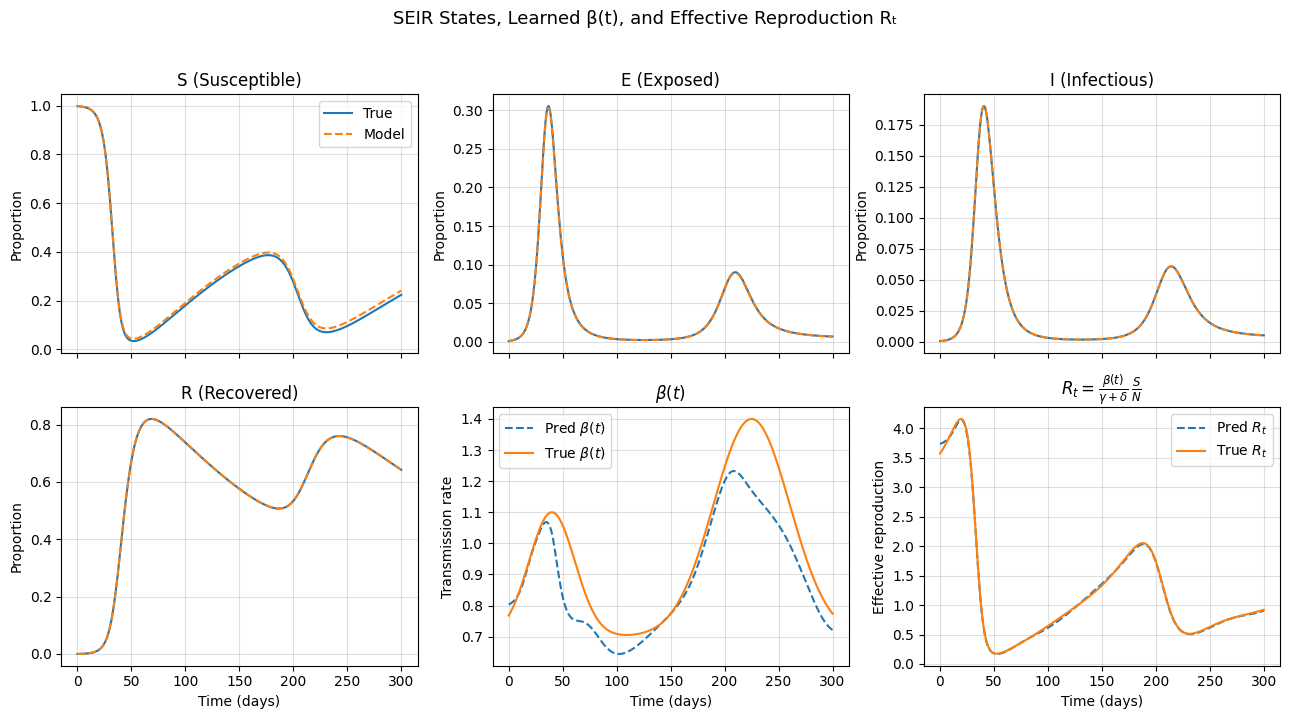

Saved figure: multi_run_results/states_beta_rt_beta_learned.pdf


In [ ]:
# --------------------------------------------
# (F) Plotting (S, E, I, R, and beta in one figure)
# --------------------------------------------
# --------------------------------------------
# (F) Plotting (S, E, I, R, beta, and Rt)
# --------------------------------------------
def plot_states_and_beta(params, t_data, data, scale_factor, run_id, beta_true=None):
    # SEIR constants used in both data gen and PINN ODEs
    gamma = 1 / 5.0
    delta = 0.015

    # Predict all 5 outputs: [S, E, I, R, beta_raw]
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1, 1))  # (T,5)
    beta_pred = jax.nn.softplus(pred_all[:, 4])                 # (T,)

    # Convert to numpy for matplotlib
    t_np = np.asarray(t_data)
    pred_np = np.asarray(pred_all)                              # (T,5)
    beta_pred_np = np.asarray(beta_pred)                        # (T,)

    # Prepare scaled states (real scale) for TRUE and PRED
    sf = np.asarray(scale_factor).reshape(1, -1)                # (1,4) for broadcasting
    true_states = np.asarray(data) * sf                         # (T,4)
    pred_states = pred_np[:, :4] * sf                           # (T,4)

    # Compute Rt (predicted)
    S_pred = pred_states[:, 0]
    N_pred = np.clip(np.sum(pred_states, axis=1), 1e-12, np.inf)
    Rt_pred = (beta_pred_np / (gamma + delta)) * (S_pred / N_pred)

    # Compute Rt (true) if beta_true available
    Rt_true = None
    if beta_true is not None:
        S_true = true_states[:, 0]
        N_true = np.clip(np.sum(true_states, axis=1), 1e-12, np.inf)
        Rt_true = (np.asarray(beta_true) / (gamma + delta)) * (S_true / N_true)

    # 2x3 grid: S, E, I, R, beta, Rt
    fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharex=True)
    axs = axs.flatten()
    names = ["S (Susceptible)", "E (Exposed)", "I (Infectious)", "R (Recovered)"]

    # Plot S, E, I, R
    for i in range(4):
        axs[i].plot(t_np, true_states[:, i], label='True', linewidth=1.5)
        axs[i].plot(t_np, pred_states[:, i], '--', label='Model', linewidth=1.5)
        axs[i].set_title(names[i])
        axs[i].set_ylabel("Proportion")
        axs[i].grid(True, alpha=0.4)
        if i == 0:
            axs[i].legend()

    # Plot beta(t)
    axb = axs[4]
    axb.plot(t_np, beta_pred_np, '--', label=r'Pred $\beta(t)$', linewidth=1.5)
    if beta_true is not None:
        axb.plot(t_np, np.asarray(beta_true), label=r'True $\beta(t)$', linewidth=1.5)
    axb.set_title(r"$\beta(t)$")
    axb.set_xlabel("Time (days)")
    axb.set_ylabel("Transmission rate")
    axb.grid(True, alpha=0.4)
    axb.legend()

    # Plot Rt
    axr = axs[5]
    axr.plot(t_np, Rt_pred, '--', label=r'Pred $R_t$', linewidth=1.5)
    if Rt_true is not None:
        axr.plot(t_np, Rt_true, label=r'True $R_t$', linewidth=1.5)
    axr.set_title(r"$R_t = \frac{\beta(t)}{\gamma+\delta}\,\frac{S}{N}$")
    axr.set_xlabel("Time (days)")
    axr.set_ylabel("Effective reproduction")
    axr.grid(True, alpha=0.4)
    axr.legend()

    # Shared x-labels
    axs[3].set_xlabel("Time (days)")

    fig.suptitle("SEIR States, Learned β(t), and Effective Reproduction Rₜ", y=1.02, fontsize=13)
    fig.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    out = f"multi_run_results/states_beta_rt_{run_id}.pdf"
    plt.savefig(out)
    plt.show()
    print(f"Saved figure: {out}")


plot_states_and_beta(trained, t_data, data, max_scl, run_id="beta_learned", beta_true=beta_true)


#PINNs +bETA and delta unknown+all data

Saved simulated_data_seir.npz: data.shape=(300, 4), max_scl=[1. 1. 1. 1.]

=== Training with learned beta(t) — MLP ===
Epoch 0, Loss: 1.07e-01, delta+: 0.009995
Epoch 1000, Loss: 1.82e-04, delta+: 0.009984
Epoch 2000, Loss: 1.24e-05, delta+: 0.010038
Epoch 3000, Loss: 1.54e-06, delta+: 0.010150
Epoch 4000, Loss: 6.15e-07, delta+: 0.010337
Epoch 5000, Loss: 3.42e-07, delta+: 0.010625
Epoch 6000, Loss: 2.29e-07, delta+: 0.011048
Epoch 7000, Loss: 1.49e-07, delta+: 0.011628
Epoch 8000, Loss: 1.02e-07, delta+: 0.012345
Epoch 9000, Loss: 9.51e-06, delta+: 0.013117
Epoch 10000, Loss: 1.27e-06, delta+: 0.013823
Epoch 11000, Loss: 3.95e-07, delta+: 0.014367
Epoch 12000, Loss: 3.38e-08, delta+: 0.014715
Epoch 13000, Loss: 9.58e-08, delta+: 0.014894
Epoch 14000, Loss: 4.04e-08, delta+: 0.014966
Epoch 15000, Loss: 3.07e-06, delta+: 0.014989
Epoch 16000, Loss: 2.19e-08, delta+: 0.014996
Epoch 17000, Loss: 2.22e-08, delta+: 0.014998
Epoch 18000, Loss: 1.98e-08, delta+: 0.014999
Epoch 19000, Loss: 4

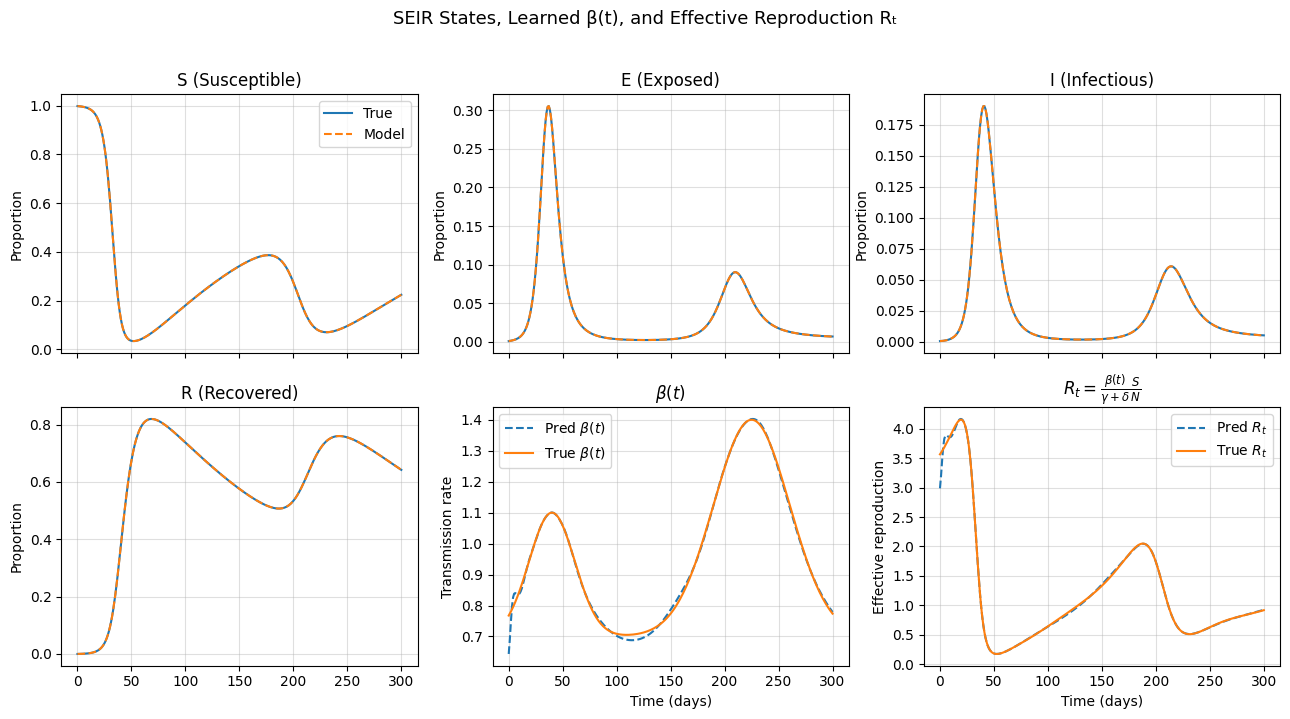

Saved figure: multi_run_results/states_beta_rt_beta_learned_mlp.pdf
✅ Done. Figures and params saved in multi_run_results/


In [ ]:
# ============================================
# SEIR (4-state) PINN/MLP with learned beta(t) as 5th output
# Waning immunity in data + ODE residuals. Plots states, β(t), and R_t.
# ============================================

# --- Imports ---
import os, time, sys
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacrev
from jax.tree_util import tree_flatten
import optax
import matplotlib.pyplot as plt

# ---------------- Global dtype ----------------
DTYPE = jnp.float32

# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R) + beta_true + Rt
# --------------------------------------------
def generate_seir_data(filename="simulated_data_seir.npz",
                       T=300, t_end=300.0,
                       r=(0.4, 0.7),          # two Gaussian pulses (stronger 2nd)
                       tm=(40.0, 225.0),      # centers of the pulses
                       dm=(30.0, 50.0)):      # widths of the pulses
    from scipy.integrate import odeint

    t = np.linspace(0.0, t_end, T)                 # (T,)
    t_i = np.array([[t[0]]], dtype=float)          # (1,1)

    # SEIR constants
    sigma   = 1 / 6.57
    gamma   = 1 / 5
    delta   = 0.015
    omega_n = 1 / 180.0   # natural immunity waning rate

    r  = np.array(r,  dtype=float)
    tm = np.array(tm, dtype=float)
    dm = np.array(dm, dtype=float)

    beta0 = 0.7   # baseline β
    def beta_func(tt):
        if np.isscalar(tt):
            return float(beta0 + np.sum(r * np.exp(-((tt - tm)**2) / (dm**2))))
        tcol = np.asarray(tt).reshape(-1,1)
        return beta0 + np.sum(
            r[None,:] * np.exp(-((tcol - tm[None,:])**2) / (dm[None,:]**2)),
            axis=1
        )

    def rhs(y, tt):
        S, E, I, R = y
        N = S + E + I + R
        beta = beta_func(tt)
        dS = -beta * S * I / N + omega_n * R
        dE =  beta * S * I / N - sigma * E
        dI =  sigma * E - (gamma + delta) * I
        dR =  gamma * I - omega_n * R
        return [dS, dE, dI, dR]

    # IC (close to disease-free)
    N0, E0, I0, R0 = 1.0, 0.001, 0.0005, 0.0
    S0 = N0 - E0 - I0 - R0
    y0 = [S0, E0, I0, R0]

    sol = odeint(rhs, y0, t).astype(float)  # (T,4)
    data = sol
    beta_true = beta_func(t).astype(float)  # (T,)

    # Effective reproduction number Rt
    S = data[:, 0]
    N = np.sum(data, axis=1)
    Rt = (beta_true / (gamma + delta)) * (S / N)

    # Per-state scale factors (kept for PINN scaling)
    max_scl = np.maximum(1.0, np.max(np.abs(data), axis=0))  # (4,)
    IC = np.array([[S0, E0, I0, R0]], dtype=float)           # (1,4)

    np.savez(
        filename,
        data=data, t=t, t_i=t_i, IC=IC, max_scl=max_scl,
        beta_true=beta_true, Rt=Rt
    )
    print(f"Saved {filename}: data.shape={data.shape}, max_scl={max_scl}")

# Generate once (comment this out if you already have data)
generate_seir_data()

# --------------------------------------------
# (B) Load data (+ cast to JAX dtype)
# --------------------------------------------
loaded   = np.load("simulated_data_seir.npz")
data     = loaded["data"]        # (T,4) -> S,E,I,R
t_data   = loaded["t"]           # (T,)
t_i      = loaded["t_i"]         # (1,1)
IC       = loaded["IC"]          # (1,4)
max_scl  = loaded["max_scl"]     # (4,)
beta_true= loaded.get("beta_true", None)
Rt_true  = loaded.get("Rt", None)

# JAX arrays (float32)
t_dense  = jnp.linspace(jnp.array(0.0, DTYPE), jnp.array(float(t_data[-1]), DTYPE), len(t_data)).reshape(-1,1)
t_i      = jnp.asarray(t_i, dtype=DTYPE)
IC       = jnp.asarray(IC, dtype=DTYPE)
data     = jnp.asarray(data, dtype=DTYPE)
max_scl  = jnp.asarray(max_scl, dtype=DTYPE)

# Which variables have data? 0:S,1:E,2:I,3:R
x_index = [0,1,2,3]

# --------------------------------------------
# (C) MLP model -> output 5 dims: [S,E,I,R,beta_raw]
# --------------------------------------------
def init_params_mlp(layers, key=jax.random.PRNGKey(1283)):
    """
    layers: e.g., [1, 128, 128, 128, 5]
    returns: list of dicts [{'W','B'}, ..., {'W','B','delta_raw'}]
    """
    keys = jax.random.split(key, len(layers) - 1)
    params = []
    # hidden layers
    for k, n_in, n_out in zip(keys[:-1], layers[:-2], layers[1:-1]):
        W = jax.random.normal(k, (n_in, n_out), dtype=DTYPE) / jnp.sqrt(n_in)
        B = jnp.zeros((n_out,), dtype=DTYPE)
        params.append({'W': W, 'B': B})
    # last layer (+ a trainable raw delta)
    W = jax.random.normal(keys[-1], (layers[-2], layers[-1]), dtype=DTYPE) / jnp.sqrt(layers[-2])
    B = jnp.zeros((layers[-1],), dtype=DTYPE)
    params.append({'W': W, 'B': B, 'delta_raw': jnp.array(0.0, dtype=DTYPE)})
    return params

def fwd(params, t, activation=jax.nn.tanh):
    """
    Input: t shape (B,1)
    Output: (B,5) = [S,E,I,R,beta_raw]
      - S,E,I,R in (0,1) via sigmoid (not forced to sum to 1)
      - beta_raw unconstrained; use softplus later to get β(t)≥0
    """
    X = t / jnp.array(float(t_data[-1]), DTYPE)  # normalize time ~[0,1]
    H = X.astype(DTYPE)
    *hidden, last = params
    for layer in hidden:
        H = activation(H @ layer['W'] + layer['B'])
    out = H @ last['W'] + last['B']       # (B,5)
    states = jax.nn.sigmoid(out[:, :4])   # (B,4)
    beta_raw = out[:, 4:5]                # (B,1)
    return jnp.concatenate([states, beta_raw], axis=1)

# --------------------------------------------
# (D) Losses (IC, Data, ODE) with learned beta, trained δ>0
# --------------------------------------------
@jax.jit
def MSE(true, pred):  # true/pred: (B,dim) or (1,dim)
    return jnp.mean((true - pred) ** 2)

def ODE_loss(params, t, y_func, max_scl):
    """
    Network outputs y = [S, E, I, R, beta_raw].
    Returns list of 4 residual arrays (one per state): each (T,1,1)
    """
    # Constants
    sigma   = jnp.array(1/6.57, DTYPE)
    gamma   = jnp.array(1/5.0,  DTYPE)
    omega_n = jnp.array(1/180., DTYPE)

    # strictly positive, gently bounded δ ∈ (0, 0.02)
    eps   = jnp.array(1e-8, dtype=DTYPE)
    delta = eps + jnp.array(0.02, DTYPE) * jax.nn.sigmoid(params[-1]['delta_raw'])

    # Predictions and time-derivatives
    y_vals = jax.vmap(y_func)(t)         # (T,5)
    dy_dt  = jax.vmap(jacrev(y_func))(t) # (T,5,1)

    # Unscale states for RHS calc (back to physical scale)
    S = y_vals[:, 0:1] * max_scl[0]
    E = y_vals[:, 1:2] * max_scl[1]
    I = y_vals[:, 2:3] * max_scl[2]
    R = y_vals[:, 3:4] * max_scl[3]

    # Learned β(t) (nonnegative)
    beta_t = jax.nn.softplus(y_vals[:, 4:5])

    N = jnp.clip(S + E + I + R, 1e-8, jnp.inf)

    # SEIR with immunity waning
    dS = -beta_t * S * I / N + omega_n * R
    dE =  beta_t * S * I / N - sigma * E
    dI =  sigma * E - (gamma + delta) * I
    dR =  gamma * I - omega_n * R

    # Scale back to network scale
    rhs_S = dS / max_scl[0]
    rhs_E = dE / max_scl[1]
    rhs_I = dI / max_scl[2]
    rhs_R = dR / max_scl[3]

    res_S = dy_dt[:, 0:1, :] - rhs_S.reshape(-1,1,1)
    res_E = dy_dt[:, 1:2, :] - rhs_E.reshape(-1,1,1)
    res_I = dy_dt[:, 2:3, :] - rhs_I.reshape(-1,1,1)
    res_R = dy_dt[:, 3:4, :] - rhs_R.reshape(-1,1,1)

    return [res_S, res_E, res_I, res_R]

def loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl):
    # y_func returns 5 outputs; compare data/IC using first 4
    y_func = lambda tt: fwd(params, tt.reshape(1,1)).squeeze()  # -> (5,)
    residuals = ODE_loss(params, t_c, y_func, max_scl)
    loss_odes = [lambdas[i] * jnp.mean(res**2) for i, res in enumerate(residuals)]

    # IC loss on S,E,I,R
    pred_IC = fwd(params, t_i)[:, :4]                  # (1,4)
    loss_IC = MSE(jnp.asarray(data_IC, DTYPE), pred_IC)

    # Data loss (only over chosen indices among first 4 states)
    pred_d = fwd(params, t_d)[:, :4]                   # (T,4)
    loss_data = sum(MSE(jnp.asarray(data, DTYPE)[:, i:i+1], pred_d[:, i:i+1]) for i in x_index)

    return loss_IC, loss_data, *loss_odes  # total of 2 + 4 = 6 terms

def loss_fun_total(params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl):
    losses = loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl)
    return sum(w * l for w, l in zip(loss_weight, losses))

# --------------------------------------------
# (E) Training
# --------------------------------------------
def train_model(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl, epochs, loss_weight):
    # Exponential LR schedule + gradient clipping
    schedule = optax.exponential_decay(
        init_value=1e-3,        # initial learning rate
        transition_steps=20000, # decay horizon
        decay_rate=0.7,
        staircase=False
    )
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=schedule)
    )
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fun_total)(
            params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(epochs):
        params, opt_state, loss = update(params, opt_state)
        if epoch % 1000 == 0:
            delta_val = float((1e-8 + 0.02 * jax.nn.sigmoid(params[-1]['delta_raw'])))
            print(f"Epoch {epoch}, Loss: {float(loss):.2e}, delta+: {delta_val:.6f}")
    return params

# --------------------------------------------
# (F) Plotting (S, E, I, R, β(t), and R_t)
# --------------------------------------------
def plot_states_beta_rt(params, t_data_np, data_np, scale_factor_np, run_id, beta_true=None):
    gamma = 1 / 5.0
    # use the *transformed* delta used in training
    delta_val = float((1e-8 + 0.02 * jax.nn.sigmoid(params[-1]['delta_raw'])))

    # Predict all 5 outputs
    pred_all = fwd(params, jnp.asarray(t_data_np).reshape(-1, 1))  # (T,5)
    beta_pred = jax.nn.softplus(pred_all[:, 4])                    # (T,)

    # Convert to numpy for plotting
    t_np = np.asarray(t_data_np)
    pred_np = np.asarray(pred_all)
    beta_pred_np = np.asarray(beta_pred)

    # Scale states (true & pred) back to physical scale
    sf = np.asarray(scale_factor_np).reshape(1, -1)   # (1,4)
    true_states = np.asarray(data_np) * sf            # (T,4)
    pred_states = pred_np[:, :4] * sf                 # (T,4)

    # Compute Rt
    S_pred = pred_states[:, 0]; N_pred = np.clip(np.sum(pred_states, axis=1), 1e-12, np.inf)
    Rt_pred = (beta_pred_np / (gamma + delta_val)) * (S_pred / N_pred)

    Rt_true = None
    if beta_true is not None:
        S_true = true_states[:, 0]; N_true = np.clip(np.sum(true_states, axis=1), 1e-12, np.inf)
        Rt_true = (np.asarray(beta_true) / (gamma + delta_val)) * (S_true / N_true)

    # 2x3 grid
    fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharex=True)
    axs = axs.flatten()
    names = ["S (Susceptible)", "E (Exposed)", "I (Infectious)", "R (Recovered)"]

    for i in range(4):
        axs[i].plot(t_np, true_states[:, i], label='True', linewidth=1.5)
        axs[i].plot(t_np, pred_states[:, i], '--', label='Model', linewidth=1.5)
        axs[i].set_title(names[i]); axs[i].set_ylabel("Proportion")
        axs[i].grid(True, alpha=0.4)
        if i == 0: axs[i].legend()

    # β(t)
    axb = axs[4]
    axb.plot(t_np, beta_pred_np, '--', label=r'Pred $\beta(t)$', linewidth=1.5)
    if beta_true is not None:
        axb.plot(t_np, np.asarray(beta_true), label=r'True $\beta(t)$', linewidth=1.5)
    axb.set_title(r"$\beta(t)$"); axb.set_xlabel("Time (days)")
    axb.set_ylabel("Transmission rate"); axb.grid(True, alpha=0.4); axb.legend()

    # R_t
    axr = axs[5]
    axr.plot(t_np, Rt_pred, '--', label=r'Pred $R_t$', linewidth=1.5)
    if Rt_true is not None:
        axr.plot(t_np, Rt_true, label=r'True $R_t$', linewidth=1.5)
    axr.set_title(r"$R_t = \frac{\beta(t)}{\gamma+\delta}\frac{S}{N}$")
    axr.set_xlabel("Time (days)"); axr.set_ylabel("Effective reproduction")
    axr.grid(True, alpha=0.4); axr.legend()

    fig.suptitle("SEIR States, Learned β(t), and Effective Reproduction Rₜ", y=1.02, fontsize=13)
    fig.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    out = f"multi_run_results/states_beta_rt_{run_id}.pdf"
    plt.savefig(out); plt.show()
    print(f"Saved figure: {out}")

# --------------------------------------------
# (G) Run training with MLP (output dim = 5)
# --------------------------------------------
layers = [1, 128, 128, 128, 5]          # 5 outputs: S,E,I,R,beta_raw
loss_weight = [0.1, 0.1] + [1.0]*4      # IC, Data, then 4 ODE residuals

print("\n=== Training with learned beta(t) — MLP ===")
key = jax.random.PRNGKey(706)
params = init_params_mlp(layers, key=key)
lambdas = [1.0] * 4

trained = train_model(
    params, lambdas,
    t_i, t_dense, t_dense,
    IC, data, max_scl,
    epochs=150000, loss_weight=loss_weight
)

# Save params (flatten like before)
flat, _ = tree_flatten(trained)
os.makedirs("multi_run_results", exist_ok=True)
np.savez("multi_run_results/params_run_beta_learned_mlp.npz", *[np.array(p) for p in flat])

# Plots
plot_states_beta_rt(trained, t_data, data, max_scl, run_id="beta_learned_mlp", beta_true=beta_true)

print("✅ Done. Figures and params saved in multi_run_results/")


Saved simulated_data_seir.npz: data.shape=(300, 4), max_scl=[1. 1. 1. 1.]

=== Training with learned beta(t) — MLP ===
Epoch 0, Loss: 1.88e-01, delta+: 0.099900
Epoch 1000, Loss: 9.07e-04, delta+: 0.096305
Epoch 2000, Loss: 3.64e-04, delta+: 0.074435
Epoch 3000, Loss: 2.34e-04, delta+: 0.051928
Epoch 4000, Loss: 2.06e-04, delta+: 0.034182
Epoch 5000, Loss: 1.40e-04, delta+: 0.021013
Epoch 6000, Loss: 1.27e-04, delta+: 0.012485
Epoch 7000, Loss: 1.25e-04, delta+: 0.007606
Epoch 8000, Loss: 1.06e-06, delta+: 0.006482
Epoch 9000, Loss: 5.09e-07, delta+: 0.006306
Epoch 10000, Loss: 2.82e-07, delta+: 0.006226
Epoch 11000, Loss: 4.51e-07, delta+: 0.006226
Epoch 12000, Loss: 1.09e-07, delta+: 0.006300
Epoch 13000, Loss: 8.98e-08, delta+: 0.006483
Epoch 14000, Loss: 5.83e-08, delta+: 0.006836
Epoch 15000, Loss: 4.39e-08, delta+: 0.007383
Epoch 16000, Loss: 4.36e-08, delta+: 0.008060
Epoch 17000, Loss: 2.94e-08, delta+: 0.008696
Epoch 18000, Loss: 2.53e-08, delta+: 0.009064
Epoch 19000, Loss: 2

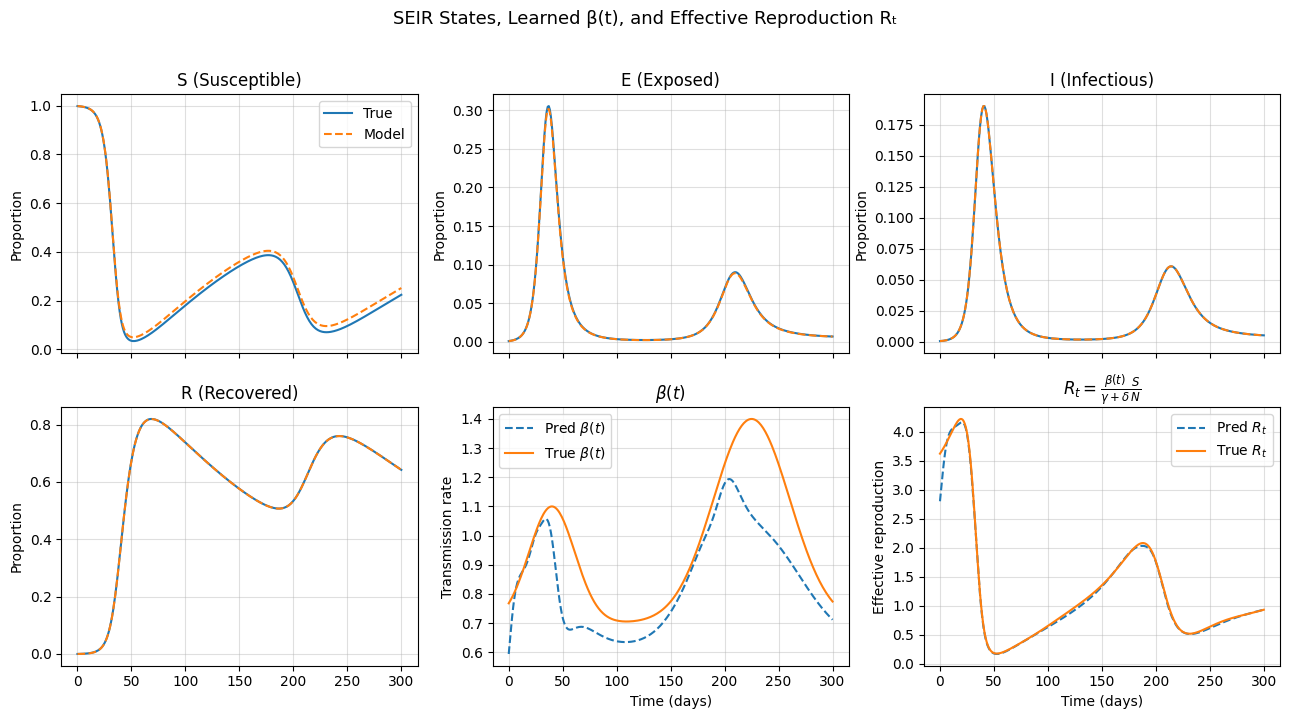

Saved figure: multi_run_results/states_beta_rt_beta_learned_mlp.pdf
✅ Done. Figures and params saved in multi_run_results/


In [ ]:
# ============================================
# SEIR (4-state) PINN/MLP with learned beta(t) as 5th output
# Waning immunity in data + ODE residuals. Plots states, β(t), and R_t.
# ============================================

# --- Imports ---
import os, time, sys
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacrev
from jax.tree_util import tree_flatten
import optax
import matplotlib.pyplot as plt

# ---------------- Global dtype ----------------
DTYPE = jnp.float32

# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R) + beta_true + Rt
# --------------------------------------------
def generate_seir_data(filename="simulated_data_seir.npz",
                       T=300, t_end=300.0,
                       r=(0.4, 0.7),          # two Gaussian pulses (stronger 2nd)
                       tm=(40.0, 225.0),      # centers of the pulses
                       dm=(30.0, 50.0)):      # widths of the pulses
    from scipy.integrate import odeint

    t = np.linspace(0.0, t_end, T)                 # (T,)
    t_i = np.array([[t[0]]], dtype=float)          # (1,1)

    # SEIR constants
    sigma   = 1 / 6.57
    gamma   = 1 / 5
    delta   = 0.015
    omega_n = 1 / 180.0   # natural immunity waning rate

    r  = np.array(r,  dtype=float)
    tm = np.array(tm, dtype=float)
    dm = np.array(dm, dtype=float)

    beta0 = 0.7   # baseline β
    def beta_func(tt):
        if np.isscalar(tt):
            return float(beta0 + np.sum(r * np.exp(-((tt - tm)**2) / (dm**2))))
        tcol = np.asarray(tt).reshape(-1,1)
        return beta0 + np.sum(
            r[None,:] * np.exp(-((tcol - tm[None,:])**2) / (dm[None,:]**2)),
            axis=1
        )

    def rhs(y, tt):
        S, E, I, R = y
        N = S + E + I + R
        beta = beta_func(tt)
        dS = -beta * S * I / N + omega_n * R
        dE =  beta * S * I / N - sigma * E
        dI =  sigma * E - (gamma + delta) * I
        dR =  gamma * I - omega_n * R
        return [dS, dE, dI, dR]

    # IC (close to disease-free)
    N0, E0, I0, R0 = 1.0, 0.001, 0.0005, 0.0
    S0 = N0 - E0 - I0 - R0
    y0 = [S0, E0, I0, R0]

    sol = odeint(rhs, y0, t).astype(float)  # (T,4)
    data = sol
    beta_true = beta_func(t).astype(float)  # (T,)

    # Effective reproduction number Rt
    S = data[:, 0]
    N = np.sum(data, axis=1)
    Rt = (beta_true / (gamma + delta)) * (S / N)

    # Per-state scale factors (kept for PINN scaling)
    max_scl = np.maximum(1.0, np.max(np.abs(data), axis=0))  # (4,)
    IC = np.array([[S0, E0, I0, R0]], dtype=float)           # (1,4)

    np.savez(
        filename,
        data=data, t=t, t_i=t_i, IC=IC, max_scl=max_scl,
        beta_true=beta_true, Rt=Rt
    )
    print(f"Saved {filename}: data.shape={data.shape}, max_scl={max_scl}")

# Generate once (comment this out if you already have data)
generate_seir_data()

# --------------------------------------------
# (B) Load data (+ cast to JAX dtype)
# --------------------------------------------
loaded   = np.load("simulated_data_seir.npz")
data     = loaded["data"]        # (T,4) -> S,E,I,R
t_data   = loaded["t"]           # (T,)
t_i      = loaded["t_i"]         # (1,1)
IC       = loaded["IC"]          # (1,4)
max_scl  = loaded["max_scl"]     # (4,)
beta_true= loaded.get("beta_true", None)
Rt_true  = loaded.get("Rt", None)

# JAX arrays (float32)
t_dense  = jnp.linspace(jnp.array(0.0, DTYPE), jnp.array(float(t_data[-1]), DTYPE), len(t_data)).reshape(-1,1)
t_i      = jnp.asarray(t_i, dtype=DTYPE)
IC       = jnp.asarray(IC, dtype=DTYPE)
data     = jnp.asarray(data, dtype=DTYPE)
max_scl  = jnp.asarray(max_scl, dtype=DTYPE)

# Which variables have data? 0:S,1:E,2:I,3:R
x_index = [2]

# --------------------------------------------
# (C) MLP model -> output 5 dims: [S,E,I,R,beta_raw]
# --------------------------------------------
def init_params_mlp(layers, key=jax.random.PRNGKey(1283)):
    """
    layers: e.g., [1, 128, 128, 128, 5]
    returns: list of dicts [{'W','B'}, ..., {'W','B','delta_raw'}]
    """
    keys = jax.random.split(key, len(layers) - 1)
    params = []
    # hidden layers
    for k, n_in, n_out in zip(keys[:-1], layers[:-2], layers[1:-1]):
        W = jax.random.normal(k, (n_in, n_out), dtype=DTYPE) / jnp.sqrt(n_in)
        B = jnp.zeros((n_out,), dtype=DTYPE)
        params.append({'W': W, 'B': B})
    # last layer (+ a trainable raw delta)
    W = jax.random.normal(keys[-1], (layers[-2], layers[-1]), dtype=DTYPE) / jnp.sqrt(layers[-2])
    B = jnp.zeros((layers[-1],), dtype=DTYPE)
    params.append({'W': W, 'B': B, 'delta': jnp.array(0.0, dtype=DTYPE)})
    return params

def fwd(params, t, activation=jax.nn.tanh):
    """
    Input: t shape (B,1)
    Output: (B,5) = [S,E,I,R,beta_raw]
      - S,E,I,R in (0,1) via sigmoid (not forced to sum to 1)
      - beta_raw unconstrained; use softplus later to get β(t)≥0
    """
    X = t / jnp.array(float(t_data[-1]), DTYPE)  # normalize time ~[0,1]
    H = X.astype(DTYPE)
    *hidden, last = params
    for layer in hidden:
        H = activation(H @ layer['W'] + layer['B'])
    out = H @ last['W'] + last['B']       # (B,5)
    states = jax.nn.sigmoid(out[:, :4])   # (B,4)
    beta_raw = out[:, 4:5]                # (B,1)
    return jnp.concatenate([states, beta_raw], axis=1)

# --------------------------------------------
# (D) Losses (IC, Data, ODE) with learned beta, trained δ>0
# --------------------------------------------
@jax.jit
def MSE(true, pred):  # true/pred: (B,dim) or (1,dim)
    return jnp.mean((true - pred) ** 2)

def ODE_loss(params, t, y_func, max_scl):
    """
    Network outputs y = [S, E, I, R, beta_raw].
    Returns list of 4 residual arrays (one per state): each (T,1,1)
    """
    # Constants
    sigma   = jnp.array(1/6.57, DTYPE)
    gamma   = jnp.array(1/5.0,  DTYPE)
    omega_n = jnp.array(1/180., DTYPE)

    # strictly positive, gently bounded δ ∈ (0, 0.02)
    # eps   = jnp.array(1e-8, dtype=DTYPE)
    # delta = eps + jnp.array(0.02, DTYPE) * jax.nn.sigmoid(params[-1]['delta_raw'])
    delta = (jnp.tanh(params[-1]['delta'])+1)*0.1

    # Predictions and time-derivatives
    y_vals = jax.vmap(y_func)(t)         # (T,5)
    dy_dt  = jax.vmap(jacrev(y_func))(t) # (T,5,1)

    # Unscale states for RHS calc (back to physical scale)
    S = y_vals[:, 0:1] * max_scl[0]
    E = y_vals[:, 1:2] * max_scl[1]
    I = y_vals[:, 2:3] * max_scl[2]
    R = y_vals[:, 3:4] * max_scl[3]

    # Learned β(t) (nonnegative)
    beta_t = jax.nn.softplus(y_vals[:, 4:5])

    N = jnp.clip(S + E + I + R, 1e-8, jnp.inf)

    # SEIR with immunity waning
    dS = -beta_t * S * I / N + omega_n * R
    dE =  beta_t * S * I / N - sigma * E
    dI =  sigma * E - (gamma + delta) * I
    dR =  gamma * I - omega_n * R

    # Scale back to network scale
    rhs_S = dS / max_scl[0]
    rhs_E = dE / max_scl[1]
    rhs_I = dI / max_scl[2]
    rhs_R = dR / max_scl[3]

    res_S = dy_dt[:, 0:1, :] - rhs_S.reshape(-1,1,1)
    res_E = dy_dt[:, 1:2, :] - rhs_E.reshape(-1,1,1)
    res_I = dy_dt[:, 2:3, :] - rhs_I.reshape(-1,1,1)
    res_R = dy_dt[:, 3:4, :] - rhs_R.reshape(-1,1,1)

    return [res_S, res_E, res_I, res_R]

def loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl):
    # y_func returns 5 outputs; compare data/IC using first 4
    y_func = lambda tt: fwd(params, tt.reshape(1,1)).squeeze()  # -> (5,)
    residuals = ODE_loss(params, t_c, y_func, max_scl)
    loss_odes = [lambdas[i] * jnp.mean(res**2) for i, res in enumerate(residuals)]

    # IC loss on S,E,I,R
    pred_IC = fwd(params, t_i)[:, :4]                  # (1,4)
    loss_IC = MSE(jnp.asarray(data_IC, DTYPE), pred_IC)

    # Data loss (only over chosen indices among first 4 states)
    pred_d = fwd(params, t_d)[:, :4]                   # (T,4)
    loss_data = sum(MSE(jnp.asarray(data, DTYPE)[:, i:i+1], pred_d[:, i:i+1]) for i in x_index)

    return loss_IC, loss_data, *loss_odes  # total of 2 + 4 = 6 terms

def loss_fun_total(params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl):
    losses = loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl)
    return sum(w * l for w, l in zip(loss_weight, losses))

# --------------------------------------------
# (E) Training
# --------------------------------------------
def train_model(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl, epochs, loss_weight):
    # Exponential LR schedule + gradient clipping
    schedule = optax.exponential_decay(
        init_value=1e-3,        # initial learning rate
        transition_steps=20000, # decay horizon
        decay_rate=0.7,
        staircase=False
    )
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=schedule)
    )
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fun_total)(
            params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(epochs):
        params, opt_state, loss = update(params, opt_state)
        if epoch % 1000 == 0:
            delta_val = (jnp.tanh(params[-1]['delta'])+1)*0.1#float((1e-8 + 0.02 * jax.nn.sigmoid(params[-1]['delta_raw'])))
            print(f"Epoch {epoch}, Loss: {float(loss):.2e}, delta+: {delta_val:.6f}")
    return params

# --------------------------------------------
# (F) Plotting (S, E, I, R, β(t), and R_t)
# --------------------------------------------
def plot_states_beta_rt(params, t_data_np, data_np, scale_factor_np, run_id, beta_true=None):
    gamma = 1 / 5.0
    # use the *transformed* delta used in training
    # delta_val = float((1e-8 + 0.02 * jax.nn.sigmoid(params[-1]['delta_raw'])))
    delta_val = (jnp.tanh(params[-1]['delta'])+1)*0.1
    # Predict all 5 outputs
    pred_all = fwd(params, jnp.asarray(t_data_np).reshape(-1, 1))  # (T,5)
    beta_pred = jax.nn.softplus(pred_all[:, 4])                    # (T,)

    # Convert to numpy for plotting
    t_np = np.asarray(t_data_np)
    pred_np = np.asarray(pred_all)
    beta_pred_np = np.asarray(beta_pred)

    # Scale states (true & pred) back to physical scale
    sf = np.asarray(scale_factor_np).reshape(1, -1)   # (1,4)
    true_states = np.asarray(data_np) * sf            # (T,4)
    pred_states = pred_np[:, :4] * sf                 # (T,4)

    # Compute Rt
    S_pred = pred_states[:, 0]; N_pred = np.clip(np.sum(pred_states, axis=1), 1e-12, np.inf)
    Rt_pred = (beta_pred_np / (gamma + delta_val)) * (S_pred / N_pred)

    Rt_true = None
    if beta_true is not None:
        S_true = true_states[:, 0]; N_true = np.clip(np.sum(true_states, axis=1), 1e-12, np.inf)
        Rt_true = (np.asarray(beta_true) / (gamma + delta_val)) * (S_true / N_true)

    # 2x3 grid
    fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharex=True)
    axs = axs.flatten()
    names = ["S (Susceptible)", "E (Exposed)", "I (Infectious)", "R (Recovered)"]

    for i in range(4):
        axs[i].plot(t_np, true_states[:, i], label='True', linewidth=1.5)
        axs[i].plot(t_np, pred_states[:, i], '--', label='Model', linewidth=1.5)
        axs[i].set_title(names[i]); axs[i].set_ylabel("Proportion")
        axs[i].grid(True, alpha=0.4)
        if i == 0: axs[i].legend()

    # β(t)
    axb = axs[4]
    axb.plot(t_np, beta_pred_np, '--', label=r'Pred $\beta(t)$', linewidth=1.5)
    if beta_true is not None:
        axb.plot(t_np, np.asarray(beta_true), label=r'True $\beta(t)$', linewidth=1.5)
    axb.set_title(r"$\beta(t)$"); axb.set_xlabel("Time (days)")
    axb.set_ylabel("Transmission rate"); axb.grid(True, alpha=0.4); axb.legend()

    # R_t
    axr = axs[5]
    axr.plot(t_np, Rt_pred, '--', label=r'Pred $R_t$', linewidth=1.5)
    if Rt_true is not None:
        axr.plot(t_np, Rt_true, label=r'True $R_t$', linewidth=1.5)
    axr.set_title(r"$R_t = \frac{\beta(t)}{\gamma+\delta}\frac{S}{N}$")
    axr.set_xlabel("Time (days)"); axr.set_ylabel("Effective reproduction")
    axr.grid(True, alpha=0.4); axr.legend()

    fig.suptitle("SEIR States, Learned β(t), and Effective Reproduction Rₜ", y=1.02, fontsize=13)
    fig.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    out = f"multi_run_results/states_beta_rt_{run_id}.pdf"
    plt.savefig(out); plt.show()
    print(f"Saved figure: {out}")

# --------------------------------------------
# (G) Run training with MLP (output dim = 5)
# --------------------------------------------
layers = [1, 128, 128, 128, 5]          # 5 outputs: S,E,I,R,beta_raw
loss_weight = [0.1, 0.5] + [1.0]*4      # IC, Data, then 4 ODE residuals

print("\n=== Training with learned beta(t) — MLP ===")
key = jax.random.PRNGKey(706)
params = init_params_mlp(layers, key=key)
lambdas = [1.0] * 4

trained = train_model(
    params, lambdas,
    t_i, t_dense, t_dense,
    IC, data, max_scl,
    epochs=200000, loss_weight=loss_weight
)

# Save params (flatten like before)
flat, _ = tree_flatten(trained)
os.makedirs("multi_run_results", exist_ok=True)
np.savez("multi_run_results/params_run_beta_learned_mlp.npz", *[np.array(p) for p in flat])

# Plots
plot_states_beta_rt(trained, t_data, data, max_scl, run_id="beta_learned_mlp", beta_true=beta_true)

print("✅ Done. Figures and params saved in multi_run_results/")


In [ ]:
# ============================================
# SEIR (4-state) PINN/KAN with learned beta(t) as 5th output
# ============================================

# --- Imports ---
import os, time, sys
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacrev
from jax.tree_util import tree_flatten
import optax
import matplotlib.pyplot as plt

# --------------------------------------------
# (B) Load data (4 states) + beta_true for plotting
# --------------------------------------------
loaded = np.load("simulated_data_seir.npz")
data      = loaded["data"]        # (T,4) -> S,E,I,R
t_data    = loaded["t"]           # (T,)
t_i       = loaded["t_i"]         # (1,1)
IC        = loaded["IC"]          # (1,4)
max_scl   = loaded["max_scl"]     # (4,)
beta_true = loaded.get("beta_true", None)

# Training times
t_dense = jnp.linspace(0.0, float(t_data[-1]), len(t_data))[:, None]  # (T,1)

# Which variables have data? (choose any subset of 0:S,1:E,2:I,3:R)
x_index = [2]  # Infectious only, e.g. use [0,1,2,3] if you have all

# --------------------------------------------
# (C) KAN model (Chebyshev-based) -> now output 5 dims: [S,E,I,R,beta_raw]
# --------------------------------------------
def init_params_kan(layers, degree, key=jax.random.PRNGKey(1283)):
    keys = jax.random.split(key, len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys[:-1], layers[:-2], layers[1:-1]):
        W = jax.random.normal(key, shape=(n_in, n_out, degree + 1)) / jnp.sqrt(n_in * (degree + 1))
        B = jax.random.normal(key, shape=(n_out,))
        g = jax.random.normal(key, shape=(n_out,))
        params.append({'W': W, 'B': B, 'g': g})
    W = jax.random.normal(keys[-1], shape=(layers[-2], layers[-1])) / jnp.sqrt(layers[-2])
    B = jax.random.normal(keys[-1], shape=(layers[-1],))
    # Ks = {f"K{i+1}": jnp.array(fixed_vals[i]) for i in k_index}
    # Ks = {f"K{i+1}": jnp.array(1.0) for i in k_index}
    params.append({'W': W, 'B': B})
    return params

def chebyshev_recursive(x, degree):
    if degree == 0: return x * 0 + 1
    if degree == 1: return x
    tm2, tm1 = x * 0 + 1, x
    for _ in range(2, degree + 1):
        tn = 2 * x * tm1 - tm2
        tm2, tm1 = tm1, tn
    return tm1

def fwd(params, t, activation=jax.nn.tanh, degree=3):
    t = t / float(t_data[-1])                # normalize time to ~[0,1]
    X = t.reshape((-1, 1))                   # (B,1)
    *hidden, last = params
    for layer in hidden:
        X = activation(X)
        coeffs = layer['W']                  # (in,out,deg+1)
        deg = coeffs.shape[2] - 1
        X_stack = jnp.stack([chebyshev_recursive(X, d) for d in range(deg + 1)], axis=-1)  # (B,in,deg+1)
        X = jnp.einsum("bid,iod->bo", X_stack, coeffs)   # (B,out)
        X = layer['g'] * X + layer['B']
        X = activation(X)
    return jnp.dot(X, last['W']) + last['B']             # (B,5) -> [S,E,I,R,beta_raw]




# --------------------------------------------
# (D) Losses (IC, Data, ODE) with learned beta
# --------------------------------------------
@jax.jit
def MSE(true, pred):  # true/pred: (B,dim) or (1,dim)
    return jnp.mean((true - pred) ** 2)

def ODE_loss(params, t, y_func, max_scl):
    """
    Network outputs y = [S, E, I, R, beta_raw].
    Returns list of 4 residual arrays (one per state): each (T,1,1)
    """
    # Constants
    sigma   = 1 / 6.57
    gamma   = 1 / 5
    delta   = 0.015
    omega_n = 1 / 180.0

    # Predictions and time-derivatives
    y_vals = jax.vmap(y_func)(t)         # (T,5)
    dy_dt  = jax.vmap(jacrev(y_func))(t) # (T,5,1)

    # Unscale states for RHS calc
    S = y_vals[:, 0:1] * max_scl[0]
    E = y_vals[:, 1:2] * max_scl[1]
    I = y_vals[:, 2:3] * max_scl[2]
    R = y_vals[:, 3:4] * max_scl[3]

    # Learned β(t) (nonnegative)
    beta_t = jax.nn.softplus(y_vals[:, 4:5])
    # beta_t = jnp.clip(beta_t, 0.0, 3.0)  # optional cap if needed

    N = jnp.clip(S + E + I + R, 1e-8, jnp.inf)

    # SEIR with immunity waning (model-file version)
    dS = -beta_t * S * I / N + omega_n * R
    dE =  beta_t * S * I / N - sigma * E
    dI =  sigma * E - (gamma + delta) * I
    dR =  gamma * I - omega_n * R

    # Scale back to network scale
    rhs_S = dS / max_scl[0]
    rhs_E = dE / max_scl[1]
    rhs_I = dI / max_scl[2]
    rhs_R = dR / max_scl[3]

    res_S = dy_dt[:, 0:1, :] - rhs_S.reshape(-1,1,1)
    res_E = dy_dt[:, 1:2, :] - rhs_E.reshape(-1,1,1)
    res_I = dy_dt[:, 2:3, :] - rhs_I.reshape(-1,1,1)
    res_R = dy_dt[:, 3:4, :] - rhs_R.reshape(-1,1,1)

    return [res_S, res_E, res_I, res_R]


def loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl):
    # y_func returns 5 outputs, but we compare data/IC using first 4
    y_func = lambda tt: fwd(params, tt.reshape(1,1)).squeeze()  # -> (5,)
    residuals = ODE_loss(params, t_c, y_func, max_scl)
    loss_odes = [lambdas[i] * jnp.mean(res**2) for i, res in enumerate(residuals)]

    # IC loss on S,E,I,R
    pred_IC = fwd(params, t_i)[:, :4]                  # (1,4)
    loss_IC = MSE(jnp.asarray(data_IC), pred_IC)

    # Data loss (only over chosen indices among first 4 states)
    pred_d = fwd(params, t_d)[:, :4]                   # (T,4)
    loss_data = sum(MSE(jnp.asarray(data)[:, i:i+1], pred_d[:, i:i+1]) for i in x_index)

    return loss_IC, loss_data, *loss_odes  # total of 2 + 4 = 6 terms

def loss_fun_total(params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl):
    losses = loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl)
    return sum(w * l for w, l in zip(loss_weight, losses))

# --------------------------------------------
# (E) Training
# --------------------------------------------
def train_model(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl, epochs, loss_weight):
    # # Optional: add gradient clipping to avoid NaNs early on
    # optimizer = optax.chain(
    #     optax.clip_by_global_norm(1.0),
    #     optax.adam(1e-5)
    # )

    # Exponential LR schedule
    schedule = optax.exponential_decay(
        init_value=1e-3,        # initial learning rate
        transition_steps=20000,  # how many steps per decay "tick"
        decay_rate=0.7,         # multiply LR by this every transition_steps
        staircase=False          # True = stepwise, False = smooth
    )

    # Optimizer with gradient clipping + Adam using the schedule
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=schedule)
    )
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fun_total)(
            params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(epochs):
        params, opt_state, loss = update(params, opt_state)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {float(loss):.2e}")
    return params

# --------------------------------------------
# (F) Plotting (states + optional beta)
# --------------------------------------------
def plot_predicted_vs_data(params, t_data, data, scale_factor, run_id):
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1,1))   # (T,5)
    pred = pred_all[:, :4]
    beta_pred = jax.nn.softplus(pred_all[:, 4])                 # (T,)

    var_names = ['S', 'E', 'I', 'R']
    fig, axs = plt.subplots(2, 2, figsize=(10,6), sharex=True)
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(t_data, data[:, i] * scale_factor[i], 'b-', label='True')
        axs[i].plot(t_data, pred[:, i] * scale_factor[i], 'k--', label='Model')
        axs[i].set_title(var_names[i]); axs[i].grid(True)
        if i == 0: axs[i].legend()
    plt.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    plt.savefig(f"pred_vs_true_run{run_id}.pdf")
    plt.close()

    # Optional beta(t) comparison plot if beta_true available
    if beta_true is not None:
        plt.figure(figsize=(10,4))
        plt.plot(t_data, beta_true, label=r"True $\beta(t)$")
        plt.plot(t_data, np.array(beta_pred), '--', label=r"Pred $\beta(t)$")
        plt.xlabel("Time (days)"); plt.ylabel("Transmission rate β(t)")
        plt.title("β(t): true vs predicted")
        plt.grid(True); plt.legend(); plt.tight_layout()
        plt.savefig(f"beta_true_vs_pred_run{run_id}.pdf")
        plt.close()

# --------------------------------------------
# (G) Run training with KAN (output dim = 5)
# --------------------------------------------
layers = [1, 30, 30,30,30, 5]          # 5 outputs: S,E,I,R,beta_raw
loss_weight = [0.1, 0.1] + [1.0]*4   # IC, Data, then 4 ODE residuals

print("\n=== Training with learned beta(t) ===")
key = jax.random.PRNGKey(706)
params = init_params_kan(layers, degree=3, key=key)
lambdas = [1.0] * 4

trained = train_model(
    params, lambdas,
    jnp.asarray(t_i), jnp.asarray(t_dense), jnp.asarray(t_dense),
    jnp.asarray(IC), jnp.asarray(data), jnp.asarray(max_scl),
    epochs=200001, loss_weight=loss_weight
)

# Save params (flatten like before)
flat, _ = tree_flatten(trained)
os.makedirs("multi_run_results", exist_ok=True)
np.savez("multi_run_results/params_run_beta_learned.npz", *[np.array(p) for p in flat])

# Plots
plot_predicted_vs_data(trained, t_data, data, max_scl, run_id="beta_learned")

print("✅ Done. Figures: pred_vs_true_runbeta_learned.pdf and beta_true_vs_pred_runbeta_learned.pdf")
